## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


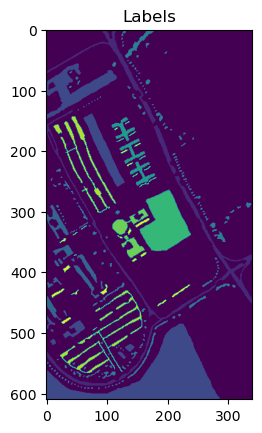

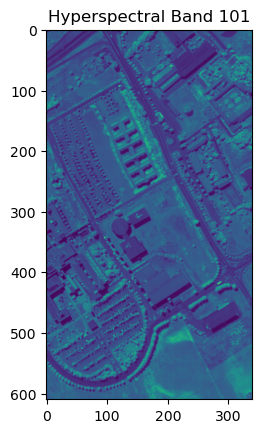

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 20 train


All datasets saved to the 'indices' folder.
(180, 5, 5, 103)
(45, 5, 5, 103)
(42551, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1167, PSNR: 7.5400


	 Training Batch [200/535], Loss: 0.0599, PSNR: 10.2231


	 Training Batch [400/535], Loss: 0.0300, PSNR: 11.7432


Epoch [1/50] Training Loss: 0.0545, PSNR: 11.2512
	[Val]   Batch [1/134] Loss: 0.0185, PSNR: 15.5162
	[Val]   Batch [10/134] Loss: 0.0162, PSNR: 17.9019
	[Val]   Batch [20/134] Loss: 0.0173, PSNR: 15.7158
	[Val]   Batch [30/134] Loss: 0.0190, PSNR: 15.1438
	[Val]   Batch [40/134] Loss: 0.0171, PSNR: 14.2205
	[Val]   Batch [50/134] Loss: 0.0183, PSNR: 15.3473


	[Val]   Batch [60/134] Loss: 0.0164, PSNR: 16.0609
	[Val]   Batch [70/134] Loss: 0.0156, PSNR: 16.2428
	[Val]   Batch [80/134] Loss: 0.0153, PSNR: 16.2327
	[Val]   Batch [90/134] Loss: 0.0161, PSNR: 16.2110
	[Val]   Batch [100/134] Loss: 0.0182, PSNR: 15.6060
	[Val]   Batch [110/134] Loss: 0.0185, PSNR: 14.1354
	[Val]   Batch [120/134] Loss: 0.0150, PSNR: 15.3298


	[Val]   Batch [130/134] Loss: 0.0166, PSNR: 13.3389
Epoch [1/50] Validation Loss: 0.0174, PSNR: 15.5676

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0184, PSNR: 16.8681


	 Training Batch [200/535], Loss: 0.0114, PSNR: 17.6528


	 Training Batch [400/535], Loss: 0.0093, PSNR: 17.4231


Epoch [2/50] Training Loss: 0.0114, PSNR: 17.5004
	[Val]   Batch [1/134] Loss: 0.0085, PSNR: 18.9249
	[Val]   Batch [10/134] Loss: 0.0067, PSNR: 21.7374
	[Val]   Batch [20/134] Loss: 0.0072, PSNR: 19.5061
	[Val]   Batch [30/134] Loss: 0.0083, PSNR: 18.7317
	[Val]   Batch [40/134] Loss: 0.0074, PSNR: 17.8487
	[Val]   Batch [50/134] Loss: 0.0077, PSNR: 19.0812
	[Val]   Batch [60/134] Loss: 0.0067, PSNR: 19.9579


	[Val]   Batch [70/134] Loss: 0.0065, PSNR: 20.0323
	[Val]   Batch [80/134] Loss: 0.0062, PSNR: 20.1534
	[Val]   Batch [90/134] Loss: 0.0066, PSNR: 20.0510
	[Val]   Batch [100/134] Loss: 0.0080, PSNR: 19.1844
	[Val]   Batch [110/134] Loss: 0.0075, PSNR: 18.0401
	[Val]   Batch [120/134] Loss: 0.0055, PSNR: 19.7027
	[Val]   Batch [130/134] Loss: 0.0067, PSNR: 17.2701
Epoch [2/50] Validation Loss: 0.0075, PSNR: 19.2175

LOG: Epoch [3/50]


	 Training Batch [1/535], Loss: 0.0075, PSNR: 19.2382


	 Training Batch [200/535], Loss: 0.0086, PSNR: 18.9514


	 Training Batch [400/535], Loss: 0.0068, PSNR: 19.9692


Epoch [3/50] Training Loss: 0.0066, PSNR: 19.8068
	[Val]   Batch [1/134] Loss: 0.0059, PSNR: 20.5149
	[Val]   Batch [10/134] Loss: 0.0046, PSNR: 23.3640
	[Val]   Batch [20/134] Loss: 0.0049, PSNR: 21.1792
	[Val]   Batch [30/134] Loss: 0.0056, PSNR: 20.4416
	[Val]   Batch [40/134] Loss: 0.0051, PSNR: 19.4562
	[Val]   Batch [50/134] Loss: 0.0052, PSNR: 20.8517
	[Val]   Batch [60/134] Loss: 0.0045, PSNR: 21.6633


	[Val]   Batch [70/134] Loss: 0.0045, PSNR: 21.6446
	[Val]   Batch [80/134] Loss: 0.0042, PSNR: 21.8290
	[Val]   Batch [90/134] Loss: 0.0045, PSNR: 21.7075
	[Val]   Batch [100/134] Loss: 0.0055, PSNR: 20.8169
	[Val]   Batch [110/134] Loss: 0.0049, PSNR: 19.9112
	[Val]   Batch [120/134] Loss: 0.0035, PSNR: 21.6944
	[Val]   Batch [130/134] Loss: 0.0044, PSNR: 19.0843
Epoch [3/50] Validation Loss: 0.0052, PSNR: 20.8427

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0055, PSNR: 20.7756


	 Training Batch [200/535], Loss: 0.0047, PSNR: 19.6162


	 Training Batch [400/535], Loss: 0.0043, PSNR: 21.8910


Epoch [4/50] Training Loss: 0.0047, PSNR: 21.2689
	[Val]   Batch [1/134] Loss: 0.0041, PSNR: 22.0594
	[Val]   Batch [10/134] Loss: 0.0033, PSNR: 24.8594
	[Val]   Batch [20/134] Loss: 0.0033, PSNR: 22.9121
	[Val]   Batch [30/134] Loss: 0.0037, PSNR: 22.1876
	[Val]   Batch [40/134] Loss: 0.0034, PSNR: 21.2016
	[Val]   Batch [50/134] Loss: 0.0033, PSNR: 22.7364


	[Val]   Batch [60/134] Loss: 0.0032, PSNR: 23.0935
	[Val]   Batch [70/134] Loss: 0.0032, PSNR: 23.1652
	[Val]   Batch [80/134] Loss: 0.0030, PSNR: 23.3597
	[Val]   Batch [90/134] Loss: 0.0032, PSNR: 23.2550
	[Val]   Batch [100/134] Loss: 0.0038, PSNR: 22.4176
	[Val]   Batch [110/134] Loss: 0.0032, PSNR: 21.7884
	[Val]   Batch [120/134] Loss: 0.0023, PSNR: 23.4463


	[Val]   Batch [130/134] Loss: 0.0029, PSNR: 20.9302
Epoch [4/50] Validation Loss: 0.0036, PSNR: 22.4341

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0032, PSNR: 23.1243


	 Training Batch [200/535], Loss: 0.0029, PSNR: 22.5096


	 Training Batch [400/535], Loss: 0.0042, PSNR: 21.9295


Epoch [5/50] Training Loss: 0.0035, PSNR: 22.5668
	[Val]   Batch [1/134] Loss: 0.0031, PSNR: 23.3079
	[Val]   Batch [10/134] Loss: 0.0024, PSNR: 26.1452
	[Val]   Batch [20/134] Loss: 0.0023, PSNR: 24.4641
	[Val]   Batch [30/134] Loss: 0.0026, PSNR: 23.6969
	[Val]   Batch [40/134] Loss: 0.0024, PSNR: 22.7686
	[Val]   Batch [50/134] Loss: 0.0023, PSNR: 24.3638
	[Val]   Batch [60/134] Loss: 0.0025, PSNR: 24.2353


	[Val]   Batch [70/134] Loss: 0.0024, PSNR: 24.3883
	[Val]   Batch [80/134] Loss: 0.0022, PSNR: 24.5844
	[Val]   Batch [90/134] Loss: 0.0024, PSNR: 24.4665
	[Val]   Batch [100/134] Loss: 0.0027, PSNR: 23.8220
	[Val]   Batch [110/134] Loss: 0.0021, PSNR: 23.5808
	[Val]   Batch [120/134] Loss: 0.0016, PSNR: 24.9536
	[Val]   Batch [130/134] Loss: 0.0020, PSNR: 22.4560
Epoch [5/50] Validation Loss: 0.0027, PSNR: 23.7890

LOG: Epoch [6/50]


	 Training Batch [1/535], Loss: 0.0033, PSNR: 22.7698


	 Training Batch [200/535], Loss: 0.0030, PSNR: 23.3701


	 Training Batch [400/535], Loss: 0.0023, PSNR: 24.1971


Epoch [6/50] Training Loss: 0.0028, PSNR: 23.5458
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 23.9904
	[Val]   Batch [10/134] Loss: 0.0020, PSNR: 26.9064
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.3787
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.5477
	[Val]   Batch [40/134] Loss: 0.0019, PSNR: 23.6654
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.2620
	[Val]   Batch [60/134] Loss: 0.0021, PSNR: 24.9249


	[Val]   Batch [70/134] Loss: 0.0020, PSNR: 25.1322
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.3439
	[Val]   Batch [90/134] Loss: 0.0020, PSNR: 25.1736
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.6100
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.5798
	[Val]   Batch [120/134] Loss: 0.0013, PSNR: 25.9194
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.3202
Epoch [6/50] Validation Loss: 0.0022, PSNR: 24.5766

LOG: Epoch [7/50]


	 Training Batch [1/535], Loss: 0.0023, PSNR: 22.8793


	 Training Batch [200/535], Loss: 0.0015, PSNR: 23.9342


	 Training Batch [400/535], Loss: 0.0021, PSNR: 24.9746


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.1650
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.4945
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.4240
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.0932
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.2093
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.3508
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.9508
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.4469


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.6667
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.8948
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.6616
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.2042
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.3501
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.6309
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 23.9516
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.1679

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0024, PSNR: 24.3694


	 Training Batch [200/535], Loss: 0.0023, PSNR: 24.5653


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.1019


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.5611
	[Val]   Batch [1/134] Loss: 0.0022, PSNR: 24.8618
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.8025
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.5856
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.6543
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.8399
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4011
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.7959


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0425
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.3021
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 26.0037
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.6230
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.8727
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.0940
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.3482
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.5812

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.3211


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.0926


	 Training Batch [400/535], Loss: 0.0018, PSNR: 23.6179


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.9326
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.2949
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.2545
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.2248
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.2047
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.4693
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.9807
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.2591


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4837
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.7913
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.4631
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.1436
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.5964
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.7260
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.9218


Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.1079

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 27.3556


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.0056


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.1933


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.1653
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4675
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4333
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4666
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.3991
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.6912
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.1616


	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.4540
	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6650
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 27.0212
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.6554
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.3248
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.7828
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.9442
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.1169


Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.3058

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 25.1968


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.3024


	 Training Batch [400/535], Loss: 0.0018, PSNR: 25.4567


Epoch [11/50] Training Loss: 0.0019, PSNR: 25.3941
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6898
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6774
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.7920
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.6929
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.0172
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4397
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.7126


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.9130
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.3033
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.9044
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5933
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.1283
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2841


	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.4020
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.5871

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 24.9542


	 Training Batch [200/535], Loss: 0.0014, PSNR: 24.4104


	 Training Batch [400/535], Loss: 0.0014, PSNR: 24.3887


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.6039
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.8999
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.8719
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.0753
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.9416
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.2866
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.6974
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9339


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.0941
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5217
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.1336
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.8099
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.4243
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.5314
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.6653
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.8263

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 26.1433


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.3145


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.8579


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8121
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0748
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.0560
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.3095
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.1331
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.5207
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.9045
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1384


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.2876
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7593
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3291
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.0188
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.6548
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.7378
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.8729
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.0367

LOG: Epoch [14/50]


	 Training Batch [1/535], Loss: 0.0012, PSNR: 25.8659


	 Training Batch [200/535], Loss: 0.0011, PSNR: 25.5630


	 Training Batch [400/535], Loss: 0.0019, PSNR: 27.2547


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9768
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.2953
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2804
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6226
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.3931
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8384
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1663


	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4166
	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.5202
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0187
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5827
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.2443
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9475
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0566
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.1954
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3009

LOG: Epoch [15/50]


	 Training Batch [1/535], Loss: 0.0011, PSNR: 26.0256


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.4914


	 Training Batch [400/535], Loss: 0.0011, PSNR: 25.9639


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1274
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4763
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4540
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.8516
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.5922
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0726
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3562
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6059


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7176
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.2679
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7978
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4120
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.1480
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2406
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4099
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.5059

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6440


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.1940


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.9679


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2833
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6924
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6657
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.1861
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8698
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.3938
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.6402


	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8769
	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 27.9676
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.5401
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 28.0601
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.6854
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5018
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5218


	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7404
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.7821

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.9726


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.6672


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.5180


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.4341
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8720
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7864
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.3898
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0161
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5862
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.8058


	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.0919
	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1561
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.7378
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2583
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8522
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.6107
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6646
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.9118
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.9562

LOG: Epoch [18/50]


	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.4056


	 Training Batch [200/535], Loss: 0.0011, PSNR: 28.0525


	 Training Batch [400/535], Loss: 0.0009, PSNR: 27.1543


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.5981
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0827
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9329
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.6781
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.2939
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8102
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0295
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.3844


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.4231
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.9629
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.5118
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.1113
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7926
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7764
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1461
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.1812

LOG: Epoch [19/50]


	 Training Batch [1/535], Loss: 0.0010, PSNR: 26.5564


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.6553


	 Training Batch [400/535], Loss: 0.0009, PSNR: 27.1955


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.8275
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3887
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.1677
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0664
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.6745
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.1964
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.3791
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.7747


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.7835
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.3326
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.8678
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.4831
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0664
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0457
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.5070
Epoch [19/50] Validation Loss: 0.0009, PSNR: 28.5280

LOG: Epoch [20/50]


	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.9427


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.6856


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.0999


Epoch [20/50] Training Loss: 0.0013, PSNR: 27.0155
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.6386
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.3758
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.3226
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.9555
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.4758
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.6216
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.0825


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.1257
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.6121
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.1940
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7908
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1847
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1797
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.7533
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.7885

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.9538


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.3628


	 Training Batch [400/535], Loss: 0.0010, PSNR: 26.6749


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.1848
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.8256
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4885
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.4359
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.1627
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.5646
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.7760
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.3132


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.3026
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.7491
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.4215
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.0016
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1751
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1098
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.8240
Epoch [21/50] Validation Loss: 0.0008, PSNR: 28.9461

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.8281


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.6038


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.6019


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.4273
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.2405
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.8077
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7965
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.6098
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9114
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.1399
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.6651


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.7423
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.1134
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.8603
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.3919
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4426
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3925
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.2116


Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.3220

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.1585


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.8166


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.5726


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.5827
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.4579
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.9827
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.9028
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.7914
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 29.0210
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.2999
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.8437


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.9865
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2805
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.0572
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.6115
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4364
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3719
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.2450
Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.4918

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 26.8453


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.6045


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.5343


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.7926
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.8641
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3124
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.1974
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.2366
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2959
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7433


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.1887
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.3460
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5979
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.4729
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 30.0184
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7056
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6667


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5010
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.8495

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.6698


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.8558


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.7394


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.9310
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.1675
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.5488
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.4899
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.5588
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5249
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0249


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4068
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.6350
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.7864
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.7722
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3275
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9774
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8008


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7447
Epoch [25/50] Validation Loss: 0.0006, PSNR: 30.1313

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 29.1224


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.6592


	 Training Batch [400/535], Loss: 0.0008, PSNR: 29.0862


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0768
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.3485
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6389
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5230
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.7090
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5202
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0817
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.5365


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7570
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8957
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 30.9027
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.4262
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9399
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8508
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7635
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.2383

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.9915


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.5006


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.2803


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.2318
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.5659
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.8288
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7538
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.9589
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.7245
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.3177
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.7187


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.9609
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.0377
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.1238
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.6738
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1309
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9442
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.9659
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.4573

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0007, PSNR: 27.8111


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.1525


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.7535


Epoch [28/50] Training Loss: 0.0009, PSNR: 28.4150
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.8764
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 32.0301
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.0140
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.2173
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.9218
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.5930


	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.8963
	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.2018
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.2174
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.3923
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.9466
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.3084
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.1350
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1466


Epoch [28/50] Validation Loss: 0.0005, PSNR: 30.7024
Early stopping triggered at epoch 28. No improvement for 3 epochs.


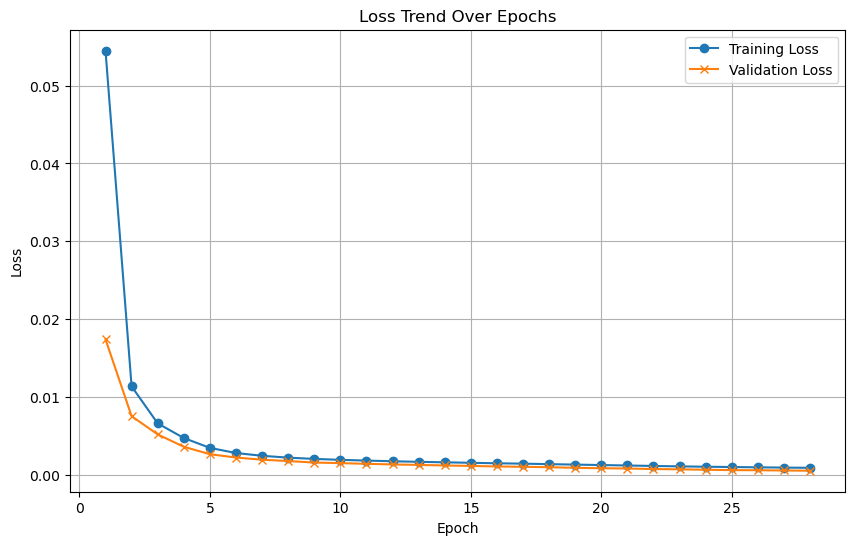

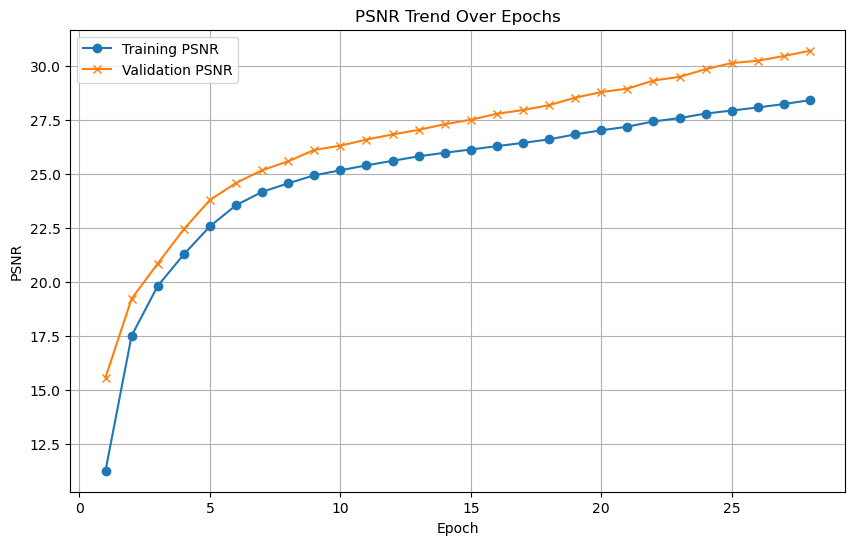

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...


    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2296
    Validation Batch [1/1], Loss: 2.2031
Validation Loss: 2.2031, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2031. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1847
    Validation Batch [1/1], Loss: 2.2031
Validation Loss: 2.2031, Validation Accuracy: 11.11%
Validation loss improved from 2.2031 to 2.2031. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1592
    Validation Batch [1/1], Loss: 2.2031
Validation Loss: 2.2031, Validation Accuracy: 11.11%
Validation loss improved from 2.2031 to 2.2031. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1290
    Validation Batch [1/1], Loss: 2.2030
Validation Loss: 2.2030, Validation Accuracy: 11.11%
Validation loss improved from 2.2031 to 2.2030. Saving model...

LOG: Epoch [5/1000

Epoch [18/1000] completed, Average Training Loss: 1.9280
    Validation Batch [1/1], Loss: 2.1994
Validation Loss: 2.1994, Validation Accuracy: 11.11%
Validation loss improved from 2.2003 to 2.1994. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 1.9281
    Validation Batch [1/1], Loss: 2.1986
Validation Loss: 2.1986, Validation Accuracy: 11.11%
Validation loss improved from 2.1994 to 2.1986. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 1.9054
    Validation Batch [1/1], Loss: 2.1976
Validation Loss: 2.1976, Validation Accuracy: 11.11%
Validation loss improved from 2.1986 to 2.1976. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 1.8711
    Validation Batch [1/1], Loss: 2.1964
Validation Loss: 2.1964, Validation Accuracy: 11.11%
Validation loss improved from 2.1976 to 2.1964. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [2

Epoch [48/1000] completed, Average Training Loss: 1.6672
    Validation Batch [1/1], Loss: 1.8647
Validation Loss: 1.8647, Validation Accuracy: 44.44%
Validation loss improved from 1.8835 to 1.8647. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 1.6698
    Validation Batch [1/1], Loss: 1.8460
Validation Loss: 1.8460, Validation Accuracy: 44.44%
Validation loss improved from 1.8647 to 1.8460. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.6447
    Validation Batch [1/1], Loss: 1.8279
Validation Loss: 1.8279, Validation Accuracy: 46.67%
Validation loss improved from 1.8460 to 1.8279. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 1.6408
    Validation Batch [1/1], Loss: 1.8111
Validation Loss: 1.8111, Validation Accuracy: 48.89%
Validation loss improved from 1.8279 to 1.8111. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [5

Epoch [76/1000] completed, Average Training Loss: 1.4509
    Validation Batch [1/1], Loss: 1.5180
Validation Loss: 1.5180, Validation Accuracy: 68.89%
Validation loss improved from 1.5267 to 1.5180. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.4334
    Validation Batch [1/1], Loss: 1.5087
Validation Loss: 1.5087, Validation Accuracy: 68.89%
Validation loss improved from 1.5180 to 1.5087. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 1.4451
    Validation Batch [1/1], Loss: 1.5006
Validation Loss: 1.5006, Validation Accuracy: 71.11%
Validation loss improved from 1.5087 to 1.5006. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 1.4334
    Validation Batch [1/1], Loss: 1.4922
Validation Loss: 1.4922, Validation Accuracy: 71.11%
Validation loss improved from 1.5006 to 1.4922. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [8

Epoch [106/1000] completed, Average Training Loss: 1.2182
    Validation Batch [1/1], Loss: 1.2719
Validation Loss: 1.2719, Validation Accuracy: 82.22%
Validation loss improved from 1.2836 to 1.2719. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.2450
    Validation Batch [1/1], Loss: 1.2600
Validation Loss: 1.2600, Validation Accuracy: 82.22%
Validation loss improved from 1.2719 to 1.2600. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.1802
    Validation Batch [1/1], Loss: 1.2560
Validation Loss: 1.2560, Validation Accuracy: 80.00%
Validation loss improved from 1.2600 to 1.2560. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.1698
    Validation Batch [1/1], Loss: 1.2458
Validation Loss: 1.2458, Validation Accuracy: 77.78%
Validation loss improved from 1.2560 to 1.2458. Saving model...

LOG: Epoch [110/1000] - Training


Epoch [134/1000] completed, Average Training Loss: 0.9692
    Validation Batch [1/1], Loss: 1.0000
Validation Loss: 1.0000, Validation Accuracy: 88.89%
Validation loss improved from 1.0130 to 1.0000. Saving model...

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 0.9321
    Validation Batch [1/1], Loss: 1.0002
Validation Loss: 1.0002, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.9149
    Validation Batch [1/1], Loss: 1.0036
Validation Loss: 1.0036, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.9131
    Validation Batch [1/1], Loss: 0.9886
Validation Loss: 0.9886, Validation Accuracy: 91.11%
Validation loss improved from 1.0000 to 0.9886. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Av

    Validation Batch [1/1], Loss: 0.7555
Validation Loss: 0.7555, Validation Accuracy: 95.56%
Validation loss improved from 0.7745 to 0.7555. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 0.6945
    Validation Batch [1/1], Loss: 0.7435
Validation Loss: 0.7435, Validation Accuracy: 97.78%
Validation loss improved from 0.7555 to 0.7435. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 0.6973
    Validation Batch [1/1], Loss: 0.7577
Validation Loss: 0.7577, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 0.6962
    Validation Batch [1/1], Loss: 0.7705
Validation Loss: 0.7705, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 0.7099
    Validation Batch [1/1], Lo

Epoch [191/1000] completed, Average Training Loss: 0.5206
    Validation Batch [1/1], Loss: 0.5815
Validation Loss: 0.5815, Validation Accuracy: 95.56%
Validation loss improved from 0.5818 to 0.5815. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.5433
    Validation Batch [1/1], Loss: 0.5726
Validation Loss: 0.5726, Validation Accuracy: 95.56%
Validation loss improved from 0.5815 to 0.5726. Saving model...

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.5180
    Validation Batch [1/1], Loss: 0.5660
Validation Loss: 0.5660, Validation Accuracy: 95.56%
Validation loss improved from 0.5726 to 0.5660. Saving model...

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.5379
    Validation Batch [1/1], Loss: 0.5572
Validation Loss: 0.5572, Validation Accuracy: 95.56%
Validation loss improved from 0.5660 to 0.5572. Saving model...

LOG: Epoch [195/1000] - Training


    Validation Batch [1/1], Loss: 0.4176
Validation Loss: 0.4176, Validation Accuracy: 95.56%
Validation loss improved from 0.4202 to 0.4176. Saving model...

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.3883
    Validation Batch [1/1], Loss: 0.4179
Validation Loss: 0.4179, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.3387
    Validation Batch [1/1], Loss: 0.4104
Validation Loss: 0.4104, Validation Accuracy: 95.56%
Validation loss improved from 0.4176 to 0.4104. Saving model...

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.3505
    Validation Batch [1/1], Loss: 0.4011
Validation Loss: 0.4011, Validation Accuracy: 95.56%
Validation loss improved from 0.4104 to 0.4011. Saving model...

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.3546
    Validation 

    Validation Batch [1/1], Loss: 0.3219
Validation Loss: 0.3219, Validation Accuracy: 95.56%
Validation loss improved from 0.3285 to 0.3219. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.2732
    Validation Batch [1/1], Loss: 0.3160
Validation Loss: 0.3160, Validation Accuracy: 95.56%
Validation loss improved from 0.3219 to 0.3160. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.2783
    Validation Batch [1/1], Loss: 0.3034
Validation Loss: 0.3034, Validation Accuracy: 95.56%
Validation loss improved from 0.3160 to 0.3034. Saving model...

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.2419
    Validation Batch [1/1], Loss: 0.2960
Validation Loss: 0.2960, Validation Accuracy: 97.78%
Validation loss improved from 0.3034 to 0.2960. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.2819


Epoch [280/1000] completed, Average Training Loss: 0.1941
    Validation Batch [1/1], Loss: 0.2503
Validation Loss: 0.2503, Validation Accuracy: 95.56%
Validation loss improved from 0.2545 to 0.2503. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.1794
    Validation Batch [1/1], Loss: 0.2343
Validation Loss: 0.2343, Validation Accuracy: 97.78%
Validation loss improved from 0.2503 to 0.2343. Saving model...

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.2086
    Validation Batch [1/1], Loss: 0.2319
Validation Loss: 0.2319, Validation Accuracy: 97.78%
Validation loss improved from 0.2343 to 0.2319. Saving model...

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.1787
    Validation Batch [1/1], Loss: 0.2426
Validation Loss: 0.2426, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000

Epoch [311/1000] completed, Average Training Loss: 0.1503
    Validation Batch [1/1], Loss: 0.2084
Validation Loss: 0.2084, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.1563
    Validation Batch [1/1], Loss: 0.2223
Validation Loss: 0.2223, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.1531
    Validation Batch [1/1], Loss: 0.2211
Validation Loss: 0.2211, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.1642
    Validation Batch [1/1], Loss: 0.2147
Validation Loss: 0.2147, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.1615
  

    Validation Batch [1/1], Loss: 0.2177
Validation Loss: 0.2177, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.1261
    Validation Batch [1/1], Loss: 0.2095
Validation Loss: 0.2095, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.1170
    Validation Batch [1/1], Loss: 0.1832
Validation Loss: 0.1832, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.1207
    Validation Batch [1/1], Loss: 0.1811
Validation Loss: 0.1811, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.1091
    Validation Batch [1/1], Loss: 0.1896
Validation Loss: 0.

Epoch [370/1000] completed, Average Training Loss: 0.1008
    Validation Batch [1/1], Loss: 0.1661
Validation Loss: 0.1661, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.1040
    Validation Batch [1/1], Loss: 0.1389
Validation Loss: 0.1389, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.1005
    Validation Batch [1/1], Loss: 0.1368
Validation Loss: 0.1368, Validation Accuracy: 97.78%
Validation loss improved from 0.1381 to 0.1368. Saving model...

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0877
    Validation Batch [1/1], Loss: 0.1321
Validation Loss: 0.1321, Validation Accuracy: 97.78%
Validation loss improved from 0.1368 to 0.1321. Saving model...

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Av

Epoch [399/1000] completed, Average Training Loss: 0.0957
    Validation Batch [1/1], Loss: 0.1566
Validation Loss: 0.1566, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0839
    Validation Batch [1/1], Loss: 0.1770
Validation Loss: 0.1770, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0828
    Validation Batch [1/1], Loss: 0.1788
Validation Loss: 0.1788, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0813
    Validation Batch [1/1], Loss: 0.1699
Validation Loss: 0.1699, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.098

Epoch [430/1000] completed, Average Training Loss: 0.0695
    Validation Batch [1/1], Loss: 0.1388
Validation Loss: 0.1388, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.0720
    Validation Batch [1/1], Loss: 0.1332
Validation Loss: 0.1332, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.0690
    Validation Batch [1/1], Loss: 0.1360
Validation Loss: 0.1360, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0657
    Validation Batch [1/1], Loss: 0.1320
Validation Loss: 0.1320, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0613
  

Epoch [460/1000] completed, Average Training Loss: 0.0667
    Validation Batch [1/1], Loss: 0.1596
Validation Loss: 0.1596, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.1772
Validation Loss: 0.1772, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.1824
Validation Loss: 0.1824, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.0624
    Validation Batch [1/1], Loss: 0.1621
Validation Loss: 0.1621, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.0555
  

Epoch [489/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.0893
Validation Loss: 0.0893, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.0538
    Validation Batch [1/1], Loss: 0.0916
Validation Loss: 0.0916, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0549
    Validation Batch [1/1], Loss: 0.0948
Validation Loss: 0.0948, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0481
    Validation Batch [1/1], Loss: 0.1263
Validation Loss: 0.1263, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.054

Epoch [518/1000] completed, Average Training Loss: 0.0471
    Validation Batch [1/1], Loss: 0.1197
Validation Loss: 0.1197, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.1179
Validation Loss: 0.1179, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0502
    Validation Batch [1/1], Loss: 0.1039
Validation Loss: 0.1039, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0531
    Validation Batch [1/1], Loss: 0.1173
Validation Loss: 0.1173, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.042

Epoch [547/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.0940
Validation Loss: 0.0940, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0385
    Validation Batch [1/1], Loss: 0.0959
Validation Loss: 0.0959, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.1028
Validation Loss: 0.1028, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.1086
Validation Loss: 0.1086, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.033

Epoch [577/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.0863
Validation Loss: 0.0863, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [578/1000] - Training
Epoch [578/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.0894
Validation Loss: 0.0894, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [579/1000] - Training
Epoch [579/1000] completed, Average Training Loss: 0.0367
    Validation Batch [1/1], Loss: 0.1107
Validation Loss: 0.1107, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.0426
    Validation Batch [1/1], Loss: 0.1306
Validation Loss: 0.1306, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.027

Epoch [606/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.1206
Validation Loss: 0.1206, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.0286
    Validation Batch [1/1], Loss: 0.1329
Validation Loss: 0.1329, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.0316
    Validation Batch [1/1], Loss: 0.1274
Validation Loss: 0.1274, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0288
    Validation Batch [1/1], Loss: 0.1209
Validation Loss: 0.1209, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.030

Epoch [636/1000] completed, Average Training Loss: 0.0304
    Validation Batch [1/1], Loss: 0.0991
Validation Loss: 0.0991, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.0951
Validation Loss: 0.0951, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.0927
Validation Loss: 0.0927, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.0960
Validation Loss: 0.0960, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.021

Epoch [665/1000] completed, Average Training Loss: 0.0208
    Validation Batch [1/1], Loss: 0.1109
Validation Loss: 0.1109, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [666/1000] - Training
Epoch [666/1000] completed, Average Training Loss: 0.0199
    Validation Batch [1/1], Loss: 0.1110
Validation Loss: 0.1110, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [667/1000] - Training
Epoch [667/1000] completed, Average Training Loss: 0.0296
    Validation Batch [1/1], Loss: 0.1086
Validation Loss: 0.1086, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [668/1000] - Training
Epoch [668/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.0947
Validation Loss: 0.0947, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [669/1000] - Training
Epoch [669/1000] completed, Average Training Loss: 0.030

Epoch [694/1000] completed, Average Training Loss: 0.0218
    Validation Batch [1/1], Loss: 0.0696
Validation Loss: 0.0696, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0692
Validation Loss: 0.0692, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0254
    Validation Batch [1/1], Loss: 0.0796
Validation Loss: 0.0796, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [697/1000] - Training
Epoch [697/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.0846
Validation Loss: 0.0846, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [698/1000] - Training
Epoch [698/1000] completed, Average Training Loss: 0.022

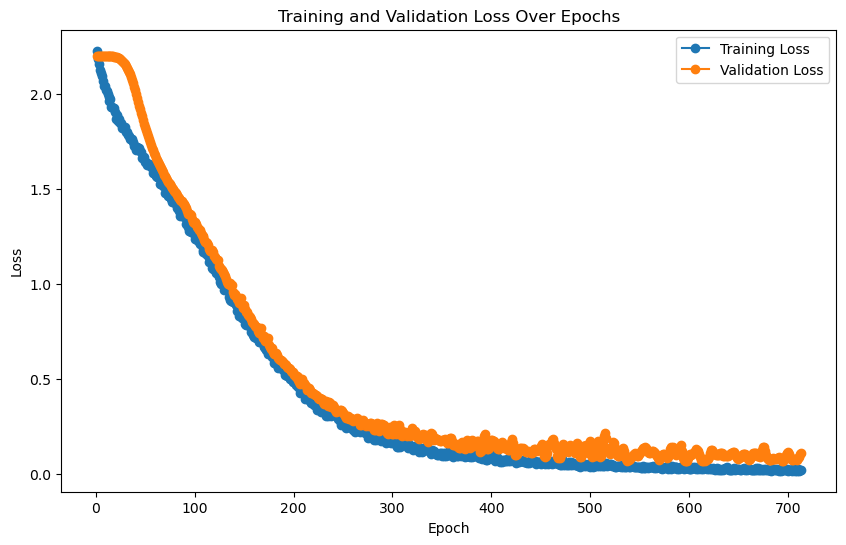

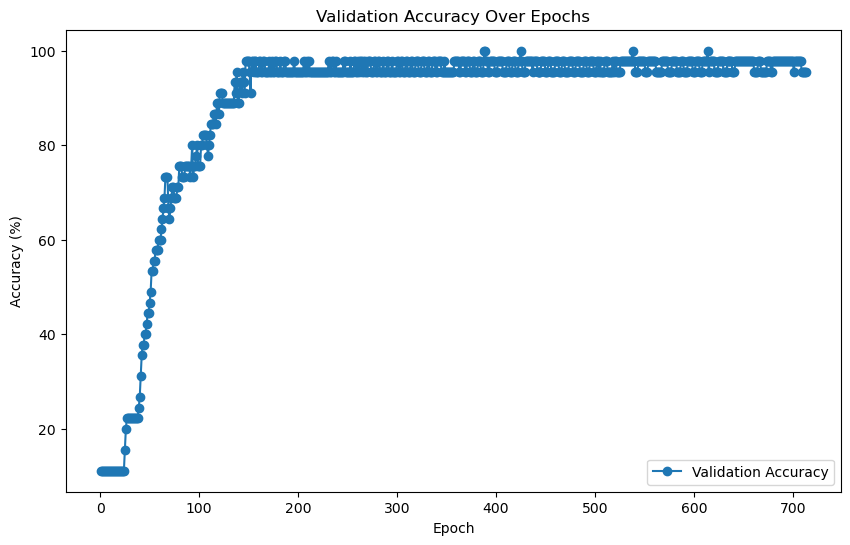


Evaluating on the test set...
    Test Batch [1/167], Loss: 0.4607



Final Test Loss: 0.4459, Test Accuracy: 87.89%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42551, 64), Test labels shape: (42551,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.78%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.57      0.80      0.67         5
           2       1.00      0.40      0.57         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.40      0.57         5
           6       0.50      0.80      0.62         5
           7       0.71      1.00      0.83         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42551, 64)
Test labels shape: (42551,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1589  |  Val Loss: 2.0839
Validation loss improved from inf to 2.0839.
[Epoch 2/1000] Train Loss: 1.9885  |  Val Loss: 1.9650
Validation loss improved from 2.0839 to 1.9650.
[Epoch 3/1000] Train Loss: 1.8920  |  Val Loss: 1.8692
Validation loss improved from 1.9650 to 1.8692.
[Epoch 4/1000] Train Loss: 1.8025  |  Val Loss: 1.7746
Validation loss improved from 1.8692 to 1.7746.
[Epoch 5/1000] Train Loss: 1.7167  |  Val Loss: 1.6823
Validation loss improved from 1.7746 to 1.6823.
[Epoch 6/1000] Train Loss: 1.6351  |  Val Loss: 1.5942
Validation loss improved from 1.6823 to 1.5942.
[Epoch 7/1000] Train Loss: 1.5605  |  Val Loss: 1.5188
Validation loss improved from 1.5942 to 1.5188.
[Epoch 8/1000] Train Loss: 1.4939  |  Val Loss: 1.4553
Validation loss improved from 1.5188 to 1.4553.
[Epoch 9/1000] Train Loss: 1.4271  |  Val Loss: 1.3953
Validation loss improved from 1.4553 to 1.3953.
[Epoch 10/1000] Train Loss: 1.3700  |  Val Loss: 1.3345
Validation loss impr

[Epoch 21/1000] Train Loss: 0.8708  |  Val Loss: 0.8666
Validation loss improved from 0.8956 to 0.8666.
[Epoch 22/1000] Train Loss: 0.8399  |  Val Loss: 0.8354
Validation loss improved from 0.8666 to 0.8354.
[Epoch 23/1000] Train Loss: 0.8179  |  Val Loss: 0.8104
Validation loss improved from 0.8354 to 0.8104.
[Epoch 24/1000] Train Loss: 0.7929  |  Val Loss: 0.7912
Validation loss improved from 0.8104 to 0.7912.
[Epoch 25/1000] Train Loss: 0.7647  |  Val Loss: 0.7665
Validation loss improved from 0.7912 to 0.7665.
[Epoch 26/1000] Train Loss: 0.7416  |  Val Loss: 0.7447
Validation loss improved from 0.7665 to 0.7447.
[Epoch 27/1000] Train Loss: 0.7219  |  Val Loss: 0.7307
Validation loss improved from 0.7447 to 0.7307.
[Epoch 28/1000] Train Loss: 0.7055  |  Val Loss: 0.7172
Validation loss improved from 0.7307 to 0.7172.
[Epoch 29/1000] Train Loss: 0.6808  |  Val Loss: 0.6961
Validation loss improved from 0.7172 to 0.6961.
[Epoch 30/1000] Train Loss: 0.6643  |  Val Loss: 0.6880
Validati

[Epoch 34/1000] Train Loss: 0.6021  |  Val Loss: 0.6479
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 0.5869  |  Val Loss: 0.6329
Validation loss improved from 0.6464 to 0.6329.
[Epoch 36/1000] Train Loss: 0.5734  |  Val Loss: 0.6116
Validation loss improved from 0.6329 to 0.6116.
[Epoch 37/1000] Train Loss: 0.5575  |  Val Loss: 0.6025
Validation loss improved from 0.6116 to 0.6025.
[Epoch 38/1000] Train Loss: 0.5472  |  Val Loss: 0.6051
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.5371  |  Val Loss: 0.6024
Validation loss improved from 0.6025 to 0.6024.
[Epoch 40/1000] Train Loss: 0.5280  |  Val Loss: 0.5873
Validation loss improved from 0.6024 to 0.5873.
[Epoch 41/1000] Train Loss: 0.5162  |  Val Loss: 0.5919
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.5058  |  Val Loss: 0.5773
Validation loss improved from 0.5873 to 0.5773.
[Epoch 43/1000] Train Loss: 0.4938  |  Val Los

[Epoch 55/1000] Train Loss: 0.3982  |  Val Loss: 0.5242
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 0.3976  |  Val Loss: 0.5101
Validation loss improved from 0.5215 to 0.5101.
[Epoch 57/1000] Train Loss: 0.3816  |  Val Loss: 0.5140
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 0.3783  |  Val Loss: 0.5114
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 59/1000] Train Loss: 0.3790  |  Val Loss: 0.5136
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 60/1000] Train Loss: 0.3693  |  Val Loss: 0.5166
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 61/1000] Train Loss: 0.3657  |  Val Loss: 0.4950
Validation loss improved from 0.5101 to 0.4950.
[Epoch 62/1000] Train Loss: 0.3594  |  Val Loss: 0.4999
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 0.3547  |  Val Loss: 0.5090
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 64/1000] Train 

[Epoch 65/1000] Train Loss: 0.3475  |  Val Loss: 0.4995
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 66/1000] Train Loss: 0.3358  |  Val Loss: 0.4904
Validation loss improved from 0.4950 to 0.4904.
[Epoch 67/1000] Train Loss: 0.3305  |  Val Loss: 0.4934
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 0.3250  |  Val Loss: 0.4924
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 69/1000] Train Loss: 0.3274  |  Val Loss: 0.4675
Validation loss improved from 0.4904 to 0.4675.
[Epoch 70/1000] Train Loss: 0.3174  |  Val Loss: 0.4851
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 71/1000] Train Loss: 0.3207  |  Val Loss: 0.4853
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 72/1000] Train Loss: 0.3143  |  Val Loss: 0.4716
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 73/1000] Train Loss: 0.3051  |  Val Loss: 0.4758
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 74/1000] Train 

[Epoch 84/1000] Train Loss: 0.2856  |  Val Loss: 0.4522
Validation loss improved from 0.4538 to 0.4522.
[Epoch 85/1000] Train Loss: 0.2654  |  Val Loss: 0.4401
Validation loss improved from 0.4522 to 0.4401.
[Epoch 86/1000] Train Loss: 0.2593  |  Val Loss: 0.4661
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 87/1000] Train Loss: 0.2572  |  Val Loss: 0.4535
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 88/1000] Train Loss: 0.2580  |  Val Loss: 0.4445
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 89/1000] Train Loss: 0.2440  |  Val Loss: 0.4735
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 90/1000] Train Loss: 0.2583  |  Val Loss: 0.4575
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 91/1000] Train Loss: 0.2670  |  Val Loss: 0.4617
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 92/1000] Train Loss: 0.2521  |  Val Loss: 0.4987
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 93/1000] Train 

[Epoch 96/1000] Train Loss: 0.2391  |  Val Loss: 0.4340
Validation loss improved from 0.4391 to 0.4340.
[Epoch 97/1000] Train Loss: 0.2238  |  Val Loss: 0.4568
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 0.2254  |  Val Loss: 0.4367
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 0.2215  |  Val Loss: 0.4453
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 100/1000] Train Loss: 0.2194  |  Val Loss: 0.4624
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 101/1000] Train Loss: 0.2171  |  Val Loss: 0.4528
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 102/1000] Train Loss: 0.2131  |  Val Loss: 0.4283
Validation loss improved from 0.4340 to 0.4283.
[Epoch 103/1000] Train Loss: 0.2166  |  Val Loss: 0.4446
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 104/1000] Train Loss: 0.2085  |  Val Loss: 0.4653
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 105/1000] 

[Epoch 115/1000] Train Loss: 0.1844  |  Val Loss: 0.4758
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 116/1000] Train Loss: 0.1846  |  Val Loss: 0.4550
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 117/1000] Train Loss: 0.1821  |  Val Loss: 0.4484
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 118/1000] Train Loss: 0.1758  |  Val Loss: 0.4841
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 119/1000] Train Loss: 0.1791  |  Val Loss: 0.4602
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 120/1000] Train Loss: 0.1744  |  Val Loss: 0.4615
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 121/1000] Train Loss: 0.1800  |  Val Loss: 0.5063
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 122/1000] Train Loss: 0.1756  |  Val Loss: 0.4859
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 123/1000] Train Loss: 0.1740  |  Val Loss: 0.4665
!! Validation loss did NOT improve !! Patience:

[Epoch 128/1000] Train Loss: 0.1600  |  Val Loss: 0.4756
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 129/1000] Train Loss: 0.1632  |  Val Loss: 0.4949
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 130/1000] Train Loss: 0.1560  |  Val Loss: 0.4664
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 131/1000] Train Loss: 0.1572  |  Val Loss: 0.5069
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 132/1000] Train Loss: 0.1600  |  Val Loss: 0.4636
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 133/1000] Train Loss: 0.1623  |  Val Loss: 0.4736
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 134/1000] Train Loss: 0.1506  |  Val Loss: 0.5112
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 135/1000] Train Loss: 0.1547  |  Val Loss: 0.5068
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 136/1000] Train Loss: 0.1504  |  Val Loss: 0.5086
!! Validation loss did NOT improve !! Patience:

[Epoch 148/1000] Train Loss: 0.1429  |  Val Loss: 0.6048
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 149/1000] Train Loss: 0.1372  |  Val Loss: 0.4656
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 150/1000] Train Loss: 0.1612  |  Val Loss: 0.4656
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 151/1000] Train Loss: 0.1369  |  Val Loss: 0.6212
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 152/1000] Train Loss: 0.1556  |  Val Loss: 0.4572
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 153/1000] Train Loss: 0.1434  |  Val Loss: 0.4611
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 154/1000] Train Loss: 0.1431  |  Val Loss: 0.5750
!! Validation loss did NOT improve !! Patience: 52/100


[Epoch 155/1000] Train Loss: 0.1335  |  Val Loss: 0.4772
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 156/1000] Train Loss: 0.1330  |  Val Loss: 0.4893
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 157/1000] Train Loss: 0.1253  |  Val Loss: 0.5514
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 158/1000] Train Loss: 0.1283  |  Val Loss: 0.5337
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 159/1000] Train Loss: 0.1315  |  Val Loss: 0.4901
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 160/1000] Train Loss: 0.1288  |  Val Loss: 0.5772
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 161/1000] Train Loss: 0.1231  |  Val Loss: 0.5044
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 162/1000] Train Loss: 0.1249  |  Val Loss: 0.4960
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 163/1000] Train Loss: 0.1275  |  Val Loss: 0.5529
!! Validation loss did NOT improve !! Patience:

[Epoch 180/1000] Train Loss: 0.1004  |  Val Loss: 0.5712
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 181/1000] Train Loss: 0.1040  |  Val Loss: 0.5833
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 182/1000] Train Loss: 0.1002  |  Val Loss: 0.6149
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 183/1000] Train Loss: 0.1063  |  Val Loss: 0.5752
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 184/1000] Train Loss: 0.1024  |  Val Loss: 0.5878
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 185/1000] Train Loss: 0.1028  |  Val Loss: 0.5729
!! Validation loss did NOT improve !! Patience: 83/100


[Epoch 186/1000] Train Loss: 0.0971  |  Val Loss: 0.5829
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 187/1000] Train Loss: 0.1034  |  Val Loss: 0.5714
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 188/1000] Train Loss: 0.0966  |  Val Loss: 0.5576
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 189/1000] Train Loss: 0.1029  |  Val Loss: 0.6160
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 190/1000] Train Loss: 0.0978  |  Val Loss: 0.5793
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 191/1000] Train Loss: 0.0987  |  Val Loss: 0.5581
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 192/1000] Train Loss: 0.0955  |  Val Loss: 0.6302
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 193/1000] Train Loss: 0.0995  |  Val Loss: 0.5919
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 194/1000] Train Loss: 0.0964  |  Val Loss: 0.5745
!! Validation loss did NOT improve !! Patience:

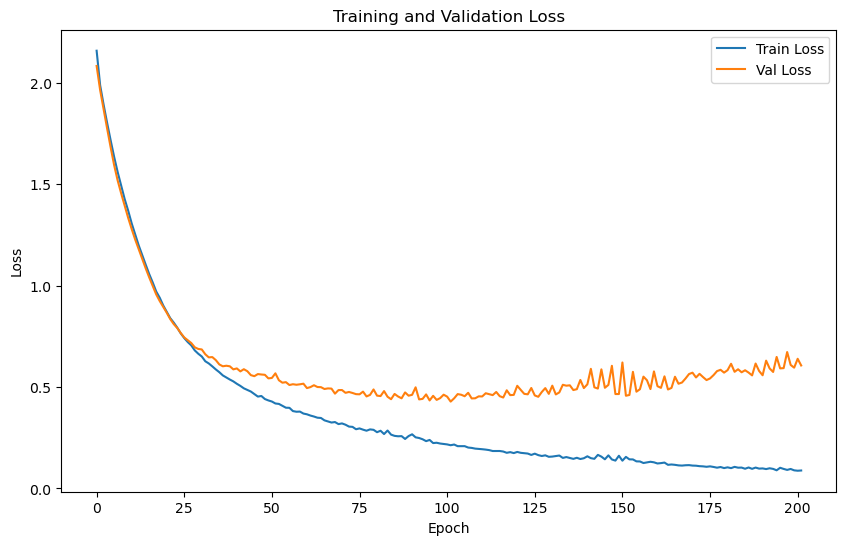

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.3114 | Test Accuracy: 74.98%


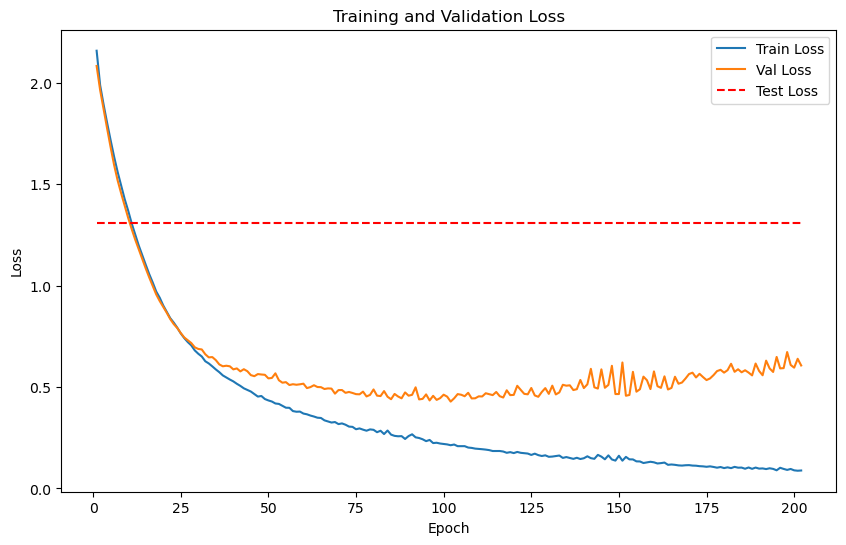

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 9.5579
Epoch [1/2000], Avg Train Loss: 9.5579
Epoch [1/2000], Avg Val Loss: 4.4868
Validation loss improved from inf to 4.4868. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.2317
Epoch [2/2000], Avg Train Loss: 9.2317
Epoch [2/2000], Avg Val Loss: 4.4343
Validation loss improved from 4.4868 to 4.4343. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.2930
Epoch [3/2000], Avg Train Loss: 9.2930
Epoch [3/2000], Avg Val Loss: 4.3830
Validation loss improved from 4.4343 to 4.3830. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.1334
Epoch [4/2000], Avg Train Loss: 9.1334
Epoch [4/2000], Avg Val Loss: 4.3329
Validation loss improved from 4.3830 to 4.3329. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 9.0969
Epoch [5/2000], Avg Train Loss: 9.0969
Epoch [5/2000], Avg Val Loss: 4.2839
Validation loss improved fr

    Batch [1/1], Train Loss: 8.9839
Epoch [6/2000], Avg Train Loss: 8.9839
Epoch [6/2000], Avg Val Loss: 4.2359
Validation loss improved from 4.2839 to 4.2359. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 8.8567
Epoch [7/2000], Avg Train Loss: 8.8567
Epoch [7/2000], Avg Val Loss: 4.1893
Validation loss improved from 4.2359 to 4.1893. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 9.0052
Epoch [8/2000], Avg Train Loss: 9.0052
Epoch [8/2000], Avg Val Loss: 4.1437
Validation loss improved from 4.1893 to 4.1437. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 8.7897
Epoch [9/2000], Avg Train Loss: 8.7897
Epoch [9/2000], Avg Val Loss: 4.0993
Validation loss improved from 4.1437 to 4.0993. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 8.7429
Epoch [10/2000], Avg Train Loss: 8.7429
Epoch [10/2000], Avg Val Loss: 4.0558
Validation loss improved from 4.0993 to 4.0558. Savin

    Batch [1/1], Train Loss: 8.1288
Epoch [19/2000], Avg Train Loss: 8.1288
Epoch [19/2000], Avg Val Loss: 3.7092
Validation loss improved from 3.7439 to 3.7092. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 8.0180
Epoch [20/2000], Avg Train Loss: 8.0180
Epoch [20/2000], Avg Val Loss: 3.6755
Validation loss improved from 3.7092 to 3.6755. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.9480
Epoch [21/2000], Avg Train Loss: 7.9480
Epoch [21/2000], Avg Val Loss: 3.6427
Validation loss improved from 3.6755 to 3.6427. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.7681
Epoch [22/2000], Avg Train Loss: 7.7681
Epoch [22/2000], Avg Val Loss: 3.6109
Validation loss improved from 3.6427 to 3.6109. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.8473
Epoch [23/2000], Avg Train Loss: 7.8473
Epoch [23/2000], Avg Val Loss: 3.5800
Validation loss improved from 3.6109 to 3.

Epoch [47/2000], Avg Val Loss: 3.0649
Validation loss improved from 3.0790 to 3.0649. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.4606
Epoch [48/2000], Avg Train Loss: 6.4606
Epoch [48/2000], Avg Val Loss: 3.0514
Validation loss improved from 3.0649 to 3.0514. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.2999
Epoch [49/2000], Avg Train Loss: 6.2999
Epoch [49/2000], Avg Val Loss: 3.0384
Validation loss improved from 3.0514 to 3.0384. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.3005
Epoch [50/2000], Avg Train Loss: 6.3005
Epoch [50/2000], Avg Val Loss: 3.0259
Validation loss improved from 3.0384 to 3.0259. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 6.2430
Epoch [51/2000], Avg Train Loss: 6.2430
Epoch [51/2000], Avg Val Loss: 3.0138
Validation loss improved from 3.0259 to 3.0138. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.8965
Epoch [62/2000], Avg Train Loss: 5.8965
Epoch [62/2000], Avg Val Loss: 2.9081
Validation loss improved from 2.9159 to 2.9081. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.7868
Epoch [63/2000], Avg Train Loss: 5.7868
Epoch [63/2000], Avg Val Loss: 2.9006
Validation loss improved from 2.9081 to 2.9006. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.8161
Epoch [64/2000], Avg Train Loss: 5.8161
Epoch [64/2000], Avg Val Loss: 2.8934
Validation loss improved from 2.9006 to 2.8934. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.7249
Epoch [65/2000], Avg Train Loss: 5.7249
Epoch [65/2000], Avg Val Loss: 2.8865
Validation loss improved from 2.8934 to 2.8865. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.6189
Epoch [66/2000], Avg Train Loss: 5.6189
Epoch [66/2000], Avg Val Loss: 2.8798
Validation loss improved from 2.8865 to 2.

    Batch [1/1], Train Loss: 5.2593
Epoch [89/2000], Avg Train Loss: 5.2593
Epoch [89/2000], Avg Val Loss: 2.7842
Validation loss improved from 2.7867 to 2.7842. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.2959
Epoch [90/2000], Avg Train Loss: 5.2959
Epoch [90/2000], Avg Val Loss: 2.7817
Validation loss improved from 2.7842 to 2.7817. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.2303
Epoch [91/2000], Avg Train Loss: 5.2303
Epoch [91/2000], Avg Val Loss: 2.7794
Validation loss improved from 2.7817 to 2.7794. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.1896
Epoch [92/2000], Avg Train Loss: 5.1896
Epoch [92/2000], Avg Val Loss: 2.7771
Validation loss improved from 2.7794 to 2.7771. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.2978
Epoch [93/2000], Avg Train Loss: 5.2978
Epoch [93/2000], Avg Val Loss: 2.7748
Validation loss improved from 2.7771 to 2.

    Batch [1/1], Train Loss: 5.0390
Epoch [102/2000], Avg Train Loss: 5.0390
Epoch [102/2000], Avg Val Loss: 2.7583
Validation loss improved from 2.7599 to 2.7583. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 5.1030
Epoch [103/2000], Avg Train Loss: 5.1030
Epoch [103/2000], Avg Val Loss: 2.7568
Validation loss improved from 2.7583 to 2.7568. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 5.0908
Epoch [104/2000], Avg Train Loss: 5.0908
Epoch [104/2000], Avg Val Loss: 2.7554
Validation loss improved from 2.7568 to 2.7554. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 5.0614
Epoch [105/2000], Avg Train Loss: 5.0614
Epoch [105/2000], Avg Val Loss: 2.7540
Validation loss improved from 2.7554 to 2.7540. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 5.0402
Epoch [106/2000], Avg Train Loss: 5.0402
Epoch [106/2000], Avg Val Loss: 2.7526
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8739
Epoch [133/2000], Avg Train Loss: 4.8739
Epoch [133/2000], Avg Val Loss: 2.7230
Validation loss improved from 2.7240 to 2.7230. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.8639
Epoch [134/2000], Avg Train Loss: 4.8639
Epoch [134/2000], Avg Val Loss: 2.7220
Validation loss improved from 2.7230 to 2.7220. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.8011
Epoch [135/2000], Avg Train Loss: 4.8011
Epoch [135/2000], Avg Val Loss: 2.7210
Validation loss improved from 2.7220 to 2.7210. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.7598
Epoch [136/2000], Avg Train Loss: 4.7598
Epoch [136/2000], Avg Val Loss: 2.7201
Validation loss improved from 2.7210 to 2.7201. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.7931
Epoch [137/2000], Avg Train Loss: 4.7931
Epoch [137/2000], Avg Val Loss: 2.7191
Validation loss improved fro

Epoch [144/2000], Avg Val Loss: 2.7122
Validation loss improved from 2.7132 to 2.7122. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.6964
Epoch [145/2000], Avg Train Loss: 4.6964
Epoch [145/2000], Avg Val Loss: 2.7111
Validation loss improved from 2.7122 to 2.7111. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.7509
Epoch [146/2000], Avg Train Loss: 4.7509
Epoch [146/2000], Avg Val Loss: 2.7101
Validation loss improved from 2.7111 to 2.7101. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.7293
Epoch [147/2000], Avg Train Loss: 4.7293
Epoch [147/2000], Avg Val Loss: 2.7091
Validation loss improved from 2.7101 to 2.7091. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.7348
Epoch [148/2000], Avg Train Loss: 4.7348
Epoch [148/2000], Avg Val Loss: 2.7081
Validation loss improved from 2.7091 to 2.7081. Saving model...

LOG: Epoch [149/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6062
Epoch [171/2000], Avg Train Loss: 4.6062
Epoch [171/2000], Avg Val Loss: 2.6872
Validation loss improved from 2.6881 to 2.6872. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.5956
Epoch [172/2000], Avg Train Loss: 4.5956
Epoch [172/2000], Avg Val Loss: 2.6864
Validation loss improved from 2.6872 to 2.6864. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.6264
Epoch [173/2000], Avg Train Loss: 4.6264
Epoch [173/2000], Avg Val Loss: 2.6856
Validation loss improved from 2.6864 to 2.6856. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.6487
Epoch [174/2000], Avg Train Loss: 4.6487
Epoch [174/2000], Avg Val Loss: 2.6847
Validation loss improved from 2.6856 to 2.6847. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.5568
Epoch [175/2000], Avg Train Loss: 4.5568
Epoch [175/2000], Avg Val Loss: 2.6839
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5857
Epoch [186/2000], Avg Train Loss: 4.5857
Epoch [186/2000], Avg Val Loss: 2.6742
Validation loss improved from 2.6751 to 2.6742. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 4.5374
Epoch [187/2000], Avg Train Loss: 4.5374
Epoch [187/2000], Avg Val Loss: 2.6733
Validation loss improved from 2.6742 to 2.6733. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 4.5099
Epoch [188/2000], Avg Train Loss: 4.5099
Epoch [188/2000], Avg Val Loss: 2.6724
Validation loss improved from 2.6733 to 2.6724. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 4.4754
Epoch [189/2000], Avg Train Loss: 4.4754
Epoch [189/2000], Avg Val Loss: 2.6714
Validation loss improved from 2.6724 to 2.6714. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.5675
Epoch [190/2000], Avg Train Loss: 4.5675
Epoch [190/2000], Avg Val Loss: 2.6705
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4945
Epoch [217/2000], Avg Train Loss: 4.4945
Epoch [217/2000], Avg Val Loss: 2.6474
Validation loss improved from 2.6481 to 2.6474. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.4550
Epoch [218/2000], Avg Train Loss: 4.4550
Epoch [218/2000], Avg Val Loss: 2.6466
Validation loss improved from 2.6474 to 2.6466. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.4305
Epoch [219/2000], Avg Train Loss: 4.4305
Epoch [219/2000], Avg Val Loss: 2.6458
Validation loss improved from 2.6466 to 2.6458. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.4362
Epoch [220/2000], Avg Train Loss: 4.4362
Epoch [220/2000], Avg Val Loss: 2.6450
Validation loss improved from 2.6458 to 2.6450. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.4458
Epoch [221/2000], Avg Train Loss: 4.4458
Epoch [221/2000], Avg Val Loss: 2.6442
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4188
Epoch [229/2000], Avg Train Loss: 4.4188
Epoch [229/2000], Avg Val Loss: 2.6383
Validation loss improved from 2.6390 to 2.6383. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.3722
Epoch [230/2000], Avg Train Loss: 4.3722
Epoch [230/2000], Avg Val Loss: 2.6376
Validation loss improved from 2.6383 to 2.6376. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 4.4537
Epoch [231/2000], Avg Train Loss: 4.4537
Epoch [231/2000], Avg Val Loss: 2.6368
Validation loss improved from 2.6376 to 2.6368. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 4.4117
Epoch [232/2000], Avg Train Loss: 4.4117
Epoch [232/2000], Avg Val Loss: 2.6361
Validation loss improved from 2.6368 to 2.6361. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 4.3707
Epoch [233/2000], Avg Train Loss: 4.3707
Epoch [233/2000], Avg Val Loss: 2.6354
Validation loss improved fro

Epoch [258/2000], Avg Val Loss: 2.6204
Validation loss improved from 2.6209 to 2.6204. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.3274
Epoch [259/2000], Avg Train Loss: 4.3274
Epoch [259/2000], Avg Val Loss: 2.6198
Validation loss improved from 2.6204 to 2.6198. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.3322
Epoch [260/2000], Avg Train Loss: 4.3322
Epoch [260/2000], Avg Val Loss: 2.6193
Validation loss improved from 2.6198 to 2.6193. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.3092
Epoch [261/2000], Avg Train Loss: 4.3092
Epoch [261/2000], Avg Val Loss: 2.6189
Validation loss improved from 2.6193 to 2.6189. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.3489
Epoch [262/2000], Avg Train Loss: 4.3489
Epoch [262/2000], Avg Val Loss: 2.6184
Validation loss improved from 2.6189 to 2.6184. Saving model...

LOG: Epoch [263/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3532
Epoch [272/2000], Avg Train Loss: 4.3532
Epoch [272/2000], Avg Val Loss: 2.6135
Validation loss improved from 2.6140 to 2.6135. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.3569
Epoch [273/2000], Avg Train Loss: 4.3569
Epoch [273/2000], Avg Val Loss: 2.6131
Validation loss improved from 2.6135 to 2.6131. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.3004
Epoch [274/2000], Avg Train Loss: 4.3004
Epoch [274/2000], Avg Val Loss: 2.6126
Validation loss improved from 2.6131 to 2.6126. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.3513
Epoch [275/2000], Avg Train Loss: 4.3513
Epoch [275/2000], Avg Val Loss: 2.6121
Validation loss improved from 2.6126 to 2.6121. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.3229
Epoch [276/2000], Avg Train Loss: 4.3229
Epoch [276/2000], Avg Val Loss: 2.6115
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2305
Epoch [303/2000], Avg Train Loss: 4.2305
Epoch [303/2000], Avg Val Loss: 2.5981
Validation loss improved from 2.5985 to 2.5981. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 4.2279
Epoch [304/2000], Avg Train Loss: 4.2279
Epoch [304/2000], Avg Val Loss: 2.5977
Validation loss improved from 2.5981 to 2.5977. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 4.2669
Epoch [305/2000], Avg Train Loss: 4.2669
Epoch [305/2000], Avg Val Loss: 2.5972
Validation loss improved from 2.5977 to 2.5972. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.2373
Epoch [306/2000], Avg Train Loss: 4.2373
Epoch [306/2000], Avg Val Loss: 2.5968
Validation loss improved from 2.5972 to 2.5968. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.2792
Epoch [307/2000], Avg Train Loss: 4.2792
Epoch [307/2000], Avg Val Loss: 2.5964
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2261
Epoch [317/2000], Avg Train Loss: 4.2261
Epoch [317/2000], Avg Val Loss: 2.5921
Validation loss improved from 2.5925 to 2.5921. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 4.2830
Epoch [318/2000], Avg Train Loss: 4.2830
Epoch [318/2000], Avg Val Loss: 2.5918
Validation loss improved from 2.5921 to 2.5918. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 4.2566
Epoch [319/2000], Avg Train Loss: 4.2566
Epoch [319/2000], Avg Val Loss: 2.5914
Validation loss improved from 2.5918 to 2.5914. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 4.2366
Epoch [320/2000], Avg Train Loss: 4.2366
Epoch [320/2000], Avg Val Loss: 2.5910
Validation loss improved from 2.5914 to 2.5910. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 4.2219
Epoch [321/2000], Avg Train Loss: 4.2219
Epoch [321/2000], Avg Val Loss: 2.5907
Validation loss improved fro

Epoch [343/2000], Avg Val Loss: 2.5845
Validation loss improved from 2.5847 to 2.5845. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 4.2475
Epoch [344/2000], Avg Train Loss: 4.2475
Epoch [344/2000], Avg Val Loss: 2.5842
Validation loss improved from 2.5845 to 2.5842. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 4.2198
Epoch [345/2000], Avg Train Loss: 4.2198
Epoch [345/2000], Avg Val Loss: 2.5839
Validation loss improved from 2.5842 to 2.5839. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 4.1963
Epoch [346/2000], Avg Train Loss: 4.1963
Epoch [346/2000], Avg Val Loss: 2.5836
Validation loss improved from 2.5839 to 2.5836. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.2391
Epoch [347/2000], Avg Train Loss: 4.2391
Epoch [347/2000], Avg Val Loss: 2.5833
Validation loss improved from 2.5836 to 2.5833. Saving model...

LOG: Epoch [348/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1634
Epoch [357/2000], Avg Train Loss: 4.1634
Epoch [357/2000], Avg Val Loss: 2.5805
Validation loss improved from 2.5808 to 2.5805. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.1441
Epoch [358/2000], Avg Train Loss: 4.1441
Epoch [358/2000], Avg Val Loss: 2.5801
Validation loss improved from 2.5805 to 2.5801. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 4.1483
Epoch [359/2000], Avg Train Loss: 4.1483
Epoch [359/2000], Avg Val Loss: 2.5799
Validation loss improved from 2.5801 to 2.5799. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 4.1667
Epoch [360/2000], Avg Train Loss: 4.1667
Epoch [360/2000], Avg Val Loss: 2.5796
Validation loss improved from 2.5799 to 2.5796. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 4.2100
Epoch [361/2000], Avg Train Loss: 4.2100
Epoch [361/2000], Avg Val Loss: 2.5794
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1187
Epoch [384/2000], Avg Train Loss: 4.1187
Epoch [384/2000], Avg Val Loss: 2.5747
Validation loss improved from 2.5748 to 2.5747. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.1743
Epoch [385/2000], Avg Train Loss: 4.1743
Epoch [385/2000], Avg Val Loss: 2.5746
Validation loss improved from 2.5747 to 2.5746. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.1014
Epoch [386/2000], Avg Train Loss: 4.1014
Epoch [386/2000], Avg Val Loss: 2.5745
Validation loss improved from 2.5746 to 2.5745. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.1853
Epoch [387/2000], Avg Train Loss: 4.1853
Epoch [387/2000], Avg Val Loss: 2.5743
Validation loss improved from 2.5745 to 2.5743. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 4.0989
Epoch [388/2000], Avg Train Loss: 4.0989
Epoch [388/2000], Avg Val Loss: 2.5741
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1506
Epoch [402/2000], Avg Train Loss: 4.1506
Epoch [402/2000], Avg Val Loss: 2.5712
Validation loss improved from 2.5714 to 2.5712. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.0860
Epoch [403/2000], Avg Train Loss: 4.0860
Epoch [403/2000], Avg Val Loss: 2.5711
Validation loss improved from 2.5712 to 2.5711. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.1493
Epoch [404/2000], Avg Train Loss: 4.1493
Epoch [404/2000], Avg Val Loss: 2.5710
Validation loss improved from 2.5711 to 2.5710. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 4.0667
Epoch [405/2000], Avg Train Loss: 4.0667
Epoch [405/2000], Avg Val Loss: 2.5709
Validation loss improved from 2.5710 to 2.5709. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 4.0830
Epoch [406/2000], Avg Train Loss: 4.0830
Epoch [406/2000], Avg Val Loss: 2.5709
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0881
Epoch [423/2000], Avg Train Loss: 4.0881
Epoch [423/2000], Avg Val Loss: 2.5688
Validation loss improved from 2.5690 to 2.5688. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 4.1108
Epoch [424/2000], Avg Train Loss: 4.1108
Epoch [424/2000], Avg Val Loss: 2.5687
Validation loss improved from 2.5688 to 2.5687. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 4.0912
Epoch [425/2000], Avg Train Loss: 4.0912
Epoch [425/2000], Avg Val Loss: 2.5685
Validation loss improved from 2.5687 to 2.5685. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 4.0904
Epoch [426/2000], Avg Train Loss: 4.0904
Epoch [426/2000], Avg Val Loss: 2.5683
Validation loss improved from 2.5685 to 2.5683. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 4.1211
Epoch [427/2000], Avg Train Loss: 4.1211
Epoch [427/2000], Avg Val Loss: 2.5681
Validation loss improved fro

Epoch [443/2000], Avg Val Loss: 2.5647
Validation loss improved from 2.5648 to 2.5647. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.0858
Epoch [444/2000], Avg Train Loss: 4.0858
Epoch [444/2000], Avg Val Loss: 2.5646
Validation loss improved from 2.5647 to 2.5646. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 4.0635
Epoch [445/2000], Avg Train Loss: 4.0635
Epoch [445/2000], Avg Val Loss: 2.5644
Validation loss improved from 2.5646 to 2.5644. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 4.0432
Epoch [446/2000], Avg Train Loss: 4.0432
Epoch [446/2000], Avg Val Loss: 2.5642
Validation loss improved from 2.5644 to 2.5642. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 4.0495
Epoch [447/2000], Avg Train Loss: 4.0495
Epoch [447/2000], Avg Val Loss: 2.5641
Validation loss improved from 2.5642 to 2.5641. Saving model...

LOG: Epoch [448/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0547
Epoch [466/2000], Avg Train Loss: 4.0547
Epoch [466/2000], Avg Val Loss: 2.5626
Validation loss did not improve. Patience: 1/100

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 4.0731
Epoch [467/2000], Avg Train Loss: 4.0731
Epoch [467/2000], Avg Val Loss: 2.5625
Validation loss improved from 2.5626 to 2.5625. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 4.0295
Epoch [468/2000], Avg Train Loss: 4.0295
Epoch [468/2000], Avg Val Loss: 2.5625
Validation loss improved from 2.5625 to 2.5625. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 4.0711
Epoch [469/2000], Avg Train Loss: 4.0711
Epoch [469/2000], Avg Val Loss: 2.5624
Validation loss improved from 2.5625 to 2.5624. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 4.0154
Epoch [470/2000], Avg Train Loss: 4.0154
Epoch [470/2000], Avg Val Loss: 2.5624
Validation loss improved from 2.5624 to 2.5

    Batch [1/1], Train Loss: 4.0147
Epoch [487/2000], Avg Train Loss: 4.0147
Epoch [487/2000], Avg Val Loss: 2.5610
Validation loss improved from 2.5612 to 2.5610. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.0054
Epoch [488/2000], Avg Train Loss: 4.0054
Epoch [488/2000], Avg Val Loss: 2.5609
Validation loss improved from 2.5610 to 2.5609. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 4.0153
Epoch [489/2000], Avg Train Loss: 4.0153
Epoch [489/2000], Avg Val Loss: 2.5609
Validation loss improved from 2.5609 to 2.5609. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 4.0073
Epoch [490/2000], Avg Train Loss: 4.0073
Epoch [490/2000], Avg Val Loss: 2.5608
Validation loss improved from 2.5609 to 2.5608. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 4.0603
Epoch [491/2000], Avg Train Loss: 4.0603
Epoch [491/2000], Avg Val Loss: 2.5607
Validation loss improved fro

Epoch [505/2000], Avg Val Loss: 2.5590
Validation loss improved from 2.5593 to 2.5590. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.0044
Epoch [506/2000], Avg Train Loss: 4.0044
Epoch [506/2000], Avg Val Loss: 2.5589
Validation loss improved from 2.5590 to 2.5589. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 4.0012
Epoch [507/2000], Avg Train Loss: 4.0012
Epoch [507/2000], Avg Val Loss: 2.5588
Validation loss improved from 2.5589 to 2.5588. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 3.9969
Epoch [508/2000], Avg Train Loss: 3.9969
Epoch [508/2000], Avg Val Loss: 2.5587
Validation loss improved from 2.5588 to 2.5587. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 4.0421
Epoch [509/2000], Avg Train Loss: 4.0421
Epoch [509/2000], Avg Val Loss: 2.5586
Validation loss improved from 2.5587 to 2.5586. Saving model...

LOG: Epoch [510/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0019
Epoch [528/2000], Avg Train Loss: 4.0019
Epoch [528/2000], Avg Val Loss: 2.5572
Validation loss improved from 2.5573 to 2.5572. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.9836
Epoch [529/2000], Avg Train Loss: 3.9836
Epoch [529/2000], Avg Val Loss: 2.5572
Validation loss improved from 2.5572 to 2.5572. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 3.9714
Epoch [530/2000], Avg Train Loss: 3.9714
Epoch [530/2000], Avg Val Loss: 2.5571
Validation loss improved from 2.5572 to 2.5571. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 3.9625
Epoch [531/2000], Avg Train Loss: 3.9625
Epoch [531/2000], Avg Val Loss: 2.5570
Validation loss improved from 2.5571 to 2.5570. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 3.9669
Epoch [532/2000], Avg Train Loss: 3.9669
Epoch [532/2000], Avg Val Loss: 2.5569
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9622
Epoch [550/2000], Avg Train Loss: 3.9622
Epoch [550/2000], Avg Val Loss: 2.5549
Validation loss improved from 2.5550 to 2.5549. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.0082
Epoch [551/2000], Avg Train Loss: 4.0082
Epoch [551/2000], Avg Val Loss: 2.5548
Validation loss improved from 2.5549 to 2.5548. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.9823
Epoch [552/2000], Avg Train Loss: 3.9823
Epoch [552/2000], Avg Val Loss: 2.5546
Validation loss improved from 2.5548 to 2.5546. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 3.9616
Epoch [553/2000], Avg Train Loss: 3.9616
Epoch [553/2000], Avg Val Loss: 2.5545
Validation loss improved from 2.5546 to 2.5545. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 3.9896
Epoch [554/2000], Avg Train Loss: 3.9896
Epoch [554/2000], Avg Val Loss: 2.5544
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9469
Epoch [572/2000], Avg Train Loss: 3.9469
Epoch [572/2000], Avg Val Loss: 2.5538
Validation loss improved from 2.5539 to 2.5538. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.9718
Epoch [573/2000], Avg Train Loss: 3.9718
Epoch [573/2000], Avg Val Loss: 2.5537
Validation loss improved from 2.5538 to 2.5537. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 3.9823
Epoch [574/2000], Avg Train Loss: 3.9823
Epoch [574/2000], Avg Val Loss: 2.5535
Validation loss improved from 2.5537 to 2.5535. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 3.9864
Epoch [575/2000], Avg Train Loss: 3.9864
Epoch [575/2000], Avg Val Loss: 2.5533
Validation loss improved from 2.5535 to 2.5533. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 3.9602
Epoch [576/2000], Avg Train Loss: 3.9602
Epoch [576/2000], Avg Val Loss: 2.5531
Validation loss improved fro

Epoch [594/2000], Avg Val Loss: 2.5504
Validation loss improved from 2.5507 to 2.5504. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 3.9458
Epoch [595/2000], Avg Train Loss: 3.9458
Epoch [595/2000], Avg Val Loss: 2.5500
Validation loss improved from 2.5504 to 2.5500. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 3.9276
Epoch [596/2000], Avg Train Loss: 3.9276
Epoch [596/2000], Avg Val Loss: 2.5498
Validation loss improved from 2.5500 to 2.5498. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 3.9152
Epoch [597/2000], Avg Train Loss: 3.9152
Epoch [597/2000], Avg Val Loss: 2.5495
Validation loss improved from 2.5498 to 2.5495. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 3.9563
Epoch [598/2000], Avg Train Loss: 3.9563
Epoch [598/2000], Avg Val Loss: 2.5493
Validation loss improved from 2.5495 to 2.5493. Saving model...

LOG: Epoch [599/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9105
Epoch [613/2000], Avg Train Loss: 3.9105
Epoch [613/2000], Avg Val Loss: 2.5460
Validation loss improved from 2.5461 to 2.5460. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 3.8996
Epoch [614/2000], Avg Train Loss: 3.8996
Epoch [614/2000], Avg Val Loss: 2.5460
Validation loss improved from 2.5460 to 2.5460. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 3.9352
Epoch [615/2000], Avg Train Loss: 3.9352
Epoch [615/2000], Avg Val Loss: 2.5459
Validation loss improved from 2.5460 to 2.5459. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.9333
Epoch [616/2000], Avg Train Loss: 3.9333
Epoch [616/2000], Avg Val Loss: 2.5459
Validation loss did not improve. Patience: 1/100

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.9247
Epoch [617/2000], Avg Train Loss: 3.9247
Epoch [617/2000], Avg Val Loss: 2.5459
Validation loss improved from 2.5459 to 2.5

    Batch [1/1], Train Loss: 3.8963
Epoch [636/2000], Avg Train Loss: 3.8963
Epoch [636/2000], Avg Val Loss: 2.5439
Validation loss improved from 2.5441 to 2.5439. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.9352
Epoch [637/2000], Avg Train Loss: 3.9352
Epoch [637/2000], Avg Val Loss: 2.5437
Validation loss improved from 2.5439 to 2.5437. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.9184
Epoch [638/2000], Avg Train Loss: 3.9184
Epoch [638/2000], Avg Val Loss: 2.5436
Validation loss improved from 2.5437 to 2.5436. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 3.9233
Epoch [639/2000], Avg Train Loss: 3.9233
Epoch [639/2000], Avg Val Loss: 2.5433
Validation loss improved from 2.5436 to 2.5433. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 3.9141
Epoch [640/2000], Avg Train Loss: 3.9141
Epoch [640/2000], Avg Val Loss: 2.5432
Validation loss improved fro

Epoch [654/2000], Avg Val Loss: 2.5399
Validation loss improved from 2.5401 to 2.5399. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.8720
Epoch [655/2000], Avg Train Loss: 3.8720
Epoch [655/2000], Avg Val Loss: 2.5397
Validation loss improved from 2.5399 to 2.5397. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.9231
Epoch [656/2000], Avg Train Loss: 3.9231
Epoch [656/2000], Avg Val Loss: 2.5396
Validation loss improved from 2.5397 to 2.5396. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 3.9099
Epoch [657/2000], Avg Train Loss: 3.9099
Epoch [657/2000], Avg Val Loss: 2.5394
Validation loss improved from 2.5396 to 2.5394. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 3.8748
Epoch [658/2000], Avg Train Loss: 3.8748
Epoch [658/2000], Avg Val Loss: 2.5393
Validation loss improved from 2.5394 to 2.5393. Saving model...

LOG: Epoch [659/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8772
Epoch [680/2000], Avg Train Loss: 3.8772
Epoch [680/2000], Avg Val Loss: 2.5389
Validation loss did not improve. Patience: 8/100

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 3.9117
Epoch [681/2000], Avg Train Loss: 3.9117
Epoch [681/2000], Avg Val Loss: 2.5389
Validation loss did not improve. Patience: 9/100

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.8982
Epoch [682/2000], Avg Train Loss: 3.8982
Epoch [682/2000], Avg Val Loss: 2.5387
Validation loss did not improve. Patience: 10/100

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.8696
Epoch [683/2000], Avg Train Loss: 3.8696
Epoch [683/2000], Avg Val Loss: 2.5386
Validation loss did not improve. Patience: 11/100

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.8986
Epoch [684/2000], Avg Train Loss: 3.8986
Epoch [684/2000], Avg Val Loss: 2.5385
Validation loss improved from 2.5386 to 2.5385. Saving model...

LOG: Epoch [685/2000]

    Batch [1/1], Train Loss: 3.8733
Epoch [699/2000], Avg Train Loss: 3.8733
Epoch [699/2000], Avg Val Loss: 2.5381
Validation loss did not improve. Patience: 7/100

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.8804
Epoch [700/2000], Avg Train Loss: 3.8804
Epoch [700/2000], Avg Val Loss: 2.5383
Validation loss did not improve. Patience: 8/100

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.8887
Epoch [701/2000], Avg Train Loss: 3.8887
Epoch [701/2000], Avg Val Loss: 2.5384
Validation loss did not improve. Patience: 9/100

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.9049
Epoch [702/2000], Avg Train Loss: 3.9049
Epoch [702/2000], Avg Val Loss: 2.5386
Validation loss did not improve. Patience: 10/100

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 3.8945
Epoch [703/2000], Avg Train Loss: 3.8945
Epoch [703/2000], Avg Val Loss: 2.5388
Validation loss did not improve. Patience: 11/100

LOG: Epoch [704/2000] - Training
   

    Batch [1/1], Train Loss: 3.8787
Epoch [725/2000], Avg Train Loss: 3.8787
Epoch [725/2000], Avg Val Loss: 2.5390
Validation loss did not improve. Patience: 33/100

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.8448
Epoch [726/2000], Avg Train Loss: 3.8448
Epoch [726/2000], Avg Val Loss: 2.5391
Validation loss did not improve. Patience: 34/100

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.8750
Epoch [727/2000], Avg Train Loss: 3.8750
Epoch [727/2000], Avg Val Loss: 2.5391
Validation loss did not improve. Patience: 35/100

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.8518
Epoch [728/2000], Avg Train Loss: 3.8518
Epoch [728/2000], Avg Val Loss: 2.5389
Validation loss did not improve. Patience: 36/100

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.8748
Epoch [729/2000], Avg Train Loss: 3.8748
Epoch [729/2000], Avg Val Loss: 2.5388
Validation loss did not improve. Patience: 37/100

LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 3.8399
Epoch [740/2000], Avg Train Loss: 3.8399
Epoch [740/2000], Avg Val Loss: 2.5368
Validation loss improved from 2.5369 to 2.5368. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 3.8506
Epoch [741/2000], Avg Train Loss: 3.8506
Epoch [741/2000], Avg Val Loss: 2.5366
Validation loss improved from 2.5368 to 2.5366. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 3.8340
Epoch [742/2000], Avg Train Loss: 3.8340
Epoch [742/2000], Avg Val Loss: 2.5363
Validation loss improved from 2.5366 to 2.5363. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.8707
Epoch [743/2000], Avg Train Loss: 3.8707
Epoch [743/2000], Avg Val Loss: 2.5360
Validation loss improved from 2.5363 to 2.5360. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.8741
Epoch [744/2000], Avg Train Loss: 3.8741
Epoch [744/2000], Avg Val Loss: 2.5355
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8325
Epoch [770/2000], Avg Train Loss: 3.8325
Epoch [770/2000], Avg Val Loss: 2.5311
Validation loss did not improve. Patience: 7/100

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 3.8238
Epoch [771/2000], Avg Train Loss: 3.8238
Epoch [771/2000], Avg Val Loss: 2.5310
Validation loss did not improve. Patience: 8/100

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 3.8408
Epoch [772/2000], Avg Train Loss: 3.8408
Epoch [772/2000], Avg Val Loss: 2.5311
Validation loss did not improve. Patience: 9/100

LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 3.7964
Epoch [773/2000], Avg Train Loss: 3.7964
Epoch [773/2000], Avg Val Loss: 2.5314
Validation loss did not improve. Patience: 10/100

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 3.8579
Epoch [774/2000], Avg Train Loss: 3.8579
Epoch [774/2000], Avg Val Loss: 2.5317
Validation loss did not improve. Patience: 11/100

LOG: Epoch [775/2000] - Training
   

    Batch [1/1], Train Loss: 3.8224
Epoch [786/2000], Avg Train Loss: 3.8224
Epoch [786/2000], Avg Val Loss: 2.5321
Validation loss did not improve. Patience: 23/100

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 3.8426
Epoch [787/2000], Avg Train Loss: 3.8426
Epoch [787/2000], Avg Val Loss: 2.5321
Validation loss did not improve. Patience: 24/100

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 3.8635
Epoch [788/2000], Avg Train Loss: 3.8635
Epoch [788/2000], Avg Val Loss: 2.5321
Validation loss did not improve. Patience: 25/100

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 3.8338
Epoch [789/2000], Avg Train Loss: 3.8338
Epoch [789/2000], Avg Val Loss: 2.5321
Validation loss did not improve. Patience: 26/100

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 3.8200
Epoch [790/2000], Avg Train Loss: 3.8200
Epoch [790/2000], Avg Val Loss: 2.5319
Validation loss did not improve. Patience: 27/100

LOG: Epoch [791/2000] - Training


Epoch [815/2000], Avg Val Loss: 2.5317
Validation loss did not improve. Patience: 52/100

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.8296
Epoch [816/2000], Avg Train Loss: 3.8296
Epoch [816/2000], Avg Val Loss: 2.5317
Validation loss did not improve. Patience: 53/100

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 3.8026
Epoch [817/2000], Avg Train Loss: 3.8026
Epoch [817/2000], Avg Val Loss: 2.5316
Validation loss did not improve. Patience: 54/100

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 3.8281
Epoch [818/2000], Avg Train Loss: 3.8281
Epoch [818/2000], Avg Val Loss: 2.5315
Validation loss did not improve. Patience: 55/100

LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 3.8006
Epoch [819/2000], Avg Train Loss: 3.8006
Epoch [819/2000], Avg Val Loss: 2.5314
Validation loss did not improve. Patience: 56/100

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 3.7868
Epoch [820/2000], Avg Train Loss: 3.7868


    Batch [1/1], Train Loss: 3.8182
Epoch [832/2000], Avg Train Loss: 3.8182
Epoch [832/2000], Avg Val Loss: 2.5320
Validation loss did not improve. Patience: 69/100

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 3.8440
Epoch [833/2000], Avg Train Loss: 3.8440
Epoch [833/2000], Avg Val Loss: 2.5319
Validation loss did not improve. Patience: 70/100

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 3.7973
Epoch [834/2000], Avg Train Loss: 3.7973
Epoch [834/2000], Avg Val Loss: 2.5318
Validation loss did not improve. Patience: 71/100

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 3.7646
Epoch [835/2000], Avg Train Loss: 3.7646
Epoch [835/2000], Avg Val Loss: 2.5317
Validation loss did not improve. Patience: 72/100

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 3.8553
Epoch [836/2000], Avg Train Loss: 3.8553
Epoch [836/2000], Avg Val Loss: 2.5315
Validation loss did not improve. Patience: 73/100

LOG: Epoch [837/2000] - Training


Epoch [859/2000], Avg Val Loss: 2.5321
Validation loss did not improve. Patience: 96/100

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 3.7603
Epoch [860/2000], Avg Train Loss: 3.7603
Epoch [860/2000], Avg Val Loss: 2.5320
Validation loss did not improve. Patience: 97/100

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 3.7928
Epoch [861/2000], Avg Train Loss: 3.7928
Epoch [861/2000], Avg Val Loss: 2.5319
Validation loss did not improve. Patience: 98/100

LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 3.7881
Epoch [862/2000], Avg Train Loss: 3.7881
Epoch [862/2000], Avg Val Loss: 2.5318
Validation loss did not improve. Patience: 99/100

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 3.8323
Epoch [863/2000], Avg Train Loss: 3.8323
Epoch [863/2000], Avg Val Loss: 2.5316
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 863. No improvement for 100 epochs.


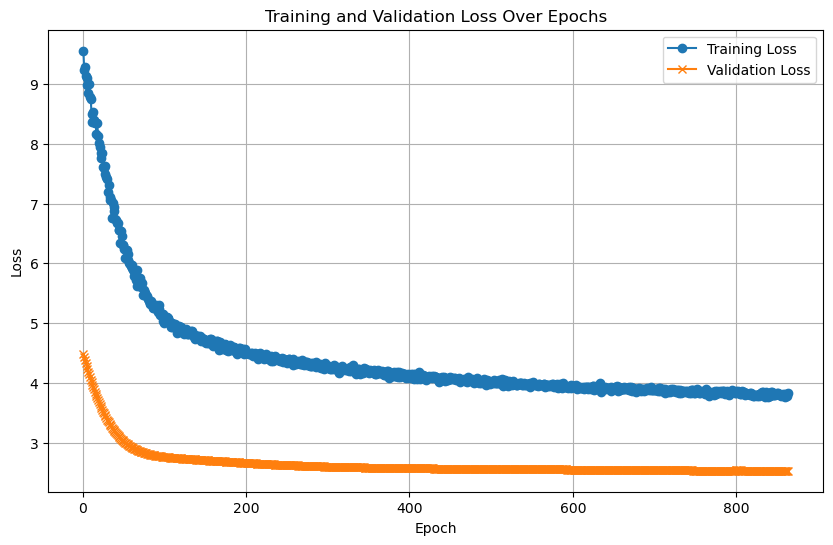

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 4.7546
Test Batch [20/167], Loss: 4.8335
Test Batch [30/167], Loss: 4.8447
Test Batch [40/167], Loss: 4.7971
Test Batch [50/167], Loss: 4.9554
Test Batch [60/167], Loss: 4.8555


Test Batch [70/167], Loss: 4.8392
Test Batch [80/167], Loss: 4.8442
Test Batch [90/167], Loss: 4.8473
Test Batch [100/167], Loss: 5.1598
Test Batch [110/167], Loss: 4.8368
Test Batch [120/167], Loss: 4.8667
Test Batch [130/167], Loss: 4.8229
Test Batch [140/167], Loss: 4.8691
Test Batch [150/167], Loss: 4.7616
Test Batch [160/167], Loss: 4.3395



Test Loss: 4.8374


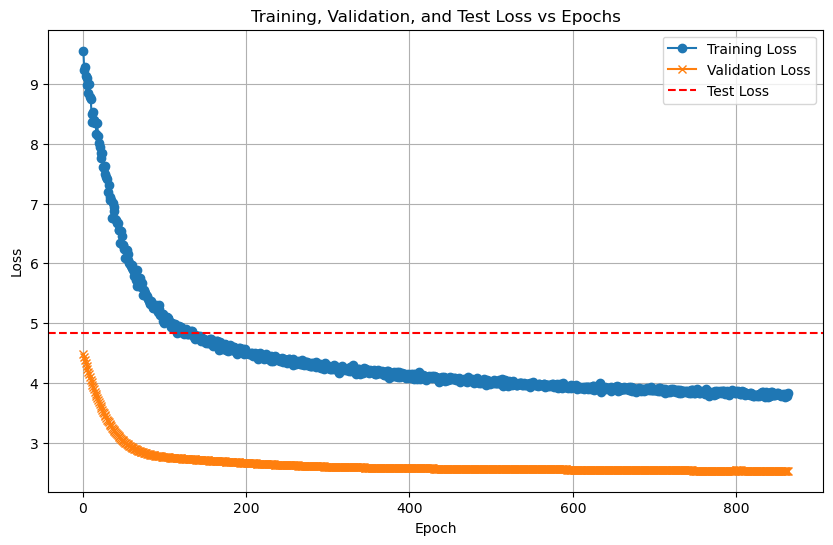

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.


  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.


  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.


  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 75.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.75      0.60      0.67         5
           2       0.67      0.40      0.50         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.50      0.80      0.62         5
           6       0.57      0.80      0.67         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.76        45
   macro avg       0.79      0.76      0.75        45
weighted avg       0.79      0.76      0.75        45


LOG: Evaluating on the test set...
Test Accuracy: 63.99%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6570  |  Val Loss: 2.6198
Validation loss improved from inf to 2.6198.


[Epoch 2/1000] Train Loss: 2.5965  |  Val Loss: 2.5623
Validation loss improved from 2.6198 to 2.5623.
[Epoch 3/1000] Train Loss: 2.5417  |  Val Loss: 2.5070
Validation loss improved from 2.5623 to 2.5070.
[Epoch 4/1000] Train Loss: 2.4820  |  Val Loss: 2.4560
Validation loss improved from 2.5070 to 2.4560.
[Epoch 5/1000] Train Loss: 2.4314  |  Val Loss: 2.4072
Validation loss improved from 2.4560 to 2.4072.
[Epoch 6/1000] Train Loss: 2.3888  |  Val Loss: 2.3599
Validation loss improved from 2.4072 to 2.3599.
[Epoch 7/1000] Train Loss: 2.3404  |  Val Loss: 2.3144
Validation loss improved from 2.3599 to 2.3144.
[Epoch 8/1000] Train Loss: 2.2940  |  Val Loss: 2.2713
Validation loss improved from 2.3144 to 2.2713.
[Epoch 9/1000] Train Loss: 2.2532  |  Val Loss: 2.2293
Validation loss improved from 2.2713 to 2.2293.
[Epoch 10/1000] Train Loss: 2.2139  |  Val Loss: 2.1900
Validation loss improved from 2.2293 to 2.1900.
[Epoch 11/1000] Train Loss: 2.1748  |  Val Loss: 2.1532
Validation loss 

[Epoch 27/1000] Train Loss: 1.7206  |  Val Loss: 1.7424
Validation loss improved from 1.7603 to 1.7424.
[Epoch 28/1000] Train Loss: 1.7019  |  Val Loss: 1.7252
Validation loss improved from 1.7424 to 1.7252.
[Epoch 29/1000] Train Loss: 1.6842  |  Val Loss: 1.7086
Validation loss improved from 1.7252 to 1.7086.
[Epoch 30/1000] Train Loss: 1.6667  |  Val Loss: 1.6924
Validation loss improved from 1.7086 to 1.6924.
[Epoch 31/1000] Train Loss: 1.6503  |  Val Loss: 1.6764
Validation loss improved from 1.6924 to 1.6764.
[Epoch 32/1000] Train Loss: 1.6339  |  Val Loss: 1.6605
Validation loss improved from 1.6764 to 1.6605.


[Epoch 33/1000] Train Loss: 1.6174  |  Val Loss: 1.6445
Validation loss improved from 1.6605 to 1.6445.
[Epoch 34/1000] Train Loss: 1.6016  |  Val Loss: 1.6285
Validation loss improved from 1.6445 to 1.6285.
[Epoch 35/1000] Train Loss: 1.5857  |  Val Loss: 1.6128
Validation loss improved from 1.6285 to 1.6128.
[Epoch 36/1000] Train Loss: 1.5695  |  Val Loss: 1.5975
Validation loss improved from 1.6128 to 1.5975.
[Epoch 37/1000] Train Loss: 1.5543  |  Val Loss: 1.5819
Validation loss improved from 1.5975 to 1.5819.
[Epoch 38/1000] Train Loss: 1.5388  |  Val Loss: 1.5663
Validation loss improved from 1.5819 to 1.5663.
[Epoch 39/1000] Train Loss: 1.5236  |  Val Loss: 1.5510
Validation loss improved from 1.5663 to 1.5510.
[Epoch 40/1000] Train Loss: 1.5087  |  Val Loss: 1.5362
Validation loss improved from 1.5510 to 1.5362.
[Epoch 41/1000] Train Loss: 1.4941  |  Val Loss: 1.5218
Validation loss improved from 1.5362 to 1.5218.
[Epoch 42/1000] Train Loss: 1.4799  |  Val Loss: 1.5074
Validati

[Epoch 59/1000] Train Loss: 1.2452  |  Val Loss: 1.2839
Validation loss improved from 1.2955 to 1.2839.
[Epoch 60/1000] Train Loss: 1.2327  |  Val Loss: 1.2723
Validation loss improved from 1.2839 to 1.2723.
[Epoch 61/1000] Train Loss: 1.2199  |  Val Loss: 1.2611
Validation loss improved from 1.2723 to 1.2611.
[Epoch 62/1000] Train Loss: 1.2075  |  Val Loss: 1.2499
Validation loss improved from 1.2611 to 1.2499.
[Epoch 63/1000] Train Loss: 1.1952  |  Val Loss: 1.2389
Validation loss improved from 1.2499 to 1.2389.
[Epoch 64/1000] Train Loss: 1.1830  |  Val Loss: 1.2279
Validation loss improved from 1.2389 to 1.2279.
[Epoch 65/1000] Train Loss: 1.1713  |  Val Loss: 1.2172
Validation loss improved from 1.2279 to 1.2172.
[Epoch 66/1000] Train Loss: 1.1593  |  Val Loss: 1.2070
Validation loss improved from 1.2172 to 1.2070.
[Epoch 67/1000] Train Loss: 1.1474  |  Val Loss: 1.1968
Validation loss improved from 1.2070 to 1.1968.


[Epoch 68/1000] Train Loss: 1.1358  |  Val Loss: 1.1868
Validation loss improved from 1.1968 to 1.1868.
[Epoch 69/1000] Train Loss: 1.1244  |  Val Loss: 1.1768
Validation loss improved from 1.1868 to 1.1768.
[Epoch 70/1000] Train Loss: 1.1132  |  Val Loss: 1.1671
Validation loss improved from 1.1768 to 1.1671.
[Epoch 71/1000] Train Loss: 1.1020  |  Val Loss: 1.1572
Validation loss improved from 1.1671 to 1.1572.
[Epoch 72/1000] Train Loss: 1.0905  |  Val Loss: 1.1481
Validation loss improved from 1.1572 to 1.1481.
[Epoch 73/1000] Train Loss: 1.0796  |  Val Loss: 1.1389
Validation loss improved from 1.1481 to 1.1389.
[Epoch 74/1000] Train Loss: 1.0687  |  Val Loss: 1.1297
Validation loss improved from 1.1389 to 1.1297.
[Epoch 75/1000] Train Loss: 1.0578  |  Val Loss: 1.1208
Validation loss improved from 1.1297 to 1.1208.
[Epoch 76/1000] Train Loss: 1.0471  |  Val Loss: 1.1116
Validation loss improved from 1.1208 to 1.1116.
[Epoch 77/1000] Train Loss: 1.0366  |  Val Loss: 1.1024
Validati

[Epoch 92/1000] Train Loss: 0.8883  |  Val Loss: 0.9747
Validation loss improved from 0.9824 to 0.9747.
[Epoch 93/1000] Train Loss: 0.8793  |  Val Loss: 0.9668
Validation loss improved from 0.9747 to 0.9668.
[Epoch 94/1000] Train Loss: 0.8706  |  Val Loss: 0.9592
Validation loss improved from 0.9668 to 0.9592.
[Epoch 95/1000] Train Loss: 0.8620  |  Val Loss: 0.9517
Validation loss improved from 0.9592 to 0.9517.
[Epoch 96/1000] Train Loss: 0.8529  |  Val Loss: 0.9447
Validation loss improved from 0.9517 to 0.9447.
[Epoch 97/1000] Train Loss: 0.8443  |  Val Loss: 0.9374
Validation loss improved from 0.9447 to 0.9374.
[Epoch 98/1000] Train Loss: 0.8362  |  Val Loss: 0.9301
Validation loss improved from 0.9374 to 0.9301.


[Epoch 99/1000] Train Loss: 0.8279  |  Val Loss: 0.9230
Validation loss improved from 0.9301 to 0.9230.
[Epoch 100/1000] Train Loss: 0.8197  |  Val Loss: 0.9156
Validation loss improved from 0.9230 to 0.9156.
[Epoch 101/1000] Train Loss: 0.8118  |  Val Loss: 0.9091
Validation loss improved from 0.9156 to 0.9091.
[Epoch 102/1000] Train Loss: 0.8037  |  Val Loss: 0.9023
Validation loss improved from 0.9091 to 0.9023.
[Epoch 103/1000] Train Loss: 0.7963  |  Val Loss: 0.8956
Validation loss improved from 0.9023 to 0.8956.
[Epoch 104/1000] Train Loss: 0.7885  |  Val Loss: 0.8890
Validation loss improved from 0.8956 to 0.8890.
[Epoch 105/1000] Train Loss: 0.7812  |  Val Loss: 0.8827
Validation loss improved from 0.8890 to 0.8827.
[Epoch 106/1000] Train Loss: 0.7738  |  Val Loss: 0.8767
Validation loss improved from 0.8827 to 0.8767.
[Epoch 107/1000] Train Loss: 0.7667  |  Val Loss: 0.8704
Validation loss improved from 0.8767 to 0.8704.
[Epoch 108/1000] Train Loss: 0.7597  |  Val Loss: 0.8644

[Epoch 120/1000] Train Loss: 0.6854  |  Val Loss: 0.8027
Validation loss improved from 0.8069 to 0.8027.
[Epoch 121/1000] Train Loss: 0.6799  |  Val Loss: 0.7978
Validation loss improved from 0.8027 to 0.7978.
[Epoch 122/1000] Train Loss: 0.6744  |  Val Loss: 0.7933
Validation loss improved from 0.7978 to 0.7933.
[Epoch 123/1000] Train Loss: 0.6693  |  Val Loss: 0.7890
Validation loss improved from 0.7933 to 0.7890.
[Epoch 124/1000] Train Loss: 0.6641  |  Val Loss: 0.7849
Validation loss improved from 0.7890 to 0.7849.
[Epoch 125/1000] Train Loss: 0.6590  |  Val Loss: 0.7809
Validation loss improved from 0.7849 to 0.7809.


[Epoch 126/1000] Train Loss: 0.6540  |  Val Loss: 0.7769
Validation loss improved from 0.7809 to 0.7769.
[Epoch 127/1000] Train Loss: 0.6491  |  Val Loss: 0.7730
Validation loss improved from 0.7769 to 0.7730.
[Epoch 128/1000] Train Loss: 0.6445  |  Val Loss: 0.7689
Validation loss improved from 0.7730 to 0.7689.
[Epoch 129/1000] Train Loss: 0.6399  |  Val Loss: 0.7657
Validation loss improved from 0.7689 to 0.7657.
[Epoch 130/1000] Train Loss: 0.6350  |  Val Loss: 0.7621
Validation loss improved from 0.7657 to 0.7621.
[Epoch 131/1000] Train Loss: 0.6307  |  Val Loss: 0.7584
Validation loss improved from 0.7621 to 0.7584.
[Epoch 132/1000] Train Loss: 0.6262  |  Val Loss: 0.7550
Validation loss improved from 0.7584 to 0.7550.
[Epoch 133/1000] Train Loss: 0.6220  |  Val Loss: 0.7515
Validation loss improved from 0.7550 to 0.7515.
[Epoch 134/1000] Train Loss: 0.6176  |  Val Loss: 0.7482
Validation loss improved from 0.7515 to 0.7482.
[Epoch 135/1000] Train Loss: 0.6136  |  Val Loss: 0.744

[Epoch 148/1000] Train Loss: 0.5669  |  Val Loss: 0.7088
Validation loss improved from 0.7109 to 0.7088.
[Epoch 149/1000] Train Loss: 0.5637  |  Val Loss: 0.7065
Validation loss improved from 0.7088 to 0.7065.
[Epoch 150/1000] Train Loss: 0.5608  |  Val Loss: 0.7042
Validation loss improved from 0.7065 to 0.7042.
[Epoch 151/1000] Train Loss: 0.5577  |  Val Loss: 0.7020
Validation loss improved from 0.7042 to 0.7020.
[Epoch 152/1000] Train Loss: 0.5547  |  Val Loss: 0.6997
Validation loss improved from 0.7020 to 0.6997.


[Epoch 153/1000] Train Loss: 0.5518  |  Val Loss: 0.6974
Validation loss improved from 0.6997 to 0.6974.
[Epoch 154/1000] Train Loss: 0.5491  |  Val Loss: 0.6952
Validation loss improved from 0.6974 to 0.6952.
[Epoch 155/1000] Train Loss: 0.5463  |  Val Loss: 0.6936
Validation loss improved from 0.6952 to 0.6936.
[Epoch 156/1000] Train Loss: 0.5435  |  Val Loss: 0.6914
Validation loss improved from 0.6936 to 0.6914.
[Epoch 157/1000] Train Loss: 0.5409  |  Val Loss: 0.6896
Validation loss improved from 0.6914 to 0.6896.
[Epoch 158/1000] Train Loss: 0.5383  |  Val Loss: 0.6874
Validation loss improved from 0.6896 to 0.6874.
[Epoch 159/1000] Train Loss: 0.5357  |  Val Loss: 0.6852
Validation loss improved from 0.6874 to 0.6852.
[Epoch 160/1000] Train Loss: 0.5334  |  Val Loss: 0.6836
Validation loss improved from 0.6852 to 0.6836.
[Epoch 161/1000] Train Loss: 0.5308  |  Val Loss: 0.6814
Validation loss improved from 0.6836 to 0.6814.
[Epoch 162/1000] Train Loss: 0.5283  |  Val Loss: 0.679

[Epoch 180/1000] Train Loss: 0.4913  |  Val Loss: 0.6531
Validation loss improved from 0.6546 to 0.6531.
[Epoch 181/1000] Train Loss: 0.4895  |  Val Loss: 0.6517
Validation loss improved from 0.6531 to 0.6517.
[Epoch 182/1000] Train Loss: 0.4879  |  Val Loss: 0.6505
Validation loss improved from 0.6517 to 0.6505.
[Epoch 183/1000] Train Loss: 0.4863  |  Val Loss: 0.6493
Validation loss improved from 0.6505 to 0.6493.
[Epoch 184/1000] Train Loss: 0.4845  |  Val Loss: 0.6480
Validation loss improved from 0.6493 to 0.6480.
[Epoch 185/1000] Train Loss: 0.4831  |  Val Loss: 0.6470
Validation loss improved from 0.6480 to 0.6470.
[Epoch 186/1000] Train Loss: 0.4813  |  Val Loss: 0.6458
Validation loss improved from 0.6470 to 0.6458.
[Epoch 187/1000] Train Loss: 0.4797  |  Val Loss: 0.6444
Validation loss improved from 0.6458 to 0.6444.
[Epoch 188/1000] Train Loss: 0.4782  |  Val Loss: 0.6434
Validation loss improved from 0.6444 to 0.6434.
[Epoch 189/1000] Train Loss: 0.4766  |  Val Loss: 0.642

[Epoch 214/1000] Train Loss: 0.4442  |  Val Loss: 0.6205
Validation loss improved from 0.6211 to 0.6205.
[Epoch 215/1000] Train Loss: 0.4429  |  Val Loss: 0.6197
Validation loss improved from 0.6205 to 0.6197.
[Epoch 216/1000] Train Loss: 0.4419  |  Val Loss: 0.6192
Validation loss improved from 0.6197 to 0.6192.
[Epoch 217/1000] Train Loss: 0.4410  |  Val Loss: 0.6188
Validation loss improved from 0.6192 to 0.6188.
[Epoch 218/1000] Train Loss: 0.4399  |  Val Loss: 0.6182
Validation loss improved from 0.6188 to 0.6182.
[Epoch 219/1000] Train Loss: 0.4388  |  Val Loss: 0.6173
Validation loss improved from 0.6182 to 0.6173.
[Epoch 220/1000] Train Loss: 0.4378  |  Val Loss: 0.6169
Validation loss improved from 0.6173 to 0.6169.
[Epoch 221/1000] Train Loss: 0.4367  |  Val Loss: 0.6158
Validation loss improved from 0.6169 to 0.6158.
[Epoch 222/1000] Train Loss: 0.4358  |  Val Loss: 0.6148
Validation loss improved from 0.6158 to 0.6148.
[Epoch 223/1000] Train Loss: 0.4348  |  Val Loss: 0.614

[Epoch 245/1000] Train Loss: 0.4153  |  Val Loss: 0.6046
Validation loss improved from 0.6051 to 0.6046.
[Epoch 246/1000] Train Loss: 0.4145  |  Val Loss: 0.6040
Validation loss improved from 0.6046 to 0.6040.
[Epoch 247/1000] Train Loss: 0.4140  |  Val Loss: 0.6032
Validation loss improved from 0.6040 to 0.6032.
[Epoch 248/1000] Train Loss: 0.4127  |  Val Loss: 0.6028
Validation loss improved from 0.6032 to 0.6028.
[Epoch 249/1000] Train Loss: 0.4122  |  Val Loss: 0.6028
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 250/1000] Train Loss: 0.4114  |  Val Loss: 0.6021
Validation loss improved from 0.6028 to 0.6021.
[Epoch 251/1000] Train Loss: 0.4107  |  Val Loss: 0.6022
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.4100  |  Val Loss: 0.6013
Validation loss improved from 0.6021 to 0.6013.
[Epoch 253/1000] Train Loss: 0.4093  |  Val Loss: 0.6006
Validation loss improved from 0.6013 to 0.6006.
[Epoch 254/1000] Train Loss: 0.4083  |  Val

[Epoch 277/1000] Train Loss: 0.3934  |  Val Loss: 0.5924
Validation loss improved from 0.5925 to 0.5924.
[Epoch 278/1000] Train Loss: 0.3924  |  Val Loss: 0.5919
Validation loss improved from 0.5924 to 0.5919.
[Epoch 279/1000] Train Loss: 0.3917  |  Val Loss: 0.5920
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 280/1000] Train Loss: 0.3912  |  Val Loss: 0.5925
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 281/1000] Train Loss: 0.3909  |  Val Loss: 0.5924
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 282/1000] Train Loss: 0.3902  |  Val Loss: 0.5921
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 283/1000] Train Loss: 0.3895  |  Val Loss: 0.5921
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 284/1000] Train Loss: 0.3890  |  Val Loss: 0.5922
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 285/1000] Train Loss: 0.3885  |  Val Loss: 0.5919
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 286/10

[Epoch 307/1000] Train Loss: 0.3770  |  Val Loss: 0.5866
Validation loss improved from 0.5869 to 0.5866.
[Epoch 308/1000] Train Loss: 0.3764  |  Val Loss: 0.5862
Validation loss improved from 0.5866 to 0.5862.
[Epoch 309/1000] Train Loss: 0.3756  |  Val Loss: 0.5863
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 310/1000] Train Loss: 0.3752  |  Val Loss: 0.5866
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 311/1000] Train Loss: 0.3749  |  Val Loss: 0.5864
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 312/1000] Train Loss: 0.3740  |  Val Loss: 0.5867
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 313/1000] Train Loss: 0.3737  |  Val Loss: 0.5868
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 314/1000] Train Loss: 0.3734  |  Val Loss: 0.5868
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 315/1000] Train Loss: 0.3731  |  Val Loss: 0.5859
Validation loss improved from 0.5862 to 0.5859.
[Epoch 316/1000] Tr

[Epoch 341/1000] Train Loss: 0.3610  |  Val Loss: 0.5819
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 342/1000] Train Loss: 0.3607  |  Val Loss: 0.5822
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 343/1000] Train Loss: 0.3602  |  Val Loss: 0.5822
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 344/1000] Train Loss: 0.3599  |  Val Loss: 0.5822
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 345/1000] Train Loss: 0.3596  |  Val Loss: 0.5820
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 346/1000] Train Loss: 0.3595  |  Val Loss: 0.5822
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 347/1000] Train Loss: 0.3589  |  Val Loss: 0.5815
Validation loss improved from 0.5817 to 0.5815.
[Epoch 348/1000] Train Loss: 0.3585  |  Val Loss: 0.5812
Validation loss improved from 0.5815 to 0.5812.
[Epoch 349/1000] Train Loss: 0.3582  |  Val Loss: 0.5807
Validation loss improved from 0.5812 to 0.5807.
[Epoch 350/1000] Tr

[Epoch 375/1000] Train Loss: 0.3477  |  Val Loss: 0.5785
Validation loss improved from 0.5786 to 0.5785.
[Epoch 376/1000] Train Loss: 0.3475  |  Val Loss: 0.5778
Validation loss improved from 0.5785 to 0.5778.
[Epoch 377/1000] Train Loss: 0.3470  |  Val Loss: 0.5781
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 378/1000] Train Loss: 0.3466  |  Val Loss: 0.5778
Validation loss improved from 0.5778 to 0.5778.
[Epoch 379/1000] Train Loss: 0.3462  |  Val Loss: 0.5780
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 380/1000] Train Loss: 0.3462  |  Val Loss: 0.5781
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 381/1000] Train Loss: 0.3455  |  Val Loss: 0.5776
Validation loss improved from 0.5778 to 0.5776.
[Epoch 382/1000] Train Loss: 0.3452  |  Val Loss: 0.5771
Validation loss improved from 0.5776 to 0.5771.
[Epoch 383/1000] Train Loss: 0.3449  |  Val Loss: 0.5772
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 384/1000] Train Loss: 0.

[Epoch 405/1000] Train Loss: 0.3372  |  Val Loss: 0.5774
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 406/1000] Train Loss: 0.3369  |  Val Loss: 0.5772
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 407/1000] Train Loss: 0.3366  |  Val Loss: 0.5773
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 408/1000] Train Loss: 0.3360  |  Val Loss: 0.5772
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 409/1000] Train Loss: 0.3358  |  Val Loss: 0.5771
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 410/1000] Train Loss: 0.3353  |  Val Loss: 0.5768
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 411/1000] Train Loss: 0.3349  |  Val Loss: 0.5765
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 412/1000] Train Loss: 0.3348  |  Val Loss: 0.5762
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 413/1000] Train Loss: 0.3345  |  Val Loss: 0.5759
!! Validation loss did NOT improve !! Patience: 1

[Epoch 435/1000] Train Loss: 0.3270  |  Val Loss: 0.5766
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 436/1000] Train Loss: 0.3269  |  Val Loss: 0.5763
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 437/1000] Train Loss: 0.3262  |  Val Loss: 0.5764
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 438/1000] Train Loss: 0.3259  |  Val Loss: 0.5761
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 439/1000] Train Loss: 0.3257  |  Val Loss: 0.5755
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 440/1000] Train Loss: 0.3255  |  Val Loss: 0.5756
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 441/1000] Train Loss: 0.3250  |  Val Loss: 0.5758
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 442/1000] Train Loss: 0.3244  |  Val Loss: 0.5764
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 443/1000] Train Loss: 0.3243  |  Val Loss: 0.5771
!! Validation loss did NOT improve !! Patience:

[Epoch 469/1000] Train Loss: 0.3159  |  Val Loss: 0.5766
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 470/1000] Train Loss: 0.3156  |  Val Loss: 0.5764
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 471/1000] Train Loss: 0.3153  |  Val Loss: 0.5775
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 472/1000] Train Loss: 0.3150  |  Val Loss: 0.5772
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 473/1000] Train Loss: 0.3147  |  Val Loss: 0.5772
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 474/1000] Train Loss: 0.3145  |  Val Loss: 0.5773
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 475/1000] Train Loss: 0.3140  |  Val Loss: 0.5772
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 476/1000] Train Loss: 0.3136  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 477/1000] Train Loss: 0.3135  |  Val Loss: 0.5765
!! Validation loss did NOT improve !! Patience:

[Epoch 502/1000] Train Loss: 0.3056  |  Val Loss: 0.5751
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 503/1000] Train Loss: 0.3054  |  Val Loss: 0.5754
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 504/1000] Train Loss: 0.3051  |  Val Loss: 0.5756
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 505/1000] Train Loss: 0.3053  |  Val Loss: 0.5752
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 506/1000] Train Loss: 0.3047  |  Val Loss: 0.5748
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 507/1000] Train Loss: 0.3046  |  Val Loss: 0.5754
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 508/1000] Train Loss: 0.3041  |  Val Loss: 0.5748
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 509/1000] Train Loss: 0.3039  |  Val Loss: 0.5751
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 510/1000] Train Loss: 0.3035  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience:

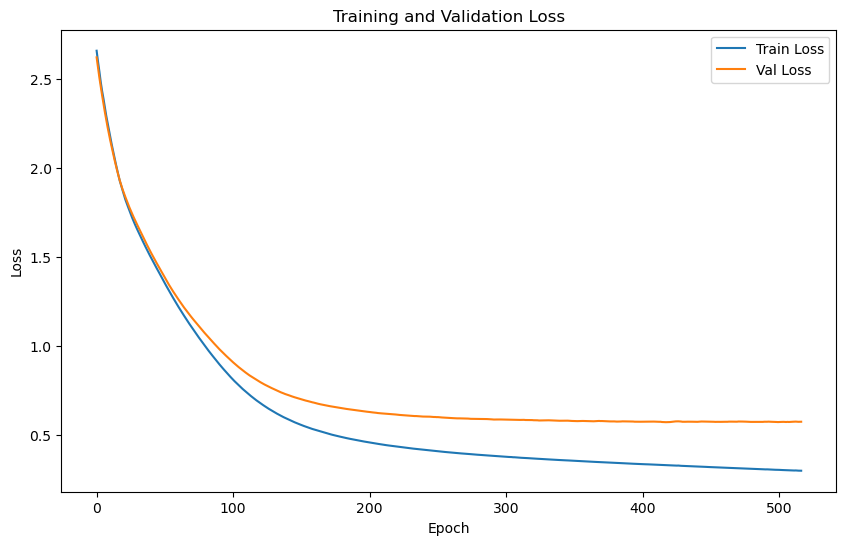

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.0081 | Test Accuracy: 59.54%


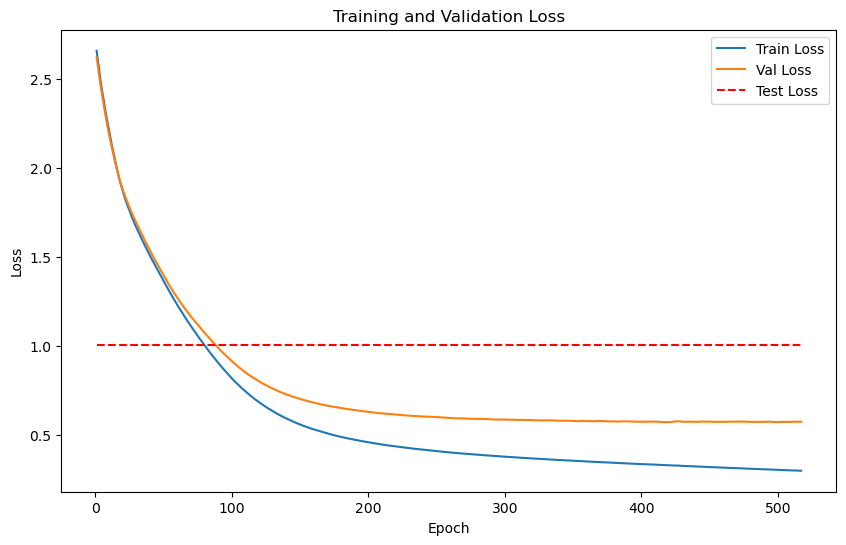

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4492
Epoch [1/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4492

Validation loss improved from inf to 0.4492. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4475
Epoch [2/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.4475

Validation loss improved from 0.4492 to 0.4475. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4455
Epoch [3/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4455

Validation loss improved from 0.4475 to 0.4455. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4432
Epoch [4/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4432

Validation loss improved from 0.4455 to 0.4432. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4411
Epoch [5/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4411

Validation loss improved from 0.4432 to 0.4411. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4394
Epoch [6/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4394

Validation loss improved from 0.4411 to 0.4394. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.4373
Epoch [7/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4373

Validation loss improved from 0.4394 to 0.4373. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [8/2000] - Validation


    Batch [1/1], Val Loss: 0.4350
Epoch [8/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.4350

Validation loss improved from 0.4373 to 0.4350. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4331
Epoch [9/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4331

Validation loss improved from 0.4350 to 0.4331. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [10/2000] - Validation


    Batch [1/1], Val Loss: 0.4316
Epoch [10/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4316

Validation loss improved from 0.4331 to 0.4316. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4298
Epoch [11/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4298

Validation loss improved from 0.4316 to 0.4298. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4280
Epoch [12/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4280

Validation loss improved from 0.4298 to 0.4280. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4265
Epoch [13/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4265

Validation loss improved from 0.4280 to 0.4265. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4257
Epoch [14/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4257

Validation loss improved from 0.4265 to 0.4257. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4252
Epoch [15/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4252

Validation loss improved from 0.4257 to 0.4252. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4246
Epoch [16/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4246

Validation loss improved from 0.4252 to 0.4246. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4238
Epoch [17/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4238

Validation loss improved from 0.4246 to 0.4238. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4230
Epoch [18/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4230

Validation loss improved from 0.4238 to 0.4230. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4223
Epoch [19/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4223

Validation loss improved from 0.4230 to 0.4223. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4214
Epoch [20/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4214

Validation loss improved from 0.4223 to 0.4214. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4206
Epoch [21/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4206

Validation loss improved from 0.4214 to 0.4206. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.4199
Epoch [22/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4199

Validation loss improved from 0.4206 to 0.4199. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4191
Epoch [23/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4191

Validation loss improved from 0.4199 to 0.4191. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4183
Epoch [24/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4183

Validation loss improved from 0.4191 to 0.4183. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4175
Epoch [25/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.4175

Validation loss improved from 0.4183 to 0.4175. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4168
Epoch [26/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4168

Validation loss improved from 0.4175 to 0.4168. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4162
Epoch [27/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4162

Validation loss improved from 0.4168 to 0.4162. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [28/2000] - Validation


    Batch [1/1], Val Loss: 0.4154
Epoch [28/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.4154

Validation loss improved from 0.4162 to 0.4154. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4147
Epoch [29/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.4147

Validation loss improved from 0.4154 to 0.4147. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4140
Epoch [30/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.4140

Validation loss improved from 0.4147 to 0.4140. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4133
Epoch [31/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.4133

Validation loss improved from 0.4140 to 0.4133. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4127
Epoch [32/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.4127

Validation loss improved from 0.4133 to 0.4127. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4120
Epoch [33/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.4120

Validation loss improved from 0.4127 to 0.4120. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4113
Epoch [34/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.4113

Validation loss improved from 0.4120 to 0.4113. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [35/2000] - Validation


    Batch [1/1], Val Loss: 0.4107
Epoch [35/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.4107

Validation loss improved from 0.4113 to 0.4107. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4100
Epoch [36/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.4100

Validation loss improved from 0.4107 to 0.4100. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.4094
Epoch [37/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.4094

Validation loss improved from 0.4100 to 0.4094. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4087
Epoch [38/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4087

Validation loss improved from 0.4094 to 0.4087. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4081
Epoch [39/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.4081

Validation loss improved from 0.4087 to 0.4081. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4075
Epoch [40/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.4075

Validation loss improved from 0.4081 to 0.4075. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4069
Epoch [41/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.4069

Validation loss improved from 0.4075 to 0.4069. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [42/2000] - Validation


    Batch [1/1], Val Loss: 0.4064
Epoch [42/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.4064

Validation loss improved from 0.4069 to 0.4064. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4059
Epoch [43/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.4059

Validation loss improved from 0.4064 to 0.4059. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.4054
Epoch [44/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.4054

Validation loss improved from 0.4059 to 0.4054. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.4049
Epoch [45/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.4049

Validation loss improved from 0.4054 to 0.4049. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4043
Epoch [46/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.4043

Validation loss improved from 0.4049 to 0.4043. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4038
Epoch [47/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.4038

Validation loss improved from 0.4043 to 0.4038. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [48/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4033

Validation loss improved from 0.4038 to 0.4033. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.4027
Epoch [49/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.4027

Validation loss improved from 0.4033 to 0.4027. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.4022
Epoch [50/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.4022

Validation loss improved from 0.4027 to 0.4022. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [51/2000] - Validation


    Batch [1/1], Val Loss: 0.4016
Epoch [51/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.4016

Validation loss improved from 0.4022 to 0.4016. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4011
Epoch [52/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.4011

Validation loss improved from 0.4016 to 0.4011. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4005
Epoch [53/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.4005

Validation loss improved from 0.4011 to 0.4005. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4000
Epoch [54/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.4000

Validation loss improved from 0.4005 to 0.4000. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3995
Epoch [55/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3995

Validation loss improved from 0.4000 to 0.3995. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.3990
Epoch [56/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3990

Validation loss improved from 0.3995 to 0.3990. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3986
Epoch [57/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3986

Validation loss improved from 0.3990 to 0.3986. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3981
Epoch [58/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.3981

Validation loss improved from 0.3986 to 0.3981. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3976
Epoch [59/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.3976

Validation loss improved from 0.3981 to 0.3976. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3972
Epoch [60/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.3972

Validation loss improved from 0.3976 to 0.3972. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3967
Epoch [61/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.3967

Validation loss improved from 0.3972 to 0.3967. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3963
Epoch [62/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.3963

Validation loss improved from 0.3967 to 0.3963. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3959
Epoch [63/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.3959

Validation loss improved from 0.3963 to 0.3959. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3955
Epoch [64/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3955

Validation loss improved from 0.3959 to 0.3955. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [65/2000] - Validation


    Batch [1/1], Val Loss: 0.3950
Epoch [65/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3950

Validation loss improved from 0.3955 to 0.3950. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3947
Epoch [66/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3947

Validation loss improved from 0.3950 to 0.3947. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [67/2000] - Validation


    Batch [1/1], Val Loss: 0.3943
Epoch [67/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3943

Validation loss improved from 0.3947 to 0.3943. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3940
Epoch [68/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.3940

Validation loss improved from 0.3943 to 0.3940. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [69/2000] - Validation


    Batch [1/1], Val Loss: 0.3936
Epoch [69/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.3936

Validation loss improved from 0.3940 to 0.3936. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3932
Epoch [70/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3932

Validation loss improved from 0.3936 to 0.3932. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3929
Epoch [71/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.3929

Validation loss improved from 0.3932 to 0.3929. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [72/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.3925

Validation loss improved from 0.3929 to 0.3925. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3922
Epoch [73/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.3922

Validation loss improved from 0.3925 to 0.3922. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [74/2000] - Validation


    Batch [1/1], Val Loss: 0.3918
Epoch [74/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3918

Validation loss improved from 0.3922 to 0.3918. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [75/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3915

Validation loss improved from 0.3918 to 0.3915. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [76/2000] - Validation


    Batch [1/1], Val Loss: 0.3911
Epoch [76/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.3911

Validation loss improved from 0.3915 to 0.3911. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3908
Epoch [77/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.3908

Validation loss improved from 0.3911 to 0.3908. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [78/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3905

Validation loss improved from 0.3908 to 0.3905. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3902
Epoch [79/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.3902

Validation loss improved from 0.3905 to 0.3902. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3899
Epoch [80/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.3899

Validation loss improved from 0.3902 to 0.3899. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [81/2000] - Validation


    Batch [1/1], Val Loss: 0.3896
Epoch [81/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.3896

Validation loss improved from 0.3899 to 0.3896. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3893
Epoch [82/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.3893

Validation loss improved from 0.3896 to 0.3893. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [83/2000] - Validation


    Batch [1/1], Val Loss: 0.3890
Epoch [83/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3890

Validation loss improved from 0.3893 to 0.3890. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [84/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3888

Validation loss improved from 0.3890 to 0.3888. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3885
Epoch [85/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3885

Validation loss improved from 0.3888 to 0.3885. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [86/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.3883

Validation loss improved from 0.3885 to 0.3883. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3880
Epoch [87/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3880

Validation loss improved from 0.3883 to 0.3880. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [88/2000] - Validation


    Batch [1/1], Val Loss: 0.3877
Epoch [88/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.3877

Validation loss improved from 0.3880 to 0.3877. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3874
Epoch [89/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.3874

Validation loss improved from 0.3877 to 0.3874. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [90/2000] - Validation


    Batch [1/1], Val Loss: 0.3871
Epoch [90/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3871

Validation loss improved from 0.3874 to 0.3871. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3868
Epoch [91/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3868

Validation loss improved from 0.3871 to 0.3868. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [92/2000] - Validation


    Batch [1/1], Val Loss: 0.3864
Epoch [92/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3864

Validation loss improved from 0.3868 to 0.3864. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3861
Epoch [93/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3861

Validation loss improved from 0.3864 to 0.3861. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [94/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3858

Validation loss improved from 0.3861 to 0.3858. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3854
Epoch [95/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3854

Validation loss improved from 0.3858 to 0.3854. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [96/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3850

Validation loss improved from 0.3854 to 0.3850. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.3847
Epoch [97/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3847

Validation loss improved from 0.3850 to 0.3847. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3844
Epoch [98/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3844

Validation loss improved from 0.3847 to 0.3844. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [99/2000] - Validation


    Batch [1/1], Val Loss: 0.3841
Epoch [99/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3841

Validation loss improved from 0.3844 to 0.3841. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3839
Epoch [100/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3839

Validation loss improved from 0.3841 to 0.3839. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [101/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3836

Validation loss improved from 0.3839 to 0.3836. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3833
Epoch [102/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3833

Validation loss improved from 0.3836 to 0.3833. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3830
Epoch [103/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3830

Validation loss improved from 0.3833 to 0.3830. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3828
Epoch [104/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3828

Validation loss improved from 0.3830 to 0.3828. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3825
Epoch [105/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3825

Validation loss improved from 0.3828 to 0.3825. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [106/2000] - Validation


    Batch [1/1], Val Loss: 0.3822
Epoch [106/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3822

Validation loss improved from 0.3825 to 0.3822. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3820
Epoch [107/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3820

Validation loss improved from 0.3822 to 0.3820. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.3818
Epoch [108/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3818

Validation loss improved from 0.3820 to 0.3818. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3815
Epoch [109/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3815

Validation loss improved from 0.3818 to 0.3815. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [110/2000] - Validation


    Batch [1/1], Val Loss: 0.3813
Epoch [110/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3813

Validation loss improved from 0.3815 to 0.3813. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3812
Epoch [111/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3812

Validation loss improved from 0.3813 to 0.3812. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3809
Epoch [112/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3809

Validation loss improved from 0.3812 to 0.3809. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3807
Epoch [113/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3807

Validation loss improved from 0.3809 to 0.3807. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3805
Epoch [114/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3805

Validation loss improved from 0.3807 to 0.3805. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [115/2000] - Validation


    Batch [1/1], Val Loss: 0.3803
Epoch [115/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3803

Validation loss improved from 0.3805 to 0.3803. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3801
Epoch [116/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3801

Validation loss improved from 0.3803 to 0.3801. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3799
Epoch [117/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3799

Validation loss improved from 0.3801 to 0.3799. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [118/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3797

Validation loss improved from 0.3799 to 0.3797. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3795
Epoch [119/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3795

Validation loss improved from 0.3797 to 0.3795. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [120/2000] - Validation


    Batch [1/1], Val Loss: 0.3793
Epoch [120/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3793

Validation loss improved from 0.3795 to 0.3793. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3790
Epoch [121/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3790

Validation loss improved from 0.3793 to 0.3790. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3788
Epoch [122/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3788

Validation loss improved from 0.3790 to 0.3788. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3786
Epoch [123/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3786

Validation loss improved from 0.3788 to 0.3786. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [124/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3783

Validation loss improved from 0.3786 to 0.3783. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [125/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.3780

Validation loss improved from 0.3783 to 0.3780. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3778
Epoch [126/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3778

Validation loss improved from 0.3780 to 0.3778. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [127/2000] - Validation


    Batch [1/1], Val Loss: 0.3776
Epoch [127/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3776

Validation loss improved from 0.3778 to 0.3776. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [128/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3773

Validation loss improved from 0.3776 to 0.3773. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [129/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3771

Validation loss improved from 0.3773 to 0.3771. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [130/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3768

Validation loss improved from 0.3771 to 0.3768. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [131/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3766

Validation loss improved from 0.3768 to 0.3766. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [132/2000] - Validation


    Batch [1/1], Val Loss: 0.3764
Epoch [132/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3764

Validation loss improved from 0.3766 to 0.3764. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [133/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.3762

Validation loss improved from 0.3764 to 0.3762. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3760
Epoch [134/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.3760

Validation loss improved from 0.3762 to 0.3760. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [135/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3757

Validation loss improved from 0.3760 to 0.3757. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3754
Epoch [136/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3754

Validation loss improved from 0.3757 to 0.3754. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [137/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3751

Validation loss improved from 0.3754 to 0.3751. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [138/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3749

Validation loss improved from 0.3751 to 0.3749. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.3746
Epoch [139/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3746

Validation loss improved from 0.3749 to 0.3746. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [140/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3743

Validation loss improved from 0.3746 to 0.3743. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [141/2000] - Validation


    Batch [1/1], Val Loss: 0.3740
Epoch [141/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.3740

Validation loss improved from 0.3743 to 0.3740. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [142/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3737

Validation loss improved from 0.3740 to 0.3737. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [143/2000] - Validation


    Batch [1/1], Val Loss: 0.3733
Epoch [143/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.3733

Validation loss improved from 0.3737 to 0.3733. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3730
Epoch [144/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.3730

Validation loss improved from 0.3733 to 0.3730. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3726
Epoch [145/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.3726

Validation loss improved from 0.3730 to 0.3726. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3722
Epoch [146/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.3722

Validation loss improved from 0.3726 to 0.3722. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [147/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.3719

Validation loss improved from 0.3722 to 0.3719. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [148/2000] - Validation


    Batch [1/1], Val Loss: 0.3716
Epoch [148/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.3716

Validation loss improved from 0.3719 to 0.3716. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3713
Epoch [149/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.3713

Validation loss improved from 0.3716 to 0.3713. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.3711
Epoch [150/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.3711

Validation loss improved from 0.3713 to 0.3711. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [151/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.3708

Validation loss improved from 0.3711 to 0.3708. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3705
Epoch [152/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3705

Validation loss improved from 0.3708 to 0.3705. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [153/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3702

Validation loss improved from 0.3705 to 0.3702. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3698
Epoch [154/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.3698

Validation loss improved from 0.3702 to 0.3698. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.3695
Epoch [155/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.3695

Validation loss improved from 0.3698 to 0.3695. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3693
Epoch [156/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.3693

Validation loss improved from 0.3695 to 0.3693. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [157/2000] - Validation


    Batch [1/1], Val Loss: 0.3690
Epoch [157/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3690

Validation loss improved from 0.3693 to 0.3690. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3688
Epoch [158/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.3688

Validation loss improved from 0.3690 to 0.3688. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3685
Epoch [159/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3685

Validation loss improved from 0.3688 to 0.3685. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3683
Epoch [160/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3683

Validation loss improved from 0.3685 to 0.3683. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [161/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3681

Validation loss improved from 0.3683 to 0.3681. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [162/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.3679

Validation loss improved from 0.3681 to 0.3679. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [163/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3677

Validation loss improved from 0.3679 to 0.3677. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [164/2000] - Validation


    Batch [1/1], Val Loss: 0.3675
Epoch [164/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3675

Validation loss improved from 0.3677 to 0.3675. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3672
Epoch [165/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.3672

Validation loss improved from 0.3675 to 0.3672. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [166/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3669

Validation loss improved from 0.3672 to 0.3669. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3666
Epoch [167/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3666

Validation loss improved from 0.3669 to 0.3666. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [168/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3663

Validation loss improved from 0.3666 to 0.3663. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.3660
Epoch [169/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3660

Validation loss improved from 0.3663 to 0.3660. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3657
Epoch [170/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3657

Validation loss improved from 0.3660 to 0.3657. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3654
Epoch [171/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3654

Validation loss improved from 0.3657 to 0.3654. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [172/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3652

Validation loss improved from 0.3654 to 0.3652. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [173/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3649

Validation loss improved from 0.3652 to 0.3649. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [174/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3647

Validation loss improved from 0.3649 to 0.3647. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3644
Epoch [175/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3644

Validation loss improved from 0.3647 to 0.3644. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [176/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3642

Validation loss improved from 0.3644 to 0.3642. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3640
Epoch [177/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3640

Validation loss improved from 0.3642 to 0.3640. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [178/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.3637

Validation loss improved from 0.3640 to 0.3637. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [179/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.3635

Validation loss improved from 0.3637 to 0.3635. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3632
Epoch [180/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3632

Validation loss improved from 0.3635 to 0.3632. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3628
Epoch [181/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3628

Validation loss improved from 0.3632 to 0.3628. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [182/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3625

Validation loss improved from 0.3628 to 0.3625. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3622
Epoch [183/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.3622

Validation loss improved from 0.3625 to 0.3622. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [184/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.3619

Validation loss improved from 0.3622 to 0.3619. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [185/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.3616

Validation loss improved from 0.3619 to 0.3616. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [186/2000] - Validation


    Batch [1/1], Val Loss: 0.3612
Epoch [186/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3612

Validation loss improved from 0.3616 to 0.3612. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [187/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3609

Validation loss improved from 0.3612 to 0.3609. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [188/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.3606

Validation loss improved from 0.3609 to 0.3606. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [189/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3603

Validation loss improved from 0.3606 to 0.3603. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3601
Epoch [190/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3601

Validation loss improved from 0.3603 to 0.3601. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [191/2000] - Validation


    Batch [1/1], Val Loss: 0.3599
Epoch [191/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.3599

Validation loss improved from 0.3601 to 0.3599. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3597
Epoch [192/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3597

Validation loss improved from 0.3599 to 0.3597. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [193/2000] - Validation


    Batch [1/1], Val Loss: 0.3595
Epoch [193/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3595

Validation loss improved from 0.3597 to 0.3595. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3593
Epoch [194/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.3593

Validation loss improved from 0.3595 to 0.3593. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.3590
Epoch [195/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3590

Validation loss improved from 0.3593 to 0.3590. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3588
Epoch [196/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3588

Validation loss improved from 0.3590 to 0.3588. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [197/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.3586

Validation loss improved from 0.3588 to 0.3586. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [198/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3584

Validation loss improved from 0.3586 to 0.3584. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [199/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.3581

Validation loss improved from 0.3584 to 0.3581. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [200/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.3579

Validation loss improved from 0.3581 to 0.3579. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3576
Epoch [201/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3576

Validation loss improved from 0.3579 to 0.3576. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3574
Epoch [202/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.3574

Validation loss improved from 0.3576 to 0.3574. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [203/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3572

Validation loss improved from 0.3574 to 0.3572. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [204/2000] - Validation


    Batch [1/1], Val Loss: 0.3570
Epoch [204/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.3570

Validation loss improved from 0.3572 to 0.3570. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [205/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3568

Validation loss improved from 0.3570 to 0.3568. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.3565
Epoch [206/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3565

Validation loss improved from 0.3568 to 0.3565. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [207/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.3563

Validation loss improved from 0.3565 to 0.3563. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [208/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.3561

Validation loss improved from 0.3563 to 0.3561. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [209/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.3558

Validation loss improved from 0.3561 to 0.3558. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [210/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.3556

Validation loss improved from 0.3558 to 0.3556. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [211/2000] - Validation


    Batch [1/1], Val Loss: 0.3553
Epoch [211/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3553

Validation loss improved from 0.3556 to 0.3553. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [212/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.3549

Validation loss improved from 0.3553 to 0.3549. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.3547
Epoch [213/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3547

Validation loss improved from 0.3549 to 0.3547. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3544
Epoch [214/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.3544

Validation loss improved from 0.3547 to 0.3544. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3541
Epoch [215/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3541

Validation loss improved from 0.3544 to 0.3541. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3538
Epoch [216/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.3538

Validation loss improved from 0.3541 to 0.3538. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [217/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.3536

Validation loss improved from 0.3538 to 0.3536. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [218/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3532

Validation loss improved from 0.3536 to 0.3532. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3529
Epoch [219/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3529

Validation loss improved from 0.3532 to 0.3529. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [220/2000] - Validation


    Batch [1/1], Val Loss: 0.3525
Epoch [220/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3525

Validation loss improved from 0.3529 to 0.3525. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [221/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.3521

Validation loss improved from 0.3525 to 0.3521. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [222/2000] - Validation


    Batch [1/1], Val Loss: 0.3518
Epoch [222/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.3518

Validation loss improved from 0.3521 to 0.3518. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [223/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.3515

Validation loss improved from 0.3518 to 0.3515. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [224/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.3512

Validation loss improved from 0.3515 to 0.3512. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3509
Epoch [225/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.3509

Validation loss improved from 0.3512 to 0.3509. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [226/2000] - Validation


    Batch [1/1], Val Loss: 0.3506
Epoch [226/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3506

Validation loss improved from 0.3509 to 0.3506. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [227/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.3502

Validation loss improved from 0.3506 to 0.3502. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.3498
Epoch [228/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.3498

Validation loss improved from 0.3502 to 0.3498. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3495
Epoch [229/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.3495

Validation loss improved from 0.3498 to 0.3495. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [230/2000] - Validation


    Batch [1/1], Val Loss: 0.3492
Epoch [230/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3492

Validation loss improved from 0.3495 to 0.3492. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [231/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3489

Validation loss improved from 0.3492 to 0.3489. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [232/2000] - Validation


    Batch [1/1], Val Loss: 0.3486
Epoch [232/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3486

Validation loss improved from 0.3489 to 0.3486. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3483
Epoch [233/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.3483

Validation loss improved from 0.3486 to 0.3483. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3480
Epoch [234/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.3480

Validation loss improved from 0.3483 to 0.3480. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [235/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.3478

Validation loss improved from 0.3480 to 0.3478. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [236/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.3476

Validation loss improved from 0.3478 to 0.3476. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [237/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.3473

Validation loss improved from 0.3476 to 0.3473. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [238/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.3470

Validation loss improved from 0.3473 to 0.3470. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [239/2000] - Validation


    Batch [1/1], Val Loss: 0.3468
Epoch [239/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.3468

Validation loss improved from 0.3470 to 0.3468. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3465
Epoch [240/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.3465

Validation loss improved from 0.3468 to 0.3465. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.3463
Epoch [241/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.3463

Validation loss improved from 0.3465 to 0.3463. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [242/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3461

Validation loss improved from 0.3463 to 0.3461. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [243/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3459

Validation loss improved from 0.3461 to 0.3459. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [244/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.3458

Validation loss improved from 0.3459 to 0.3458. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [245/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3458

Validation loss improved from 0.3458 to 0.3458. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [246/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3457

Validation loss improved from 0.3458 to 0.3457. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.3390
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [247/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.3457

Validation loss improved from 0.3457 to 0.3457. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [248/2000] - Validation


    Batch [1/1], Val Loss: 0.3456
Epoch [248/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3456

Validation loss improved from 0.3457 to 0.3456. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [249/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.3455

Validation loss improved from 0.3456 to 0.3455. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3454
Epoch [250/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3454

Validation loss improved from 0.3455 to 0.3454. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3454
Epoch [251/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3454

Validation loss improved from 0.3454 to 0.3454. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3454
Epoch [252/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3454

Validation loss improved from 0.3454 to 0.3454. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [253/2000] - Validation


    Batch [1/1], Val Loss: 0.3453
Epoch [253/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.3453

Validation loss improved from 0.3454 to 0.3453. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [254/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.3452

Validation loss improved from 0.3453 to 0.3452. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3450
Epoch [255/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.3450

Validation loss improved from 0.3452 to 0.3450. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3449
Epoch [256/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3449

Validation loss improved from 0.3450 to 0.3449. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3448
Epoch [257/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.3448

Validation loss improved from 0.3449 to 0.3448. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3446
Epoch [258/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3446

Validation loss improved from 0.3448 to 0.3446. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3444
Epoch [259/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.3444

Validation loss improved from 0.3446 to 0.3444. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3304
LOG: Epoch [260/2000] - Validation


    Batch [1/1], Val Loss: 0.3441
Epoch [260/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.3441

Validation loss improved from 0.3444 to 0.3441. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [261/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3439

Validation loss improved from 0.3441 to 0.3439. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [262/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3437

Validation loss improved from 0.3439 to 0.3437. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [263/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.3435

Validation loss improved from 0.3437 to 0.3435. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [264/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.3433

Validation loss improved from 0.3435 to 0.3433. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [265/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3431

Validation loss improved from 0.3433 to 0.3431. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3287
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3428
Epoch [266/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.3428

Validation loss improved from 0.3431 to 0.3428. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.3353
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3425
Epoch [267/2000], Avg Train Loss: 0.3353, Avg Val Loss: 0.3425

Validation loss improved from 0.3428 to 0.3425. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [268/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.3421

Validation loss improved from 0.3425 to 0.3421. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [269/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.3418

Validation loss improved from 0.3421 to 0.3418. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3415
Epoch [270/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3415

Validation loss improved from 0.3418 to 0.3415. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3411
Epoch [271/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.3411

Validation loss improved from 0.3415 to 0.3411. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.3408
Epoch [272/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.3408

Validation loss improved from 0.3411 to 0.3408. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [273/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3405

Validation loss improved from 0.3408 to 0.3405. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [274/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.3401

Validation loss improved from 0.3405 to 0.3401. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [275/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3398

Validation loss improved from 0.3401 to 0.3398. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [276/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.3395

Validation loss improved from 0.3398 to 0.3395. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.3290
LOG: Epoch [277/2000] - Validation


    Batch [1/1], Val Loss: 0.3392
Epoch [277/2000], Avg Train Loss: 0.3290, Avg Val Loss: 0.3392

Validation loss improved from 0.3395 to 0.3392. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [278/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.3389

Validation loss improved from 0.3392 to 0.3389. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [279/2000] - Validation


    Batch [1/1], Val Loss: 0.3388
Epoch [279/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.3388

Validation loss improved from 0.3389 to 0.3388. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [280/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.3386

Validation loss improved from 0.3388 to 0.3386. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [281/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.3384

Validation loss improved from 0.3386 to 0.3384. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [282/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.3382

Validation loss improved from 0.3384 to 0.3382. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [283/2000] - Validation


    Batch [1/1], Val Loss: 0.3381
Epoch [283/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.3381

Validation loss improved from 0.3382 to 0.3381. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [284/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3380

Validation loss improved from 0.3381 to 0.3380. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.3183
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [285/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.3378

Validation loss improved from 0.3380 to 0.3378. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3377
Epoch [286/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.3377

Validation loss improved from 0.3378 to 0.3377. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [287/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.3375

Validation loss improved from 0.3377 to 0.3375. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.3374
Epoch [288/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3374

Validation loss improved from 0.3375 to 0.3374. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [289/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.3373

Validation loss improved from 0.3374 to 0.3373. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [290/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.3373

Validation loss improved from 0.3373 to 0.3373. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [291/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.3373

Validation loss improved from 0.3373 to 0.3373. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [292/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.3373

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [293/2000] - Validation


    Batch [1/1], Val Loss: 0.3372
Epoch [293/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.3372

Validation loss improved from 0.3373 to 0.3372. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [294/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3371

Validation loss improved from 0.3372 to 0.3371. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [295/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.3369

Validation loss improved from 0.3371 to 0.3369. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [296/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3366

Validation loss improved from 0.3369 to 0.3366. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [297/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.3365

Validation loss improved from 0.3366 to 0.3365. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [298/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.3362

Validation loss improved from 0.3365 to 0.3362. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [299/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.3359

Validation loss improved from 0.3362 to 0.3359. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [300/2000] - Validation


    Batch [1/1], Val Loss: 0.3356
Epoch [300/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.3356

Validation loss improved from 0.3359 to 0.3356. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [301/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.3353

Validation loss improved from 0.3356 to 0.3353. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.3177
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [302/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.3351

Validation loss improved from 0.3353 to 0.3351. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [303/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.3347

Validation loss improved from 0.3351 to 0.3347. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [304/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.3344

Validation loss improved from 0.3347 to 0.3344. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.3341
Epoch [305/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.3341

Validation loss improved from 0.3344 to 0.3341. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [306/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.3340

Validation loss improved from 0.3341 to 0.3340. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.3338
Epoch [307/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.3338

Validation loss improved from 0.3340 to 0.3338. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [308/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.3337

Validation loss improved from 0.3338 to 0.3337. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [309/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.3335

Validation loss improved from 0.3337 to 0.3335. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [310/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.3333

Validation loss improved from 0.3335 to 0.3333. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [311/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.3331

Validation loss improved from 0.3333 to 0.3331. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.3330
Epoch [312/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.3330

Validation loss improved from 0.3331 to 0.3330. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [313/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.3328

Validation loss improved from 0.3330 to 0.3328. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.3327
Epoch [314/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.3327

Validation loss improved from 0.3328 to 0.3327. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.3151
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [315/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.3325

Validation loss improved from 0.3327 to 0.3325. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.3324
Epoch [316/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.3324

Validation loss improved from 0.3325 to 0.3324. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.3119
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [317/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.3321

Validation loss improved from 0.3324 to 0.3321. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [318/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.3319

Validation loss improved from 0.3321 to 0.3319. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [319/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.3316

Validation loss improved from 0.3319 to 0.3316. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [320/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.3313

Validation loss improved from 0.3316 to 0.3313. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [321/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.3309

Validation loss improved from 0.3313 to 0.3309. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [322/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.3305

Validation loss improved from 0.3309 to 0.3305. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.3301
Epoch [323/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.3301

Validation loss improved from 0.3305 to 0.3301. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [324/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.3298

Validation loss improved from 0.3301 to 0.3298. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.3107
LOG: Epoch [325/2000] - Validation


    Batch [1/1], Val Loss: 0.3295
Epoch [325/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.3295

Validation loss improved from 0.3298 to 0.3295. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [326/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.3293

Validation loss improved from 0.3295 to 0.3293. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [327/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.3291

Validation loss improved from 0.3293 to 0.3291. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [328/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3288

Validation loss improved from 0.3291 to 0.3288. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.3095
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3285
Epoch [329/2000], Avg Train Loss: 0.3095, Avg Val Loss: 0.3285

Validation loss improved from 0.3288 to 0.3285. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [330/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.3284

Validation loss improved from 0.3285 to 0.3284. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [331/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.3281

Validation loss improved from 0.3284 to 0.3281. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3279
Epoch [332/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.3279

Validation loss improved from 0.3281 to 0.3279. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.3010
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3275
Epoch [333/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.3275

Validation loss improved from 0.3279 to 0.3275. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3081
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [334/2000], Avg Train Loss: 0.3081, Avg Val Loss: 0.3272

Validation loss improved from 0.3275 to 0.3272. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3270
Epoch [335/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.3270

Validation loss improved from 0.3272 to 0.3270. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3066
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [336/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.3267

Validation loss improved from 0.3270 to 0.3267. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [337/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.3265

Validation loss improved from 0.3267 to 0.3265. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [338/2000] - Validation


    Batch [1/1], Val Loss: 0.3263
Epoch [338/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3263

Validation loss improved from 0.3265 to 0.3263. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [339/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3262

Validation loss improved from 0.3263 to 0.3262. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [340/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.3260

Validation loss improved from 0.3262 to 0.3260. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [341/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3257

Validation loss improved from 0.3260 to 0.3257. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [342/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3254

Validation loss improved from 0.3257 to 0.3254. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3251
Epoch [343/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.3251

Validation loss improved from 0.3254 to 0.3251. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [344/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.3249

Validation loss improved from 0.3251 to 0.3249. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.3246
Epoch [345/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.3246

Validation loss improved from 0.3249 to 0.3246. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3245
Epoch [346/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.3245

Validation loss improved from 0.3246 to 0.3245. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3244
Epoch [347/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.3244

Validation loss improved from 0.3245 to 0.3244. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3243
Epoch [348/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.3243

Validation loss improved from 0.3244 to 0.3243. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3242
Epoch [349/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.3242

Validation loss improved from 0.3243 to 0.3242. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3026
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3243
Epoch [350/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.3243

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3243
Epoch [351/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3243

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3243
Epoch [352/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.3243

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.3018
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3242
Epoch [353/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.3242

Validation loss improved from 0.3242 to 0.3242. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.3241
Epoch [354/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.3241

Validation loss improved from 0.3242 to 0.3241. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.3026
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3241
Epoch [355/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.3241

Validation loss improved from 0.3241 to 0.3241. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [356/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.3240

Validation loss improved from 0.3241 to 0.3240. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3239
Epoch [357/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.3239

Validation loss improved from 0.3240 to 0.3239. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3237
Epoch [358/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.3237

Validation loss improved from 0.3239 to 0.3237. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3236
Epoch [359/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.3236

Validation loss improved from 0.3237 to 0.3236. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3234
Epoch [360/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.3234

Validation loss improved from 0.3236 to 0.3234. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [361/2000] - Validation


    Batch [1/1], Val Loss: 0.3233
Epoch [361/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3233

Validation loss improved from 0.3234 to 0.3233. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3231
Epoch [362/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.3231

Validation loss improved from 0.3233 to 0.3231. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3034
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3230
Epoch [363/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.3230

Validation loss improved from 0.3231 to 0.3230. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.3003
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3228
Epoch [364/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.3228

Validation loss improved from 0.3230 to 0.3228. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [365/2000] - Validation


    Batch [1/1], Val Loss: 0.3226
Epoch [365/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3226

Validation loss improved from 0.3228 to 0.3226. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3226
Epoch [366/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3226

Validation loss improved from 0.3226 to 0.3226. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [367/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.3225

Validation loss improved from 0.3226 to 0.3225. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [368/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3225

Validation loss improved from 0.3225 to 0.3225. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3224
Epoch [369/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.3224

Validation loss improved from 0.3225 to 0.3224. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.3225
Epoch [370/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.3225

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2950
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [371/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.3225

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3224
Epoch [372/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3224

Validation loss improved from 0.3224 to 0.3224. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3222
Epoch [373/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.3222

Validation loss improved from 0.3224 to 0.3222. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3221
Epoch [374/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3221

Validation loss improved from 0.3222 to 0.3221. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [375/2000] - Validation


    Batch [1/1], Val Loss: 0.3218
Epoch [375/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.3218

Validation loss improved from 0.3221 to 0.3218. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3216
Epoch [376/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.3216

Validation loss improved from 0.3218 to 0.3216. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [377/2000] - Validation


    Batch [1/1], Val Loss: 0.3215
Epoch [377/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3215

Validation loss improved from 0.3216 to 0.3215. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3213
Epoch [378/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3213

Validation loss improved from 0.3215 to 0.3213. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [379/2000] - Validation


    Batch [1/1], Val Loss: 0.3212
Epoch [379/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3212

Validation loss improved from 0.3213 to 0.3212. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3210
Epoch [380/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3210

Validation loss improved from 0.3212 to 0.3210. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2925
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3208
Epoch [381/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3208

Validation loss improved from 0.3210 to 0.3208. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [382/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.3207

Validation loss improved from 0.3208 to 0.3207. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3206
Epoch [383/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.3206

Validation loss improved from 0.3207 to 0.3206. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.3204
Epoch [384/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.3204

Validation loss improved from 0.3206 to 0.3204. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2965
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [385/2000], Avg Train Loss: 0.2965, Avg Val Loss: 0.3203

Validation loss improved from 0.3204 to 0.3203. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [386/2000] - Validation


    Batch [1/1], Val Loss: 0.3201
Epoch [386/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3201

Validation loss improved from 0.3203 to 0.3201. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3199
Epoch [387/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.3199

Validation loss improved from 0.3201 to 0.3199. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [388/2000] - Validation


    Batch [1/1], Val Loss: 0.3197
Epoch [388/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3197

Validation loss improved from 0.3199 to 0.3197. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3194
Epoch [389/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3194

Validation loss improved from 0.3197 to 0.3194. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [390/2000] - Validation


    Batch [1/1], Val Loss: 0.3190
Epoch [390/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3190

Validation loss improved from 0.3194 to 0.3190. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [391/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.3188

Validation loss improved from 0.3190 to 0.3188. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3185
Epoch [392/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.3185

Validation loss improved from 0.3188 to 0.3185. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3182
Epoch [393/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.3182

Validation loss improved from 0.3185 to 0.3182. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3179
Epoch [394/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.3179

Validation loss improved from 0.3182 to 0.3179. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.3177
Epoch [395/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3177

Validation loss improved from 0.3179 to 0.3177. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [396/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3175

Validation loss improved from 0.3177 to 0.3175. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [397/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3173

Validation loss improved from 0.3175 to 0.3173. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [398/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.3172

Validation loss improved from 0.3173 to 0.3172. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [399/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3172

Validation loss improved from 0.3172 to 0.3172. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [400/2000] - Validation


    Batch [1/1], Val Loss: 0.3172
Epoch [400/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.3172

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [401/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.3172

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.3173
Epoch [402/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.3173

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [403/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.3172

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.3172
Epoch [404/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.3172

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3171
Epoch [405/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.3171

Validation loss improved from 0.3172 to 0.3171. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.3170
Epoch [406/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.3170

Validation loss improved from 0.3171 to 0.3170. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [407/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3169

Validation loss improved from 0.3170 to 0.3169. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [408/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.3168

Validation loss improved from 0.3169 to 0.3168. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [409/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.3167

Validation loss improved from 0.3168 to 0.3167. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3166
Epoch [410/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3166

Validation loss improved from 0.3167 to 0.3166. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [411/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3165

Validation loss improved from 0.3166 to 0.3165. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3164
Epoch [412/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.3164

Validation loss improved from 0.3165 to 0.3164. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3164
Epoch [413/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.3164

Validation loss improved from 0.3164 to 0.3164. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [414/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3163

Validation loss improved from 0.3164 to 0.3163. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.3163
Epoch [415/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.3163

Validation loss improved from 0.3163 to 0.3163. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [416/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.3163

Validation loss improved from 0.3163 to 0.3163. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3162
Epoch [417/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3162

Validation loss improved from 0.3163 to 0.3162. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3162
Epoch [418/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3162

Validation loss improved from 0.3162 to 0.3162. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [419/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.3161

Validation loss improved from 0.3162 to 0.3161. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [420/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3161

Validation loss improved from 0.3161 to 0.3161. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [421/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.3160

Validation loss improved from 0.3161 to 0.3160. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [422/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.3160

Validation loss improved from 0.3160 to 0.3160. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [423/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.3158

Validation loss improved from 0.3160 to 0.3158. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3157
Epoch [424/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.3157

Validation loss improved from 0.3158 to 0.3157. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3155
Epoch [425/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3155

Validation loss improved from 0.3157 to 0.3155. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [426/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3153

Validation loss improved from 0.3155 to 0.3153. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3151
Epoch [427/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.3151

Validation loss improved from 0.3153 to 0.3151. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [428/2000] - Validation


    Batch [1/1], Val Loss: 0.3146
Epoch [428/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.3146

Validation loss improved from 0.3151 to 0.3146. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [429/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.3142

Validation loss improved from 0.3146 to 0.3142. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [430/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3138

Validation loss improved from 0.3142 to 0.3138. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3135
Epoch [431/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.3135

Validation loss improved from 0.3138 to 0.3135. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3133
Epoch [432/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.3133

Validation loss improved from 0.3135 to 0.3133. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3131
Epoch [433/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.3131

Validation loss improved from 0.3133 to 0.3131. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3130
Epoch [434/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.3130

Validation loss improved from 0.3131 to 0.3130. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [435/2000] - Validation


    Batch [1/1], Val Loss: 0.3129
Epoch [435/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3129

Validation loss improved from 0.3130 to 0.3129. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3128
Epoch [436/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.3128

Validation loss improved from 0.3129 to 0.3128. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3126
Epoch [437/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.3126

Validation loss improved from 0.3128 to 0.3126. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [438/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.3125

Validation loss improved from 0.3126 to 0.3125. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3123
Epoch [439/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.3123

Validation loss improved from 0.3125 to 0.3123. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2626
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [440/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.3122

Validation loss improved from 0.3123 to 0.3122. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3121
Epoch [441/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.3121

Validation loss improved from 0.3122 to 0.3121. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [442/2000] - Validation


    Batch [1/1], Val Loss: 0.3119
Epoch [442/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3119

Validation loss improved from 0.3121 to 0.3119. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3118
Epoch [443/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3118

Validation loss improved from 0.3119 to 0.3118. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [444/2000] - Validation


    Batch [1/1], Val Loss: 0.3116
Epoch [444/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3116

Validation loss improved from 0.3118 to 0.3116. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [445/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.3115

Validation loss improved from 0.3116 to 0.3115. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [446/2000] - Validation


    Batch [1/1], Val Loss: 0.3115
Epoch [446/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.3115

Validation loss improved from 0.3115 to 0.3115. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [447/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.3114

Validation loss improved from 0.3115 to 0.3114. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [448/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.3115

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [449/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [450/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.3114

Validation loss improved from 0.3114 to 0.3114. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [451/2000] - Validation


    Batch [1/1], Val Loss: 0.3113
Epoch [451/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.3113

Validation loss improved from 0.3114 to 0.3113. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [452/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.3113

Validation loss improved from 0.3113 to 0.3113. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [453/2000] - Validation


    Batch [1/1], Val Loss: 0.3113
Epoch [453/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.3113

Validation loss improved from 0.3113 to 0.3113. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [454/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.3113

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [455/2000] - Validation


    Batch [1/1], Val Loss: 0.3114
Epoch [455/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [456/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.3115

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [457/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3116

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3117
Epoch [458/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.3117

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3117
Epoch [459/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3117

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3117
Epoch [460/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.3117

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [461/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.3115

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [462/2000] - Validation


    Batch [1/1], Val Loss: 0.3115
Epoch [462/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3115

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [463/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [464/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.3113

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [465/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3111

Validation loss improved from 0.3113 to 0.3111. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [466/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.3109

Validation loss improved from 0.3111 to 0.3109. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3107
Epoch [467/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3107

Validation loss improved from 0.3109 to 0.3107. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3106
Epoch [468/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.3106

Validation loss improved from 0.3107 to 0.3106. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [469/2000] - Validation


    Batch [1/1], Val Loss: 0.3103
Epoch [469/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.3103

Validation loss improved from 0.3106 to 0.3103. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3100
Epoch [470/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.3100

Validation loss improved from 0.3103 to 0.3100. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [471/2000] - Validation


    Batch [1/1], Val Loss: 0.3098
Epoch [471/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.3098

Validation loss improved from 0.3100 to 0.3098. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [472/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.3097

Validation loss improved from 0.3098 to 0.3097. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [473/2000] - Validation


    Batch [1/1], Val Loss: 0.3095
Epoch [473/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.3095

Validation loss improved from 0.3097 to 0.3095. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3093
Epoch [474/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3093

Validation loss improved from 0.3095 to 0.3093. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [475/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3092

Validation loss improved from 0.3093 to 0.3092. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [476/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.3090

Validation loss improved from 0.3092 to 0.3090. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [477/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.3089

Validation loss improved from 0.3090 to 0.3089. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [478/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3088

Validation loss improved from 0.3089 to 0.3088. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.2598
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [479/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.3088

Validation loss improved from 0.3088 to 0.3088. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [480/2000] - Validation


    Batch [1/1], Val Loss: 0.3087
Epoch [480/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.3087

Validation loss improved from 0.3088 to 0.3087. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [481/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.3087

Validation loss improved from 0.3087 to 0.3087. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [482/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.3086

Validation loss improved from 0.3087 to 0.3086. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [483/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.3086

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.3087
Epoch [484/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [485/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [486/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.3088

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [487/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3089

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [488/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.3089

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [489/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.3089

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [490/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.3090

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [491/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.3090

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3091
Epoch [492/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.3091

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [493/2000] - Validation


    Batch [1/1], Val Loss: 0.3091
Epoch [493/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.3091

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3091
Epoch [494/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.3091

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.2602
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [495/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.3090

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [496/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.3089

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [497/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.3088

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [498/2000] - Validation


    Batch [1/1], Val Loss: 0.3086
Epoch [498/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.3086

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3085
Epoch [499/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.3085

Validation loss improved from 0.3086 to 0.3085. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [500/2000] - Validation


    Batch [1/1], Val Loss: 0.3083
Epoch [500/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.3083

Validation loss improved from 0.3085 to 0.3083. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [501/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.3080

Validation loss improved from 0.3083 to 0.3080. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [502/2000] - Validation


    Batch [1/1], Val Loss: 0.3079
Epoch [502/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.3079

Validation loss improved from 0.3080 to 0.3079. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [503/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.3078

Validation loss improved from 0.3079 to 0.3078. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [504/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.3076

Validation loss improved from 0.3078 to 0.3076. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [505/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.3075

Validation loss improved from 0.3076 to 0.3075. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [506/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.3073

Validation loss improved from 0.3075 to 0.3073. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [507/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.3073

Validation loss improved from 0.3073 to 0.3073. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [508/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.3072

Validation loss improved from 0.3073 to 0.3072. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2547
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [509/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.3070

Validation loss improved from 0.3072 to 0.3070. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [510/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.3067

Validation loss improved from 0.3070 to 0.3067. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.3065
Epoch [511/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.3065

Validation loss improved from 0.3067 to 0.3065. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.2588
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [512/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.3062

Validation loss improved from 0.3065 to 0.3062. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [513/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.3060

Validation loss improved from 0.3062 to 0.3060. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [514/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.3059

Validation loss improved from 0.3060 to 0.3059. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [515/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.3059

Validation loss improved from 0.3059 to 0.3059. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [516/2000] - Validation


    Batch [1/1], Val Loss: 0.3059
Epoch [516/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.3059

Validation loss improved from 0.3059 to 0.3059. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [517/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.3059

Validation loss improved from 0.3059 to 0.3059. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [518/2000] - Validation


    Batch [1/1], Val Loss: 0.3058
Epoch [518/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.3058

Validation loss improved from 0.3059 to 0.3058. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [519/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.3058

Validation loss improved from 0.3058 to 0.3058. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [520/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.3058

Validation loss improved from 0.3058 to 0.3058. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [521/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.3058

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [522/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [523/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3060

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [524/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [525/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.2547
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [526/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [527/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [528/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [529/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [530/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.3065

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [531/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [532/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [533/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.2544
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [534/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [535/2000] - Validation


    Batch [1/1], Val Loss: 0.3061
Epoch [535/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [536/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [537/2000] - Validation


    Batch [1/1], Val Loss: 0.3063
Epoch [537/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.2414
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [538/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [539/2000] - Validation


    Batch [1/1], Val Loss: 0.3066
Epoch [539/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [540/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [541/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.3069

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [542/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.3070

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [543/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.3071

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [544/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.3073

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [545/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.3073

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [546/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3071

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.3070
Epoch [547/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.3070

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [548/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3068

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [549/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.3067

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.3066
Epoch [550/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.3066

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.2465
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [551/2000], Avg Train Loss: 0.2465, Avg Val Loss: 0.3064

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [552/2000] - Validation


    Batch [1/1], Val Loss: 0.3063
Epoch [552/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [553/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.3062

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [554/2000] - Validation


    Batch [1/1], Val Loss: 0.3061
Epoch [554/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.3061

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [555/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.3060

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [556/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.3060

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [557/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.2494
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [558/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [559/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.3059

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [560/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.3058

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [561/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.3058

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [562/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.3057

Validation loss improved from 0.3058 to 0.3057. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [563/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.3057

Validation loss improved from 0.3057 to 0.3057. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [564/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.3057

Validation loss improved from 0.3057 to 0.3057. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [565/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.3057

Validation loss improved from 0.3057 to 0.3057. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.2473
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [566/2000], Avg Train Loss: 0.2473, Avg Val Loss: 0.3056

Validation loss improved from 0.3057 to 0.3056. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [567/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [568/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.2473
LOG: Epoch [569/2000] - Validation


    Batch [1/1], Val Loss: 0.3056
Epoch [569/2000], Avg Train Loss: 0.2473, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [570/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [571/2000] - Validation


    Batch [1/1], Val Loss: 0.3056
Epoch [571/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [572/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [573/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [574/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [575/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.3055

Validation loss improved from 0.3056 to 0.3055. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [576/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [577/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2452
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [578/2000], Avg Train Loss: 0.2452, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [579/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [580/2000] - Validation


    Batch [1/1], Val Loss: 0.3055
Epoch [580/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [581/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [582/2000] - Validation


    Batch [1/1], Val Loss: 0.3055
Epoch [582/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [583/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.3054

Validation loss improved from 0.3055 to 0.3054. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.2452
LOG: Epoch [584/2000] - Validation


    Batch [1/1], Val Loss: 0.3054
Epoch [584/2000], Avg Train Loss: 0.2452, Avg Val Loss: 0.3054

Validation loss improved from 0.3054 to 0.3054. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [585/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.3054

Validation loss improved from 0.3054 to 0.3054. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [586/2000] - Validation


    Batch [1/1], Val Loss: 0.3054
Epoch [586/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.3054

Validation loss improved from 0.3054 to 0.3054. Saving model...
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.2382
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [587/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.3053

Validation loss improved from 0.3054 to 0.3053. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [588/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [589/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [590/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [591/2000] - Validation


    Batch [1/1], Val Loss: 0.3053
Epoch [591/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [592/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.3052

Validation loss improved from 0.3053 to 0.3052. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [593/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [593/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [594/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [595/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [595/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [596/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [597/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [597/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [598/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.2534
LOG: Epoch [599/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [599/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.2477
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [600/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.2459
LOG: Epoch [601/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [601/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [602/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.2494
LOG: Epoch [603/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [603/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [604/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.2467
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [605/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [606/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.2407
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [607/2000], Avg Train Loss: 0.2407, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [608/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.2476
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [609/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [610/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [611/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [612/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [612/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [613/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [614/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [615/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [616/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [617/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [617/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.2436
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [618/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [619/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2393
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [620/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [621/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.2483
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [622/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [623/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [624/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.2478
LOG: Epoch [625/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [625/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [626/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [627/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [627/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.2495
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [628/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [629/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [630/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [631/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2388
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [632/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.2395
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [633/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [634/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [634/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [635/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [636/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [636/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [637/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [638/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [638/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [639/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.2407
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [640/2000], Avg Train Loss: 0.2407, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [641/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [642/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2433
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [643/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [644/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [645/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [646/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [647/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.2477
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [648/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [649/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [650/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [651/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [651/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [652/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [653/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [653/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [654/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [655/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2483
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [656/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.2432
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [657/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [658/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.2491
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [659/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2388
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [660/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.2465
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [661/2000], Avg Train Loss: 0.2465, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [662/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [662/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [663/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.2443
LOG: Epoch [664/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [664/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [665/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.2493
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [666/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [667/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [668/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [669/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [669/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [670/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.2395
LOG: Epoch [671/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [671/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [672/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [673/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [673/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [674/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [675/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [675/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.2493
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [676/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [677/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [677/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [678/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [679/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [680/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [681/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [682/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [682/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.2413
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [683/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [684/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [684/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [685/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [686/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.2438
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [687/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [688/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [689/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [689/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [690/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.2462
LOG: Epoch [691/2000] - Validation


    Batch [1/1], Val Loss: 0.3052
Epoch [691/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.2388
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [692/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [693/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [694/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [695/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [696/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [697/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.3052

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 697!!
No improvement for 100 epochs


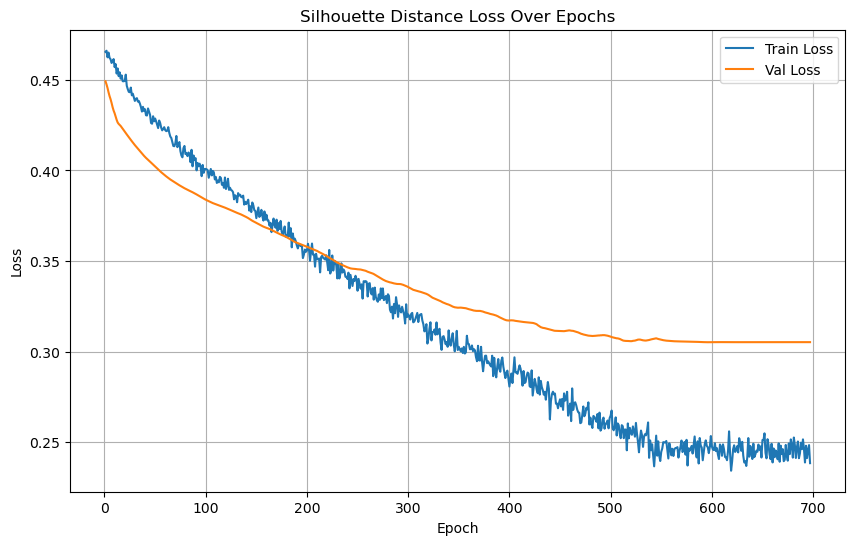

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/665], Loss: 0.2603
Test Batch [20/665], Loss: 0.1981
Test Batch [30/665], Loss: 0.2652
Test Batch [40/665], Loss: 0.3849


Test Batch [50/665], Loss: 0.5467
Test Batch [60/665], Loss: 0.4650
Test Batch [70/665], Loss: 0.2277
Test Batch [80/665], Loss: 0.2387


Test Batch [90/665], Loss: 0.1893
Test Batch [100/665], Loss: 0.1785
Test Batch [110/665], Loss: 0.5000
Test Batch [120/665], Loss: 0.2147
Test Batch [130/665], Loss: 0.2437


Test Batch [140/665], Loss: 0.2261
Test Batch [150/665], Loss: 0.1123
Test Batch [160/665], Loss: 0.1800
Test Batch [170/665], Loss: 0.1627
Test Batch [180/665], Loss: 0.5000
Test Batch [190/665], Loss: 0.1798
Test Batch [200/665], Loss: 0.2936


Test Batch [210/665], Loss: 0.5000
Test Batch [220/665], Loss: 0.1986
Test Batch [230/665], Loss: 0.1887
Test Batch [240/665], Loss: 0.5000
Test Batch [250/665], Loss: 0.5000
Test Batch [260/665], Loss: 0.5000
Test Batch [270/665], Loss: 0.5000
Test Batch [280/665], Loss: 0.5000
Test Batch [290/665], Loss: 0.5000
Test Batch [300/665], Loss: 0.5000
Test Batch [310/665], Loss: 0.1934


Test Batch [320/665], Loss: 0.1985
Test Batch [330/665], Loss: 0.1822
Test Batch [340/665], Loss: 0.1493


Test Batch [350/665], Loss: 0.1661
Test Batch [360/665], Loss: 0.2529
Test Batch [370/665], Loss: 0.1395


Test Batch [380/665], Loss: 0.1736
Test Batch [390/665], Loss: 0.1453
Test Batch [400/665], Loss: 0.1184


Test Batch [410/665], Loss: 0.1498
Test Batch [420/665], Loss: 0.1421


Test Batch [430/665], Loss: 0.2538
Test Batch [440/665], Loss: 0.3673
Test Batch [450/665], Loss: 0.2693
Test Batch [460/665], Loss: 0.4182


Test Batch [470/665], Loss: 0.3501
Test Batch [480/665], Loss: 0.3311
Test Batch [490/665], Loss: 0.2127


Test Batch [500/665], Loss: 0.3043
Test Batch [510/665], Loss: 0.1588
Test Batch [520/665], Loss: 0.2547
Test Batch [530/665], Loss: 0.2416


Test Batch [540/665], Loss: 0.2593
Test Batch [550/665], Loss: 0.5000
Test Batch [560/665], Loss: 0.2232
Test Batch [570/665], Loss: 0.2300


Test Batch [580/665], Loss: 0.2098
Test Batch [590/665], Loss: 0.2210
Test Batch [600/665], Loss: 0.3213
Test Batch [610/665], Loss: 0.2954


Test Batch [620/665], Loss: 0.4333
Test Batch [630/665], Loss: 0.3032
Test Batch [640/665], Loss: 0.1797
Test Batch [650/665], Loss: 0.3829


Test Batch [660/665], Loss: 0.3366

Test Loss: 0.2902


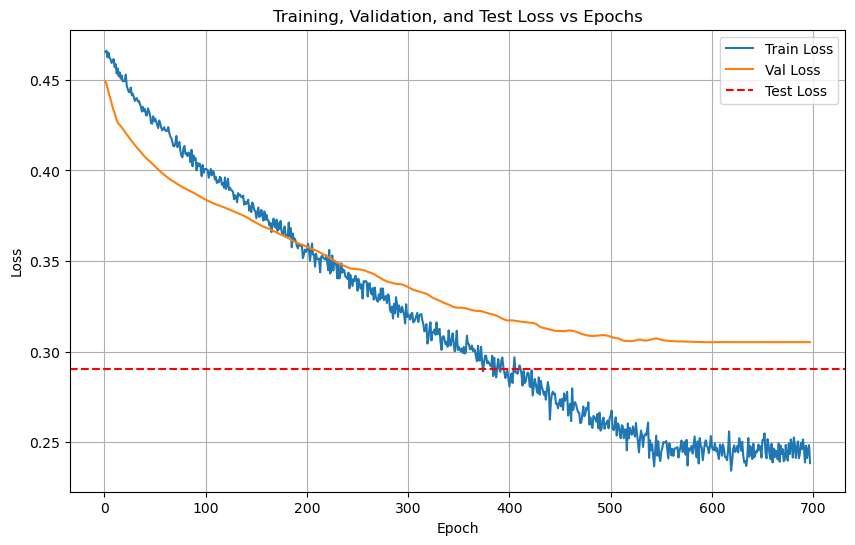

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/665 for test dataset.
  Processed batch 20/665 for test dataset.


  Processed batch 30/665 for test dataset.
  Processed batch 40/665 for test dataset.


  Processed batch 50/665 for test dataset.
  Processed batch 60/665 for test dataset.


  Processed batch 70/665 for test dataset.


  Processed batch 80/665 for test dataset.
  Processed batch 90/665 for test dataset.


  Processed batch 100/665 for test dataset.
  Processed batch 110/665 for test dataset.


  Processed batch 120/665 for test dataset.
  Processed batch 130/665 for test dataset.


  Processed batch 140/665 for test dataset.
  Processed batch 150/665 for test dataset.


  Processed batch 160/665 for test dataset.


  Processed batch 170/665 for test dataset.
  Processed batch 180/665 for test dataset.


  Processed batch 190/665 for test dataset.


  Processed batch 200/665 for test dataset.
  Processed batch 210/665 for test dataset.


  Processed batch 220/665 for test dataset.


  Processed batch 230/665 for test dataset.
  Processed batch 240/665 for test dataset.


  Processed batch 250/665 for test dataset.


  Processed batch 260/665 for test dataset.
  Processed batch 270/665 for test dataset.
  Processed batch 280/665 for test dataset.


  Processed batch 290/665 for test dataset.
  Processed batch 300/665 for test dataset.
  Processed batch 310/665 for test dataset.


  Processed batch 320/665 for test dataset.
  Processed batch 330/665 for test dataset.
  Processed batch 340/665 for test dataset.
  Processed batch 350/665 for test dataset.


  Processed batch 360/665 for test dataset.
  Processed batch 370/665 for test dataset.
  Processed batch 380/665 for test dataset.


  Processed batch 390/665 for test dataset.
  Processed batch 400/665 for test dataset.
  Processed batch 410/665 for test dataset.


  Processed batch 420/665 for test dataset.
  Processed batch 430/665 for test dataset.
  Processed batch 440/665 for test dataset.
  Processed batch 450/665 for test dataset.


  Processed batch 460/665 for test dataset.
  Processed batch 470/665 for test dataset.
  Processed batch 480/665 for test dataset.


  Processed batch 490/665 for test dataset.
  Processed batch 500/665 for test dataset.
  Processed batch 510/665 for test dataset.
  Processed batch 520/665 for test dataset.


  Processed batch 530/665 for test dataset.
  Processed batch 540/665 for test dataset.
  Processed batch 550/665 for test dataset.


  Processed batch 560/665 for test dataset.
  Processed batch 570/665 for test dataset.
  Processed batch 580/665 for test dataset.
  Processed batch 590/665 for test dataset.


  Processed batch 600/665 for test dataset.
  Processed batch 610/665 for test dataset.
  Processed batch 620/665 for test dataset.
  Processed batch 630/665 for test dataset.


  Processed batch 640/665 for test dataset.
  Processed batch 650/665 for test dataset.
  Processed batch 660/665 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.80      0.73         5
           2       1.00      0.60      0.75         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.60      0.60      0.60         5
           6       0.83      1.00      0.91         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.87        45
weighted avg       0.88      0.87      0.87        45


LOG: Evaluating on the test set...
Test Accuracy: 74.11%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2584  |  Val Loss: 2.1984
Validation loss improved from inf to 2.1984.
[Epoch 2/1000] Train Loss: 2.2094  |  Val Loss: 2.1539
Validation loss improved from 2.1984 to 2.1539.
[Epoch 3/1000] Train Loss: 2.1581  |  Val Loss: 2.1146
Validation loss improved from 2.1539 to 2.1146.
[Epoch 4/1000] Train Loss: 2.1143  |  Val Loss: 2.0755
Validation loss improved from 2.1146 to 2.0755.
[Epoch 5/1000] Train Loss: 2.0719  |  Val Loss: 2.0378
Validation loss improved from 2.0755 to 2.0378.
[Epoch 6/1000] Train Loss: 2.0305  |  Val Loss: 2.0022
Validation loss improved from 2.0378 to 2.0022.
[Epoch 7/1000] Train Loss: 1.9908  |  Val Loss: 1.9689
Validation loss improved from 2.0022 to 1.9689.
[Epoch 8/1000] Train Loss: 1.9513  |  Val Loss: 1.9373
Validation loss improved from 1.9689 to 1.9373.
[Epoch 9/1000] Train Loss: 1.9183  |  Val Loss: 1.9072
Validation loss improved from 1.9373 to 1.9072.
[Epoch 10/1000] Train Loss: 1.8858  |  Val Loss: 1.8787
Validation loss impr

[Epoch 27/1000] Train Loss: 1.4944  |  Val Loss: 1.5461
Validation loss improved from 1.5612 to 1.5461.
[Epoch 28/1000] Train Loss: 1.4768  |  Val Loss: 1.5311
Validation loss improved from 1.5461 to 1.5311.
[Epoch 29/1000] Train Loss: 1.4591  |  Val Loss: 1.5159
Validation loss improved from 1.5311 to 1.5159.
[Epoch 30/1000] Train Loss: 1.4419  |  Val Loss: 1.5001
Validation loss improved from 1.5159 to 1.5001.
[Epoch 31/1000] Train Loss: 1.4238  |  Val Loss: 1.4846
Validation loss improved from 1.5001 to 1.4846.
[Epoch 32/1000] Train Loss: 1.4059  |  Val Loss: 1.4694
Validation loss improved from 1.4846 to 1.4694.
[Epoch 33/1000] Train Loss: 1.3886  |  Val Loss: 1.4544
Validation loss improved from 1.4694 to 1.4544.
[Epoch 34/1000] Train Loss: 1.3712  |  Val Loss: 1.4400
Validation loss improved from 1.4544 to 1.4400.
[Epoch 35/1000] Train Loss: 1.3543  |  Val Loss: 1.4259
Validation loss improved from 1.4400 to 1.4259.
[Epoch 36/1000] Train Loss: 1.3378  |  Val Loss: 1.4118
Validati

[Epoch 59/1000] Train Loss: 0.9823  |  Val Loss: 1.1027
Validation loss improved from 1.1152 to 1.1027.
[Epoch 60/1000] Train Loss: 0.9681  |  Val Loss: 1.0903
Validation loss improved from 1.1027 to 1.0903.
[Epoch 61/1000] Train Loss: 0.9538  |  Val Loss: 1.0780
Validation loss improved from 1.0903 to 1.0780.
[Epoch 62/1000] Train Loss: 0.9399  |  Val Loss: 1.0658
Validation loss improved from 1.0780 to 1.0658.
[Epoch 63/1000] Train Loss: 0.9257  |  Val Loss: 1.0537
Validation loss improved from 1.0658 to 1.0537.
[Epoch 64/1000] Train Loss: 0.9118  |  Val Loss: 1.0417
Validation loss improved from 1.0537 to 1.0417.
[Epoch 65/1000] Train Loss: 0.8975  |  Val Loss: 1.0300
Validation loss improved from 1.0417 to 1.0300.
[Epoch 66/1000] Train Loss: 0.8837  |  Val Loss: 1.0185
Validation loss improved from 1.0300 to 1.0185.
[Epoch 67/1000] Train Loss: 0.8701  |  Val Loss: 1.0071
Validation loss improved from 1.0185 to 1.0071.
[Epoch 68/1000] Train Loss: 0.8563  |  Val Loss: 0.9956
Validati

[Epoch 86/1000] Train Loss: 0.6277  |  Val Loss: 0.8042
Validation loss improved from 0.8145 to 0.8042.
[Epoch 87/1000] Train Loss: 0.6158  |  Val Loss: 0.7944
Validation loss improved from 0.8042 to 0.7944.
[Epoch 88/1000] Train Loss: 0.6041  |  Val Loss: 0.7848
Validation loss improved from 0.7944 to 0.7848.
[Epoch 89/1000] Train Loss: 0.5928  |  Val Loss: 0.7753
Validation loss improved from 0.7848 to 0.7753.
[Epoch 90/1000] Train Loss: 0.5816  |  Val Loss: 0.7661
Validation loss improved from 0.7753 to 0.7661.
[Epoch 91/1000] Train Loss: 0.5706  |  Val Loss: 0.7571
Validation loss improved from 0.7661 to 0.7571.
[Epoch 92/1000] Train Loss: 0.5597  |  Val Loss: 0.7483
Validation loss improved from 0.7571 to 0.7483.
[Epoch 93/1000] Train Loss: 0.5494  |  Val Loss: 0.7396
Validation loss improved from 0.7483 to 0.7396.
[Epoch 94/1000] Train Loss: 0.5389  |  Val Loss: 0.7310
Validation loss improved from 0.7396 to 0.7310.
[Epoch 95/1000] Train Loss: 0.5287  |  Val Loss: 0.7224
Validati

[Epoch 118/1000] Train Loss: 0.3492  |  Val Loss: 0.5747
Validation loss improved from 0.5795 to 0.5747.
[Epoch 119/1000] Train Loss: 0.3435  |  Val Loss: 0.5699
Validation loss improved from 0.5747 to 0.5699.
[Epoch 120/1000] Train Loss: 0.3378  |  Val Loss: 0.5654
Validation loss improved from 0.5699 to 0.5654.
[Epoch 121/1000] Train Loss: 0.3324  |  Val Loss: 0.5613
Validation loss improved from 0.5654 to 0.5613.
[Epoch 122/1000] Train Loss: 0.3271  |  Val Loss: 0.5570
Validation loss improved from 0.5613 to 0.5570.
[Epoch 123/1000] Train Loss: 0.3219  |  Val Loss: 0.5528
Validation loss improved from 0.5570 to 0.5528.
[Epoch 124/1000] Train Loss: 0.3168  |  Val Loss: 0.5490
Validation loss improved from 0.5528 to 0.5490.
[Epoch 125/1000] Train Loss: 0.3121  |  Val Loss: 0.5449
Validation loss improved from 0.5490 to 0.5449.
[Epoch 126/1000] Train Loss: 0.3072  |  Val Loss: 0.5411
Validation loss improved from 0.5449 to 0.5411.
[Epoch 127/1000] Train Loss: 0.3027  |  Val Loss: 0.537

[Epoch 149/1000] Train Loss: 0.2249  |  Val Loss: 0.4760
Validation loss improved from 0.4781 to 0.4760.
[Epoch 150/1000] Train Loss: 0.2222  |  Val Loss: 0.4739
Validation loss improved from 0.4760 to 0.4739.
[Epoch 151/1000] Train Loss: 0.2195  |  Val Loss: 0.4721
Validation loss improved from 0.4739 to 0.4721.
[Epoch 152/1000] Train Loss: 0.2173  |  Val Loss: 0.4700
Validation loss improved from 0.4721 to 0.4700.
[Epoch 153/1000] Train Loss: 0.2147  |  Val Loss: 0.4681
Validation loss improved from 0.4700 to 0.4681.
[Epoch 154/1000] Train Loss: 0.2125  |  Val Loss: 0.4669
Validation loss improved from 0.4681 to 0.4669.
[Epoch 155/1000] Train Loss: 0.2101  |  Val Loss: 0.4654
Validation loss improved from 0.4669 to 0.4654.
[Epoch 156/1000] Train Loss: 0.2077  |  Val Loss: 0.4639
Validation loss improved from 0.4654 to 0.4639.
[Epoch 157/1000] Train Loss: 0.2056  |  Val Loss: 0.4622
Validation loss improved from 0.4639 to 0.4622.
[Epoch 158/1000] Train Loss: 0.2034  |  Val Loss: 0.460

[Epoch 182/1000] Train Loss: 0.1639  |  Val Loss: 0.4322
Validation loss improved from 0.4330 to 0.4322.
[Epoch 183/1000] Train Loss: 0.1627  |  Val Loss: 0.4315
Validation loss improved from 0.4322 to 0.4315.
[Epoch 184/1000] Train Loss: 0.1614  |  Val Loss: 0.4303
Validation loss improved from 0.4315 to 0.4303.
[Epoch 185/1000] Train Loss: 0.1601  |  Val Loss: 0.4290
Validation loss improved from 0.4303 to 0.4290.
[Epoch 186/1000] Train Loss: 0.1590  |  Val Loss: 0.4282
Validation loss improved from 0.4290 to 0.4282.
[Epoch 187/1000] Train Loss: 0.1577  |  Val Loss: 0.4275
Validation loss improved from 0.4282 to 0.4275.
[Epoch 188/1000] Train Loss: 0.1566  |  Val Loss: 0.4263
Validation loss improved from 0.4275 to 0.4263.
[Epoch 189/1000] Train Loss: 0.1554  |  Val Loss: 0.4254
Validation loss improved from 0.4263 to 0.4254.
[Epoch 190/1000] Train Loss: 0.1542  |  Val Loss: 0.4248
Validation loss improved from 0.4254 to 0.4248.
[Epoch 191/1000] Train Loss: 0.1530  |  Val Loss: 0.424

[Epoch 211/1000] Train Loss: 0.1352  |  Val Loss: 0.4116
Validation loss improved from 0.4123 to 0.4116.
[Epoch 212/1000] Train Loss: 0.1345  |  Val Loss: 0.4108
Validation loss improved from 0.4116 to 0.4108.
[Epoch 213/1000] Train Loss: 0.1339  |  Val Loss: 0.4103
Validation loss improved from 0.4108 to 0.4103.
[Epoch 214/1000] Train Loss: 0.1332  |  Val Loss: 0.4097
Validation loss improved from 0.4103 to 0.4097.
[Epoch 215/1000] Train Loss: 0.1325  |  Val Loss: 0.4092
Validation loss improved from 0.4097 to 0.4092.
[Epoch 216/1000] Train Loss: 0.1319  |  Val Loss: 0.4095
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 217/1000] Train Loss: 0.1313  |  Val Loss: 0.4099
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 218/1000] Train Loss: 0.1306  |  Val Loss: 0.4099
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 219/1000] Train Loss: 0.1300  |  Val Loss: 0.4097
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 220/1000] Train Loss: 0.

[Epoch 244/1000] Train Loss: 0.1174  |  Val Loss: 0.4065
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 245/1000] Train Loss: 0.1170  |  Val Loss: 0.4067
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 246/1000] Train Loss: 0.1166  |  Val Loss: 0.4067
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 247/1000] Train Loss: 0.1161  |  Val Loss: 0.4064
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 248/1000] Train Loss: 0.1158  |  Val Loss: 0.4063
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 249/1000] Train Loss: 0.1155  |  Val Loss: 0.4060
Validation loss improved from 0.4062 to 0.4060.
[Epoch 250/1000] Train Loss: 0.1150  |  Val Loss: 0.4060
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 251/1000] Train Loss: 0.1146  |  Val Loss: 0.4058
Validation loss improved from 0.4060 to 0.4058.
[Epoch 252/1000] Train Loss: 0.1145  |  Val Loss: 0.4050
Validation loss improved from 0.4058 to 0.4050.
[Epoch 253/1000] Tr

[Epoch 278/1000] Train Loss: 0.1060  |  Val Loss: 0.4075
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 279/1000] Train Loss: 0.1058  |  Val Loss: 0.4078
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 280/1000] Train Loss: 0.1055  |  Val Loss: 0.4077
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 281/1000] Train Loss: 0.1053  |  Val Loss: 0.4085
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 282/1000] Train Loss: 0.1050  |  Val Loss: 0.4084
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 283/1000] Train Loss: 0.1048  |  Val Loss: 0.4080
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 284/1000] Train Loss: 0.1046  |  Val Loss: 0.4082
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 285/1000] Train Loss: 0.1043  |  Val Loss: 0.4091
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 286/1000] Train Loss: 0.1040  |  Val Loss: 0.4091
!! Validation loss did NOT improve !! Patience:

[Epoch 310/1000] Train Loss: 0.0987  |  Val Loss: 0.4136
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 311/1000] Train Loss: 0.0986  |  Val Loss: 0.4139
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 312/1000] Train Loss: 0.0984  |  Val Loss: 0.4142
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 313/1000] Train Loss: 0.0982  |  Val Loss: 0.4143
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 314/1000] Train Loss: 0.0981  |  Val Loss: 0.4136
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 315/1000] Train Loss: 0.0979  |  Val Loss: 0.4133
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 316/1000] Train Loss: 0.0976  |  Val Loss: 0.4134
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 317/1000] Train Loss: 0.0975  |  Val Loss: 0.4143
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 318/1000] Train Loss: 0.0972  |  Val Loss: 0.4143
!! Validation loss did NOT improve !! Patience:

[Epoch 342/1000] Train Loss: 0.0933  |  Val Loss: 0.4186
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 343/1000] Train Loss: 0.0932  |  Val Loss: 0.4185
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 344/1000] Train Loss: 0.0930  |  Val Loss: 0.4192
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 345/1000] Train Loss: 0.0930  |  Val Loss: 0.4203
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 346/1000] Train Loss: 0.0927  |  Val Loss: 0.4209
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 347/1000] Train Loss: 0.0926  |  Val Loss: 0.4214
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 348/1000] Train Loss: 0.0924  |  Val Loss: 0.4209
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 349/1000] Train Loss: 0.0923  |  Val Loss: 0.4205
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 350/1000] Train Loss: 0.0922  |  Val Loss: 0.4200
!! Validation loss did NOT improve !! Patience:

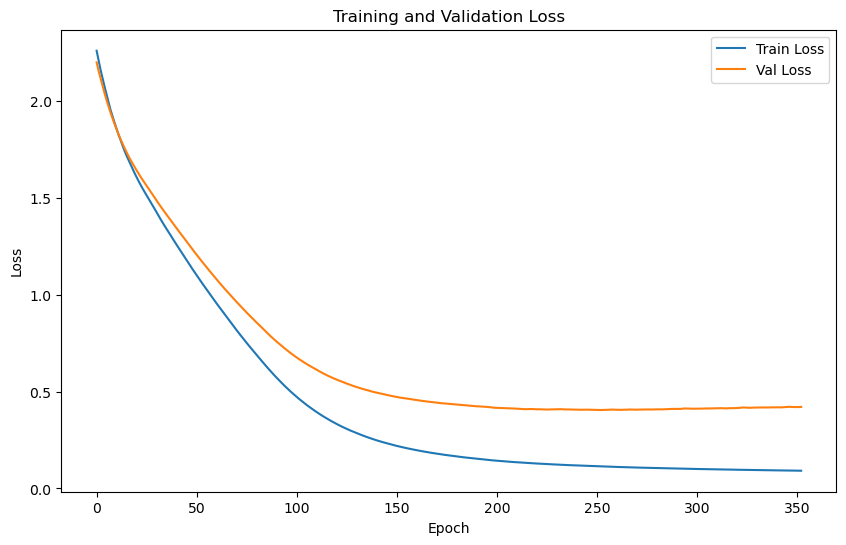

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.1529 | Test Accuracy: 74.62%


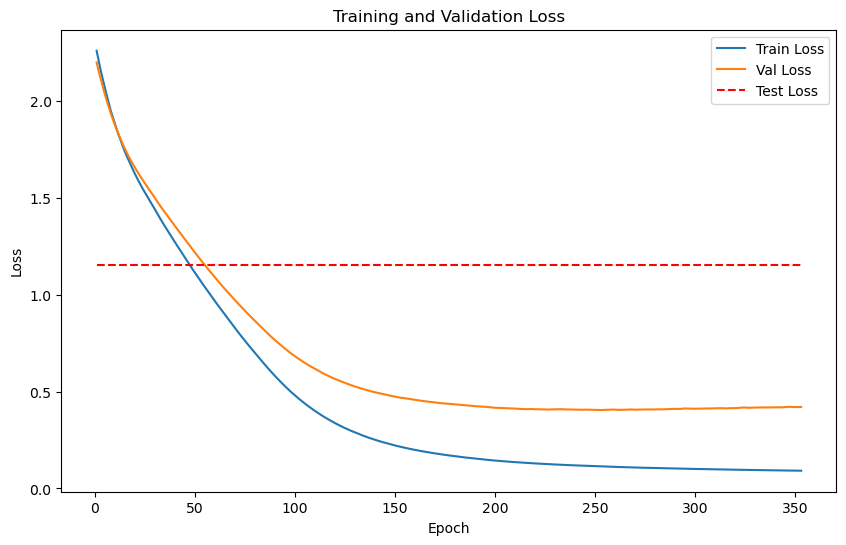

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


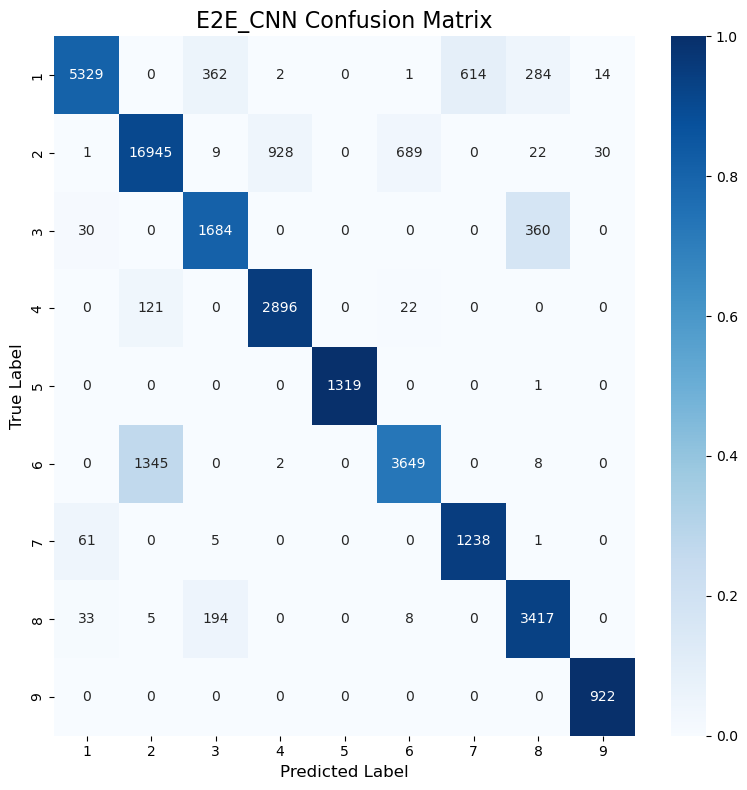

Classification Accuracy: 87.89%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


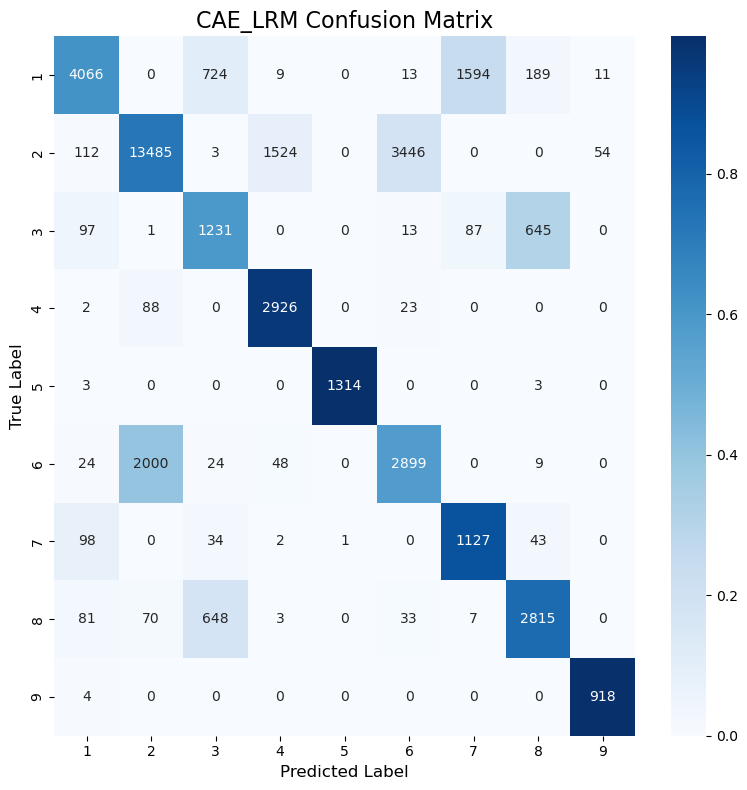

Classification Accuracy: 72.34%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


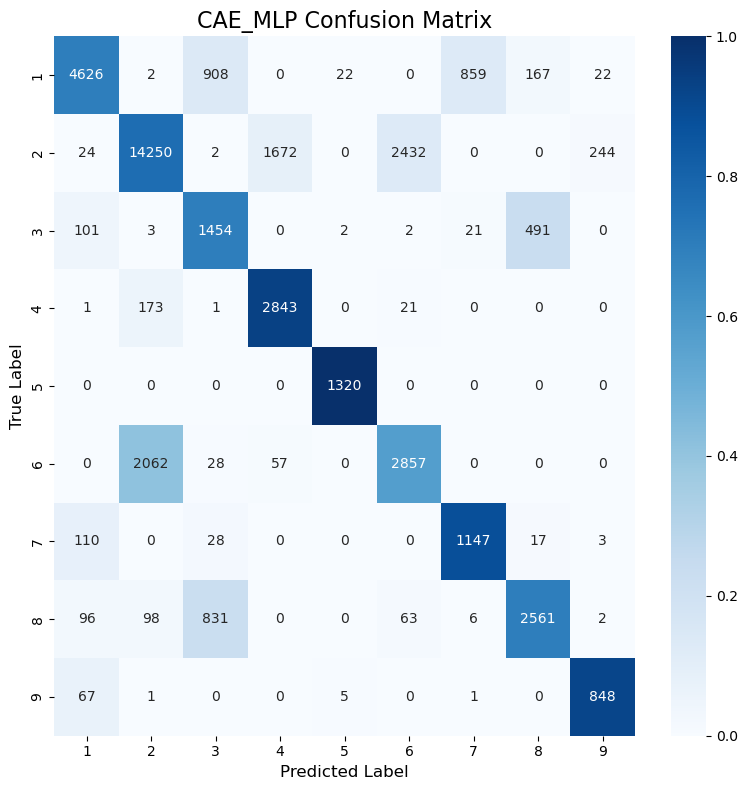

Classification Accuracy: 74.98%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


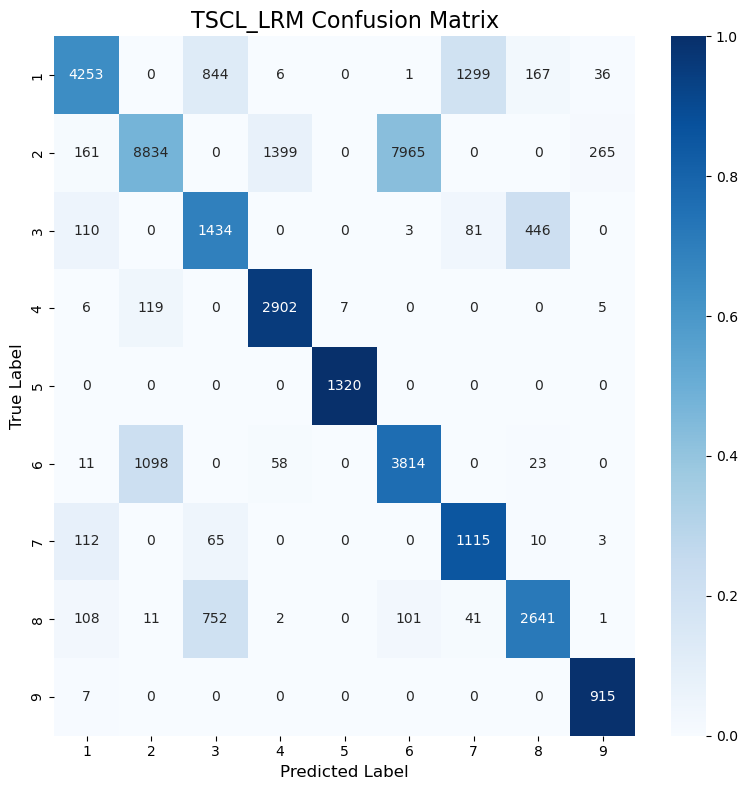

Classification Accuracy: 63.99%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


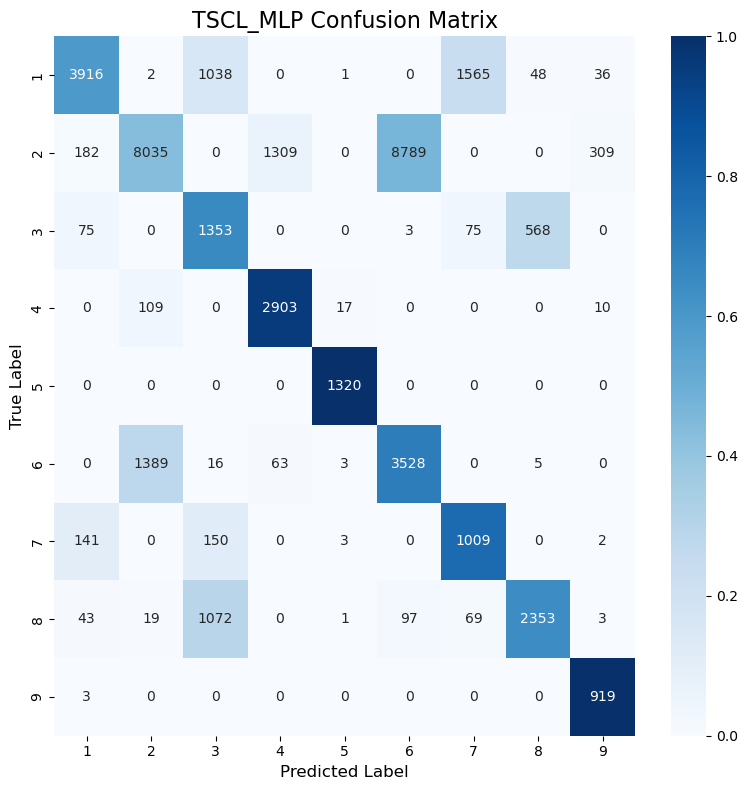

Classification Accuracy: 59.54%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


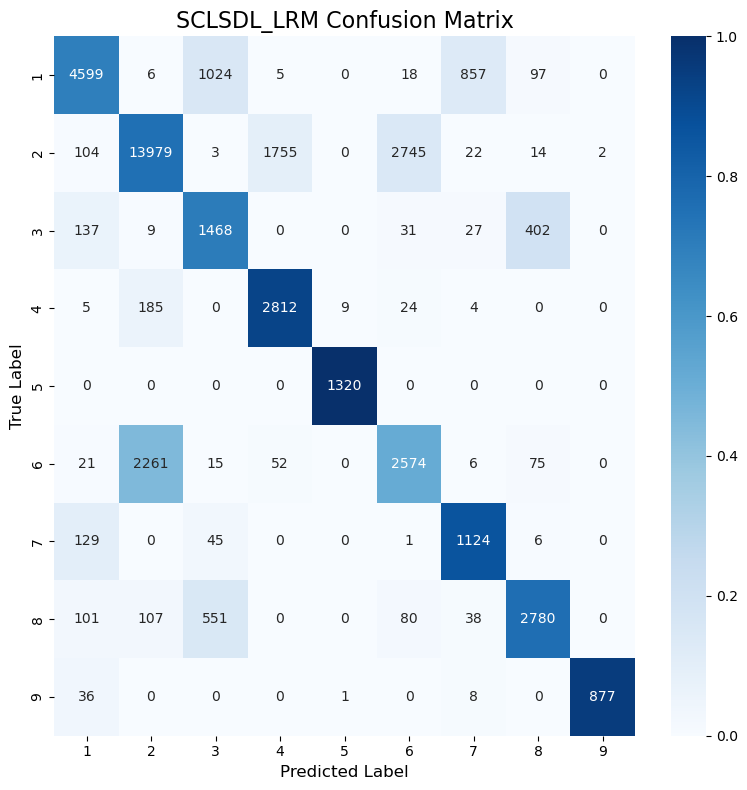

Classification Accuracy: 74.11%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


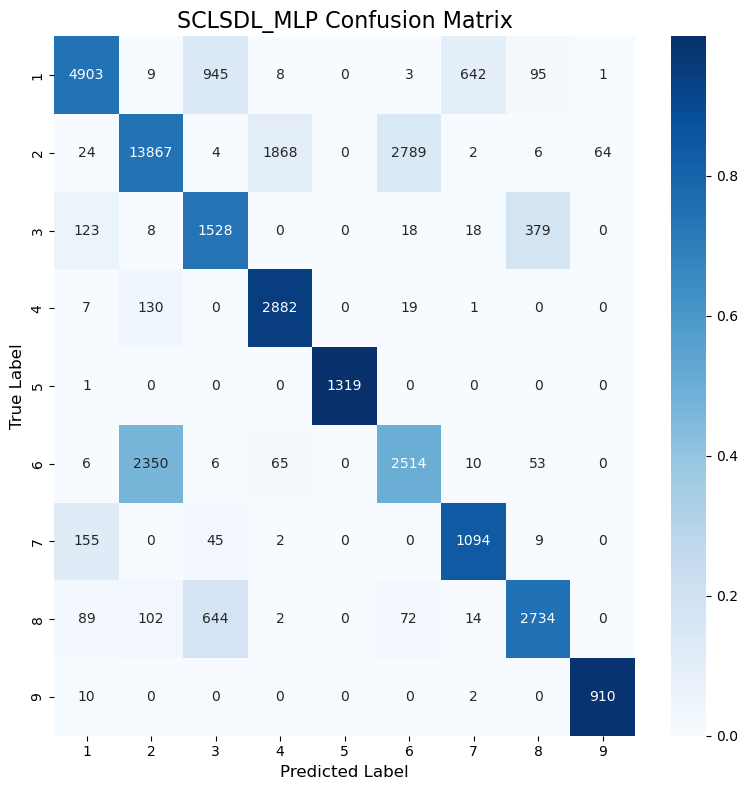

Classification Accuracy: 74.62%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          87.89
1    LRM (CAE)          72.34
2    MLP (CAE)          74.98
3     TSCL LRM          63.99
4     TSCL MLP          59.54
5  SCL_SDL LRM          74.11
6  SCL_SDL MLP          74.62

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          87.89
2    MLP (CAE)          74.98
6  SCL_SDL MLP          74.62
5  SCL_SDL LRM          74.11
1    LRM (CAE)          72.34
3     TSCL LRM          63.99
4     TSCL MLP          59.54
